# Experiment Purpose
This Jupyter Notebook outlines a comprehensive pipeline for fine-tuning Large Language Models (LLMs) for Medical Question Answering (MedQA) tasks. The 4 experiments focus on leveraging Parameter-Efficient Fine-Tuning (PEFT) methods, particularly Low-Rank Adaptation (LoRA), to adapt the `TinyLlama/TinyLlama-1.1B-Chat-v1.0` model.

The notebook covers the entire workflow:

1.  **Data Preprocessing**: Outsourced QA datasets from kaggle and HuggingFace (MedQuAD and AfrimedQA_v2)respectively into a unified format suitable for instruction-tuned LLMs.

2.  **Model Training with PEFT (LoRA)**: Implemented and executed fine-tuning runs with varying hyperparameters to optimize performance while minimizing computational resources.

3.  **Inference Demonstration**: Showcased the capabilities of the fine-tuned models through response generation and a Gradio-based interactive deployed on HuggingFace's space.

4.  **Evaluation**: Performed both automatic (ROUGE, BLEU, F1-Score, Readability) and qualitative analyses to compare the performance of fine-tuned models against a baseline.

5.  **Hugging Face Integration**: After demo with in-notebook gradio interface for every finedmodel eventually combined all of them in HuggingFace.

The ultimate goal is to enhance the `TinyLlama` model's ability to provide accurate and contextually relevant answers to medical questions, with the entire setup designed for seamless execution within a this google notebook.

In [6]:
import sys

def try_import(library_name):
    try:
        __import__(library_name)
        print(f"Successfully imported {library_name}")
    except ImportError:
        print(f"Could not import {library_name}. Please ensure it is installed.")

try_import('accelerate')
try_import('bitsandbytes')
try_import('datetime')
try_import('datasets')
try_import('evaluate')
try_import('glob')
try_import('google.colab')
try_import('gradio')
try_import('huggingface_hub')
try_import('json')
try_import('kagglehub')
try_import('matplotlib')
try_import('nltk')
try_import('numpy')
try_import('os')
try_import('pandas')
try_import('peft')
try_import('pickle')
try_import('re')
try_import('rouge_score')
try_import('seaborn')
try_import('string')
try_import('subprocess')
try_import('sys')
try_import('textstat')
try_import('textwrap')
try_import('time')
try_import('torch')
try_import('transformers')

Successfully imported accelerate
Successfully imported bitsandbytes
Successfully imported datetime
Successfully imported datasets
Could not import evaluate. Please ensure it is installed.
Successfully imported glob
Successfully imported google.colab
Successfully imported gradio
Successfully imported huggingface_hub
Successfully imported json
Successfully imported kagglehub
Successfully imported matplotlib
Successfully imported nltk
Successfully imported numpy
Successfully imported os
Successfully imported pandas
Successfully imported peft
Successfully imported pickle
Successfully imported re
Successfully imported rouge_score
Successfully imported seaborn
Successfully imported string
Successfully imported subprocess
Successfully imported sys
Successfully imported textstat
Successfully imported textwrap
Successfully imported time
Successfully imported torch
Successfully imported transformers


### Dataset Identification, Curation, and Preprocessing for Fine-tuning


In [ ]:
from datasets import load_dataset

# Load the intronhealth/afrimedqa_v2 dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')

print("intronhealth/afrimedqa_v2 dataset loaded successfully:")
print(afrimedqa_dataset)

# Display a sample of its content (first example from the 'train' split)
print("\nSample from intronhealth/afrimedqa_v2 (train split, first example):")
if 'train' in afrimedqa_dataset and len(afrimedqa_dataset['train']) > 0:
    print(afrimedqa_dataset['train'][0])
else:
    print("Train split is empty or not available.")

README.md:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

afri_med_qa_15k_v2.4_phase_2_15275.csv:   0%|          | 0.00/8.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15275 [00:00<?, ? examples/s]

intronhealth/afrimedqa_v2 dataset loaded successfully:
DatasetDict({
    train: Dataset({
        features: ['sample_id', 'split', 'gender', 'discipline', 'clinical_experience', 'country', 'question_type', 'prompt', 'question', 'question_clean', 'answer_options', 'correct_answer', 'answer_rationale', 'specialty', 'region_specific', 'mentions_Africa', 'mentions_age', 'mentions_gender', 'tier', 'neg_percent', 'quality', 'rated_african', 'rated_correct', 'rated_omission', 'rated_hallucination', 'rated_reasonable', 'rated_harmful', 'rated_bias', 'version'],
        num_rows: 15275
    })
})

Sample from intronhealth/afrimedqa_v2 (train split, first example):
{'sample_id': 'ff784abc6b461a6a15d7f8bf5e6560d3393474fe4748699ff4c7f2124292b95f', 'split': 'train', 'gender': 'Male', 'discipline': 'Non-Health', 'clinical_experience': 'Intern', 'country': 'NG', 'question_type': 'consumer_queries', 'prompt': 'Your female friend complains of weight gain, high blood pressure and thinks she has Lupus Nep

In [ ]:
import kagglehub
import os

# Download the MedQuAD dataset files
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

print(f"MedQuAD dataset downloaded successfully to: {medquad_download_path}")

# List the contents of the downloaded directory
print("\nContents of the MedQuAD dataset directory:")
for item in os.listdir(medquad_download_path):
    print(item)


100%|██████████| 4.95M/4.95M [00:00<00:00, 59.8MB/s]

Extracting files...


MedQuAD dataset downloaded successfully to: /root/.cache/kagglehub/datasets/pythonafroz/medquad-medical-question-answer-for-ai-research/versions/1

Contents of the MedQuAD dataset directory:
medquad.csv


In [ ]:
import pandas as pd
import os

# Construct the full path to the medquad.csv file
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')

# Load the MedQuAD dataset from the CSV file into a pandas DataFrame
medquad_df = pd.read_csv(medquad_csv_path)

print("MedQuAD dataset (DataFrame) loaded successfully:")
print(medquad_df.head())
print(f"\nShape of MedQuAD DataFrame: {medquad_df.shape}")

MedQuAD dataset (DataFrame) loaded successfully:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  

Shape of MedQuAD DataFrame: (16412, 4)


In [ ]:
from datasets import Dataset

# Create a new DataFrame with 'instruction' and 'response' columns from medquad_df
# Ensure both question and answer are strings
medquad_qa_df = medquad_df.copy()
medquad_qa_df['instruction'] = medquad_qa_df['question'].astype(str)
medquad_qa_df['response'] = medquad_qa_df['answer'].astype(str)

# Select only the relevant columns and convert to a Hugging Face Dataset
medquad_qa_dataset = Dataset.from_pandas(medquad_qa_df[['instruction', 'response']])

print("MedQuAD dataset converted to unified QA format successfully:")
print(medquad_qa_dataset)
print("\nSample from MedQuAD QA dataset (first example):")
print(medquad_qa_dataset[0])

MedQuAD dataset converted to unified QA format successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 16412
})

Sample from MedQuAD QA dataset (first example):
{'instruction': 'What is (are) Glaucoma ?', 'response': "Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As 

In [ ]:
from datasets import Dataset
import pandas as pd

# Convert the afrimedqa_dataset to a pandas DataFrame first for easier manipulation
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()

# Create 'instruction' and 'response' columns for afrimedqa_df
# Use 'question' as instruction and 'answer_rationale' as response.
# Handle potential None values by converting to empty string if None.
afrimedqa_df['instruction'] = afrimedqa_df['question'].astype(str)
afrimedqa_df['response'] = afrimedqa_df['answer_rationale'].fillna('').astype(str)

# Select only the relevant columns and convert to a Hugging Face Dataset
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['instruction', 'response']])

print("intronhealth/afrimedqa_v2 dataset converted to unified QA format successfully:")
print(afrimedqa_qa_dataset)
print("\nSample from intronhealth/afrimedqa_v2 QA dataset (first example):")
print(afrimedqa_qa_dataset[0])

intronhealth/afrimedqa_v2 dataset converted to unified QA format successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 15275
})

Sample from intronhealth/afrimedqa_v2 QA dataset (first example):
{'instruction': 'Can you provide recommendations for managing stress and improving mental well-being in relation to my condition?', 'response': ''}


In [ ]:
from datasets import concatenate_datasets

# Concatenate the two unified datasets
unified_dataset = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])

print("Unified dataset created successfully:")
print(unified_dataset)
print("\nSample from unified dataset (first example):")
print(unified_dataset[0])
print("\nSample from unified dataset (last example - from afrimedqa):")
print(unified_dataset[len(unified_dataset) - 1])

Unified dataset created successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 31687
})

Sample from unified dataset (first example):
{'instruction': 'What is (are) Glaucoma ?', 'response': "Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the p

In [ ]:
from datasets import DatasetDict

# Initial cleaning: Remove entries where 'instruction' or 'response' is empty or consists only of whitespace
# This ensures data quality before splitting.
initial_num_rows = len(unified_dataset)
unified_dataset = unified_dataset.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
cleaned_num_rows = len(unified_dataset)

print(f"Removed {initial_num_rows - cleaned_num_rows} entries due to empty instruction or response.")
print(f"Unified dataset after cleaning: {unified_dataset}")

# Split the unified dataset into training, validation, and test sets
# Using a common split ratio like 80% train, 10% validation, 10% test.
# First, shuffle the dataset to ensure a good mix of data from both sources.
shuffled_dataset = unified_dataset.shuffle(seed=42)

# Split into 80% train, 20% (validation + test)
train_test_split = shuffled_dataset.train_test_split(test_size=0.2, seed=42)

# Further split the 20% into 10% validation and 10% test
# We'll split the 'test_size' (0.2) in half for validation and test, so 0.5 of the 0.2
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)

# Create the final DatasetDict
train_val_test_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'], # 'train' of val_test_split becomes validation
    'test': val_test_split['test']        # 'test' of val_test_split remains test
})

print("\nUnified dataset split into training, validation, and test sets successfully:")
print(train_val_test_dataset)

# Display sample from each split
print("\nSample from training set (first example):")
print(train_val_test_dataset['train'][0])
print("\nSample from validation set (first example):")
print(train_val_test_dataset['validation'][0])
print("\nSample from test set (first example):")
print(train_val_test_dataset['test'][0])


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Removed 13565 entries due to empty instruction or response.
Unified dataset after cleaning: Dataset({
    features: ['instruction', 'response'],
    num_rows: 18122
})

Unified dataset split into training, validation, and test sets successfully:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 14497
    })
    validation: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1812
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1813
    })
})

Sample from training set (first example):
{'instruction': 'What are the symptoms of Porokeratosis of Mibelli ?', 'response': 'What are the signs and symptoms of Porokeratosis of Mibelli? The Human Phenotype Ontology provides the following list of signs and symptoms for Porokeratosis of Mibelli. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the Medlin

In [ ]:
from transformers import AutoTokenizer

# Define the base model for which the tokenizer will be used
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token if it doesn't exist (common for some models like TinyLlama)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token

# Define a function to format the dataset into instruction-response pairs suitable for chat models
def format_prompt(example):
    # Ensure both 'instruction' and 'response' are strings
    instruction = str(example['instruction'])
    response = str(example['response'])

    # Use a simple instruction-following format. For more complex models,
    # consider chat templates like `tokenizer.apply_chat_template`.
    # Example template: "### Instruction:\n{instruction}\n\n### Response:\n{response}"
    # For TinyLlama-1.1B-Chat-v1.0, a simple QA format or chat format might be suitable.
    # Let's use a format similar to Alpaca or LLaMA instruction tuning.
    formatted_text = f"""### Instruction:
{instruction}

### Response:
{response}"""
    return {'text': formatted_text}

# Apply the formatting function to all splits of the dataset
formatted_dataset = train_val_test_dataset.map(format_prompt, remove_columns=['instruction', 'response'])

# Tokenization function
def tokenize_function(examples):
    # Tokenize the 'text' column generated by the format_prompt function
    # Truncation and padding are important for context window management
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

# Apply tokenization to all splits of the formatted dataset
tokenized_dataset = formatted_dataset.map(tokenize_function, batched=True)

print("Tokenizer loaded and applied to the dataset successfully.")
print(f"Tokenizer pad_token: {tokenizer.pad_token}")
print(f"Tokenizer pad_token_id: {tokenizer.pad_token_id}")
print("\nSample of tokenized training data (first example keys):\n")
print(tokenized_dataset['train'][0].keys())
print("\nSample of tokenized training data (first example 'input_ids' length):\n")
print(len(tokenized_dataset['train'][0]['input_ids']))
print("\nSample of tokenized training data (first example 'attention_mask' length):\n")
print(len(tokenized_dataset['train'][0]['attention_mask']))

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Tokenizer loaded and applied to the dataset successfully.
Tokenizer pad_token: </s>
Tokenizer pad_token_id: 2

Sample of tokenized training data (first example keys):

dict_keys(['text', 'input_ids', 'attention_mask'])

Sample of tokenized training data (first example 'input_ids' length):

512

Sample of tokenized training data (first example 'attention_mask' length):

512


## Evaluate Baseline Model (Automatic Metrics)
Compute and record the automatic evaluation metrics (ROUGE, BLEU, F1-score, Exact Match, and readability indices) for the baseline model's responses against the test set's reference answers.

In [ ]:
# Save DataFrame
baseline_responses_df.to_pickle("baseline_responses.pkl")

# Later, to load it back
import pandas as pd
baseline_responses_df = pd.read_pickle("baseline_responses.pkl")
print(f"Loaded {len(baseline_responses_df)} baseline responses.")


Loaded 1813 baseline responses.


In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import pandas as pd
import os
import kagglehub

# Start of included dependencies for train_val_test_dataset and tokenizer

# Load the tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load intronhealth/afrimedqa_v2 dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')

# Download MedQuAD dataset files
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

# Load MedQuAD dataset from CSV into pandas DataFrame
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)

# Convert MedQuAD to unified QA format
medquad_qa_df = medquad_df.copy()
medquad_qa_df['instruction'] = medquad_qa_df['question'].astype(str)
medquad_qa_df['response'] = medquad_qa_df['answer'].astype(str)
medquad_qa_dataset = Dataset.from_pandas(medquad_qa_df[['instruction', 'response']])

# Convert afrimedqa_v2 to unified QA format
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df['instruction'] = afrimedqa_df['question'].astype(str)
afrimedqa_df['response'] = afrimedqa_df['answer_rationale'].fillna('').astype(str)
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['instruction', 'response']])

# Concatenate unified datasets
unified_dataset = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])

# Initial cleaning and split into training, validation, and test sets
unified_dataset = unified_dataset.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
shuffled_dataset = unified_dataset.shuffle(seed=42)
train_test_split = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_val_test_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})
# End of included dependencies

# 1. Load the base model
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" #choose the model for its lightweight and workable capabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for baseline model: {device}")

# Define base keyword arguments for model loading
model_load_kwargs_base = {
    "pretrained_model_name_or_path": base_model_name,
    "device_map": "auto",
    "dtype": torch.bfloat16 if torch.cuda.is_available() else torch.float32,
}

base_model = None
try:
    if torch.cuda.is_available():
        print("Attempting to load model with 4-bit quantization.")
        quantization_config_baseline = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        # Create a copy and add quantization_config
        model_load_kwargs_quant = model_load_kwargs_base.copy()
        model_load_kwargs_quant["quantization_config"] = quantization_config_baseline
        base_model = AutoModelForCausalLM.from_pretrained(**model_load_kwargs_quant)
        print("Model loaded successfully with 4-bit quantization.")
    else:
        print("CUDA not available. Loading model in full precision.")
        base_model = AutoModelForCausalLM.from_pretrained(**model_load_kwargs_base)

except ImportError as e:
    if "bitsandbytes" in str(e):
        print(f"Warning: Bitsandbytes ImportError encountered: {e}. Falling back to loading model in full precision.")
        base_model = AutoModelForCausalLM.from_pretrained(**model_load_kwargs_base)
    else:
        raise # raise if it's not a bitsandbytes-related ImportError
except Exception as e:
    print(f"An unexpected error occurred during model loading: {e}. Attempting to load in full precision.")
    base_model = AutoModelForCausalLM.from_pretrained(**model_load_kwargs_base)


base_model.eval() # Set model to evaluation mode

# 2. Create an empty list to store the results
baseline_results = []
print("Generating baseline responses for the test set...")

# Get the raw test dataset split (not the tokenized one, to easily access instruction and response)
test_dataset_raw = train_val_test_dataset['test']

# 3. Iterate through the test dataset
# 4. For each example, generate a response using the base model
# 5. Decode the generated tokens
# 6. Store the results

for i in range(len(test_dataset_raw)):
    original_instruction = str(test_dataset_raw[i]['instruction'])
    reference_response = str(test_dataset_raw[i]['response'])

    # Construct the prompt for generation (only the instruction part)
    instruction_prompt = f"""### Instruction:
{original_instruction}

### Response:"""

    # Tokenize the instruction prompt and get attention mask using the __call__ method
    encoded_input = tokenizer(
        instruction_prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        return_attention_mask=True
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Generate response using greedy decoding for baseline consistency
    with torch.no_grad():
        output_ids = base_model.generate(
            input_ids,
            attention_mask=attention_mask, # Pass attention mask
            max_new_tokens=256, # Limit generated response length
            do_sample=False, # Greedy decoding
            pad_token_id=tokenizer.eos_token_id # Use eos_token_id as pad_token_id
        )

    # Decode the generated output, excluding the input prompt tokens
    generated_text = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True).strip()

    baseline_results.append({
        'instruction': original_instruction,
        'reference_response': reference_response,
        'generated_response': generated_text
    })

print(f"Generated {len(baseline_results)} baseline responses.")

# Convert the list of dictionaries to a pandas DataFrame for easier analysis
baseline_responses_df = pd.DataFrame(baseline_results)

# 7. Print a few sample generated responses to verify the process
print("\n--- Sample Baseline Responses (First 5) ---")
for j in range(min(5, len(baseline_responses_df))):
    sample = baseline_responses_df.iloc[j]
    print(f"\n--- Sample {j+1} ---")
    print(f"Instruction: {sample['instruction']}")
    print(f"Reference: {sample['reference_response']}")
    print(f"Generated: {sample['generated_response']}")
    print("-" * 20)

print(f"\nBaseline responses DataFrame shape: {baseline_responses_df.shape}")

Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Using device for baseline model: cuda
Attempting to load model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Generating baseline responses for the test set...
Generated 1813 baseline responses.

--- Sample Baseline Responses (First 5) ---

--- Sample 1 ---
Instruction: What are the treatments for Hypotrichosis simplex ?
Reference: Is there treatment for hypotrichosis simplex? Is there hope for hair growth in the future? Individuals with hypotrichosis simplex experience a gradual loss of scalp hair that begins during the middle of the first decade and results in almost complete loss of hair by the third decade. A few sparse, fine, short hairs may remain in some individuals. There is currently no treatment for hypotrichosis simplex.
Generated: Hypotrichosis simplex is a genetic disorder characterized by excessive hair growth on the scalp. Treatment options for hypotrichosis simplex may include:

1. Hair transplantation: This is the most common treatment for hypotrichosis simplex. A hair transplant involves removing excess hair from the scalp and replacing it with healthy hair from the donor are

In [4]:
import subprocess
import sys

try:
    import bitsandbytes
except ImportError:
    print("bitsandbytes not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "bitsandbytes>=0.46.1"])
    print("bitsandbytes installed successfully.")

# Also ensure accelerate is installed for device_map="auto"
try:
    import accelerate
except ImportError:
    print("accelerate not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "accelerate"])
    print("accelerate installed successfully.")

try:
    from rouge_score import rouge_scorer
except ImportError:
    print("rouge_score not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge-score"])
    from rouge_score import rouge_scorer
    print("rouge_score installed successfully.")

try:
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("NLTK 'punkt' tokenizer not found, downloading...")
        nltk.download('punkt')
        print("NLTK 'punkt' downloaded successfully.")
    # Add check and download for punkt_tab
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        print("NLTK 'punkt_tab' tokenizer not found, downloading...")
        nltk.download('punkt_tab')
        print("NLTK 'punkt_tab' downloaded successfully.")

except ImportError:
    print("NLTK not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    print("NLTK installed successfully. Downloading 'punkt' and 'punkt_tab'...")
    nltk.download('punkt')
    nltk.download('punkt_tab') # Also download punkt_tab here
    print("NLTK 'punkt' and 'punkt_tab' downloaded successfully.")

try:
    import textstat
except ImportError:
    print("textstat not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "textstat"])
    import textstat
    print("textstat installed successfully.")

import re
import string

print("All necessary evaluation libraries and NLTK data are ready.")

rouge_score not found, installing...
rouge_score installed successfully.
NLTK 'punkt' tokenizer not found, downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NLTK 'punkt' downloaded successfully.
NLTK 'punkt_tab' tokenizer not found, downloading...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK 'punkt_tab' downloaded successfully.
textstat not found, installing...
textstat installed successfully.
All necessary evaluation libraries and NLTK data are ready.


In [ ]:
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import textstat
import re
import string
import pandas as pd

# --- Helper Functions for Metrics ---

def calculate_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    # BLEU expects a list of tokenized reference sentences and a tokenized hypothesis
    # Reference is a single string here, so put it in a list of one list of tokens
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    # Ensure at least one token for calculation
    if not tokenized_hypothesis:
        return 0.0
    return sentence_bleu(tokenized_reference, tokenized_hypothesis)

def calculate_exact_match(reference, hypothesis):
    # Simple exact match after basic normalization
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()

    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    # This is a simplified F1 score, often used in QA for token overlap
    # For more robust F1, often a more complex token-level comparison or embedding-based F1 is used.
    # This version is similar to the token-overlap F1 from SQuAD evaluation.
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()

    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)

    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0

    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)

    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    # Ensure text is not empty before calculating readability metrics
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    return {
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text)
    }

# --- Evaluation Loop ---

all_evaluation_results = []

print("Calculating metrics for baseline responses...")

# Assuming baseline_responses_df is available from the previous step (cell df4f0b29)
for index, row in baseline_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Handle empty strings gracefully for all metrics
    if not reference.strip() or not hypothesis.strip():
        # Skip or assign default values if either is empty
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    all_evaluation_results.append({
        'Experiment_ID': 'Baseline_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# Convert results to a DataFrame
baseline_metrics_df = pd.DataFrame(all_evaluation_results)

# Display aggregated metrics for the baseline model
print("\nAggregated Baseline Model Metrics:")
print(baseline_metrics_df[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nSample of detailed baseline metrics (first 5 entries):")
print(baseline_metrics_df.head())


Calculating metrics for baseline responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Aggregated Baseline Model Metrics:
ROUGE-1_F                0.285507
ROUGE-2_F                0.083173
ROUGE-L_F                0.178051
BLEU                     0.029740
Exact_Match              0.000000
F1_Score                 0.156921
Flesch_Kincaid_Grade    12.228807
SMOG_Index              14.006848
dtype: float64

Sample of detailed baseline metrics (first 5 entries):
    Experiment_ID                                        Instruction  \
0  Baseline_Model  What are the treatments for Hypotrichosis simp...   
1  Baseline_Model                           What causes Trisomy 18 ?   
2  Baseline_Model  How to prevent Sexual and Urologic Problems of...   
3  Baseline_Model  Do you have information about Fluid and Electr...   
4  Baseline_Model  what research (or clinical trials) is being do...   

                                  Reference_Response  \
0  Is there treatment for hypotrichosis simplex? ...   
1  What causes Trisomy 18? In most cases, trisomy...   
2  People with diabe

## Fine-tuning Strategy Design (LoRA & PEFT)


In [ ]:
import subprocess
import sys

print("Re-installing bitsandbytes and accelerate to ensure optimizer compatibility...")

try:
    # Install latest bitsandbytes version
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "bitsandbytes"])
    print("bitsandbytes re-installed successfully.")
except Exception as e:
    print(f"Error re-installing bitsandbytes: {e}")

try:
    # Install accelerate
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "accelerate"])
    print("accelerate re-installed successfully.")
except Exception as e:
    print(f"Error re-installing accelerate: {e}")

print("Please RESTART THE RUNTIME (e.g., in Colab: Runtime -> Restart runtime) after this cell finishes execution, then run all cells again starting from the beginning.")


Re-installing bitsandbytes and accelerate to ensure optimizer compatibility...
bitsandbytes re-installed successfully.
accelerate re-installed successfully.
Please RESTART THE RUNTIME (e.g., in Colab: Runtime -> Restart runtime) after this cell finishes execution, then run all cells again starting from the beginning.


In [ ]:
import torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

# 1. Load the base model and move it to a GPU if available
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define quantization config for 4-bit loading
# Only if CUDA is available, otherwise 4-bit loading is not supported
quantization_config = None
if torch.cuda.is_available():
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )

# Load the model with appropriate dtype and quantization config
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quantization_config, # Pass the quantization config here
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32, # Use dtype instead of torch_dtype
    device_map="auto"
)

# 2. Configure LoRA parameters
# Define target modules based on TinyLlama's architecture (common ones for Llama-like models)
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

lora_config = LoraConfig(
    r=8,  # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    target_modules=target_modules, # Modules to apply LoRA to
    lora_dropout=0.05, # Dropout probability for LoRA layers
    bias="none", # Bias type for LoRA layers
    task_type=TaskType.CAUSAL_LM # Task type for causal language modeling
)

# 3. Integrate the LoRA configuration with the base model
peft_model = get_peft_model(model, lora_config)

# 4. Print a summary of the trainable parameters
print("\nPEFT model summary:")
peft_model.print_trainable_parameters()

# Initialize the `TrainingArguments`
training_args = TrainingArguments(
    output_dir="./tinyllama_medqa_finetuned", # Output directory for model checkpoints
    num_train_epochs=3, # Number of training epochs
    per_device_train_batch_size=4, # Batch size per GPU/CPU for training
    gradient_accumulation_steps=8, # Number of updates steps to accumulate before performing a backward/update pass
    optim="paged_adamw_8bit", # Optimizer (paged_adamw_8bit for memory efficiency)
    learning_rate=2e-4, # Learning rate
    logging_steps=50, # Log every N steps
    save_steps=200, # Save checkpoint every N steps
    eval_steps=200, # Evaluate every N steps
    seed=42, # Random seed for reproducibility
    fp16=False, # fp16 and bf16 are mutually exclusive; using bf16 via BitsAndBytesConfig if available
    bf16=torch.cuda.is_available() and quantization_config is not None, # Use bf16 if GPU is available and quantization is used
    gradient_checkpointing=True, # Enable gradient checkpointing for memory efficiency
    report_to="none", # Disable reporting to external services like Weights & Biases
    remove_unused_columns=False, # Important for PEFT to not remove columns that might be needed
    # Removed evaluation_strategy="epoch" to fix TypeError
    save_total_limit=2 # Only keep the last 2 checkpoints
)

# Define the DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Initialize the Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
)

print("\nTrainer initialized successfully.")

# Describe how to save and reuse the model
print("\nSaving and Reusing Models:")
print("To save the fine-tuned adapter weights: `trainer.model.save_pretrained(\"my_peft_model\")`")
print("To load the PEFT model for inference:")
print("1. Load the base model: `base_model = AutoModelForCausalLM.from_pretrained(\"TinyLlama/TinyLlama-1.1B-Chat-v1.0\", ...) `")
print("2. Load the PEFT adapters: `from peft import PeftModel; model = PeftModel.from_pretrained(base_model, \"my_peft_model\")`")
print("3. Merge and save the full model (optional): `merged_model = model.merge_and_unload(); merged_model.save_pretrained(\"merged_tinyllama\")`")

Using device: cpu


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


PEFT model summary:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701

Trainer initialized successfully.

Saving and Reusing Models:
To save the fine-tuned adapter weights: `trainer.model.save_pretrained("my_peft_model")`
To load the PEFT model for inference:
1. Load the base model: `base_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", ...) `
2. Load the PEFT adapters: `from peft import PeftModel; model = PeftModel.from_pretrained(base_model, "my_peft_model")`
3. Merge and save the full model (optional): `merged_model = model.merge_and_unload(); merged_model.save_pretrained("merged_tinyllama")`


# EXP 1



In [ ]:
import time
import torch
import os

# import necessary libraries for the full setup
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import pandas as pd
import kagglehub

# Start: creating `tokenizer` and `train_val_test_dataset`

# Load the tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token

# Load intronhealth/afrimedqa_v2 dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')

# Download MedQuAD dataset files
# kagglehub.dataset_download is efficient and uses caching, so no need for 'if not in locals()'
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

# Load MedQuAD dataset from CSV into pandas DataFrame
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)

# Convert MedQuAD to unified QA format
medquad_qa_df = medquad_df.copy()
medquad_qa_df['instruction'] = medquad_qa_df['question'].astype(str)
medquad_qa_df['response'] = medquad_qa_df['answer'].astype(str)
medquad_qa_dataset = Dataset.from_pandas(medquad_qa_df[['instruction', 'response']])

# Convert afrimedqa_v2 to unified QA format
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df['instruction'] = afrimedqa_df['question'].astype(str)
afrimedqa_df['response'] = afrimedqa_df['answer_rationale'].fillna('').astype(str)
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['instruction', 'response']])

# Concatenate unified datasets
unified_dataset = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])

# Initial cleaning and split into training, validation, and test sets
initial_num_rows = len(unified_dataset)
unified_dataset = unified_dataset.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
cleaned_num_rows = len(unified_dataset)
print(f"Removed {initial_num_rows - cleaned_num_rows} entries due to empty instruction or response.")
print(f"Unified dataset after cleaning: {unified_dataset}")

shuffled_dataset = unified_dataset.shuffle(seed=42)
train_test_split = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_val_test_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})
print("\nUnified dataset split into training, validation, and test sets successfully:")
print(train_val_test_dataset)

# Define a function to format the dataset
def format_prompt(example):
    instruction = str(example['instruction'])
    response = str(example['response'])
    formatted_text = f"""### Instruction:\n{instruction}\n\n### Response:\n{response}"""
    return {'text': formatted_text}

# Apply the formatting function
formatted_dataset = train_val_test_dataset.map(format_prompt, remove_columns=['instruction', 'response'])

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

# Apply tokenization
tokenized_dataset = formatted_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
print("\nDataset tokenized successfully.")

# End: creating `tokenizer` and `train_val_test_dataset`

# Start: creating `trainer` and `peft_model`

# 1. Load the base model and move it to a GPU if available
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for training: {device}")

model = None
quantization_config = None

if torch.cuda.is_available():
    try:
        # Ensure bitsandbytes is explicitly imported for validation
        import bitsandbytes
        print("Attempting to load model with 4-bit quantization using bitsandbytes.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16, # Use bfloat16 for quantized model on CUDA
            device_map="auto"
        )
        print("Model loaded successfully with 4-bit quantization.")
    except Exception as e: # Catch any exception related to bitsandbytes loading
        print(f"Warning: 4-bit quantization failed ({e}). Falling back to loading model in full bfloat16 precision.")
        # If 4-bit fails, load without quantization, but still use bfloat16 if CUDA is available
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading model in full float32 precision.")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 2. Configure LoRA parameters
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# 3. Integrate the LoRA configuration with the base model
peft_model = get_peft_model(model, lora_config)
print("\nPEFT model summary:")
peft_model.print_trainable_parameters()

# Initialize the `TrainingArguments`
training_args = TrainingArguments(
    output_dir="./tinyllama_medqa_finetuned",
    num_train_epochs=1, # Set to a small number as max_steps will control duration
    max_steps=1200, # Use max_steps to control total training steps
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    optim="adamw_torch",
    learning_rate=2e-4,
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    seed=42,
    fp16=False,
    bf16=model.dtype == torch.bfloat16,
    gradient_checkpointing=True,
    report_to="none",
    remove_unused_columns=True, # Set to True to prevent passing 'text' column
    save_total_limit=2
)

# Define the DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Initialize the Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
)
print("\nTrainer initialized successfully.")

# --- End: Re-creating `trainer` and `peft_model` ---


Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Removed 13565 entries due to empty instruction or response.
Unified dataset after cleaning: Dataset({
    features: ['instruction', 'response'],
    num_rows: 18122
})

Unified dataset split into training, validation, and test sets successfully:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 14497
    })
    validation: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1812
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1813
    })
})


Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]


Dataset tokenized successfully.
Using device for training: cuda
Attempting to load model with 4-bit quantization using bitsandbytes.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded successfully with 4-bit quantization.

PEFT model summary:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701

Trainer initialized successfully.


In [ ]:
# STEP-BASED TRAINING (908 steps / ~2 epochs)


import os, time, torch, pandas as pd
from google.colab import drive
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType
import kagglehub

# Experiment config
EXPERIMENT_ID = "Exp_002"
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

MAX_STEPS = 908 # Approximately 2 epochs (14497 samples / 32 effective batch size = ~453.03 steps per epoch)
LR = 5e-5
BATCH_SIZE = 4
GRAD_ACC = 8

# Mount Drive
drive.mount("/content/drive")

OUTPUT_DIR = f"/content/drive/MyDrive/llm_experiments/{EXPERIMENT_ID}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load datasets
afrimedqa = load_dataset("intronhealth/afrimedqa_v2")

medquad_path = kagglehub.dataset_download(
    "pythonafroz/medquad-medical-question-answer-for-ai-research"
)
medquad_df = pd.read_csv(os.path.join(medquad_path, "medquad.csv"))

medquad_ds = Dataset.from_pandas(pd.DataFrame({
    "instruction": medquad_df["question"].astype(str),
    "response": medquad_df["answer"].astype(str)
}))

afrimedqa_df = afrimedqa["train"].to_pandas()
afrimedqa_ds = Dataset.from_pandas(pd.DataFrame({
    "instruction": afrimedqa_df["question"].astype(str),
    "response": afrimedqa_df["answer_rationale"].fillna("").astype(str)
}))

dataset = concatenate_datasets([medquad_ds, afrimedqa_ds])
dataset = dataset.filter(lambda x: x["instruction"].strip() and x["response"].strip())

dataset = dataset.shuffle(seed=42)
split1 = dataset.train_test_split(test_size=0.2)
split2 = split1["test"].train_test_split(test_size=0.5)

dataset = DatasetDict({
    "train": split1["train"],
    "validation": split2["train"],
    "test": split2["test"]
})

# Prompt formatting
def format_prompt(x):
    return {
        "text": f"### Instruction:\n{x['instruction']}\n\n### Response:\n{x['response']}"
    }

dataset = dataset.map(format_prompt, remove_columns=["instruction", "response"])

def tokenize(x):
    # Changed padding='max_length' to padding=True for dynamic padding
    return tokenizer(x["text"], truncation=True, padding=True, max_length=512)

dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])

# Model loading (4-bit if CUDA)
quant_config = None
if torch.cuda.is_available():
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto"
)

# LoRA
lora = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj",
        "o_proj", "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora)
model.print_trainable_parameters()

# TrainingArguments (STEP-BASED)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    max_steps=MAX_STEPS,          # ONLY THIS CONTROLS TRAINING
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LR,
    optim="adamw_torch",
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    save_total_limit=2,
    bf16=torch.cuda.is_available(),
    fp16=False,
    report_to="none",
    remove_unused_columns=True,
    seed=42
    # Removed evaluation_strategy="steps" to fix TypeError
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Resume if checkpoint exists
checkpoint = None
if os.path.isdir(OUTPUT_DIR):
    ckpts = [os.path.join(OUTPUT_DIR, d) for d in os.listdir(OUTPUT_DIR) if d.startswith("checkpoint-")]
    if ckpts:
        ckpts.sort(key=lambda x: int(x.split("-")[-1]))
        checkpoint = ckpts[-1]
        print(f"Resuming from {checkpoint}")

# Train
start_time = time.time()
# Clear CUDA cache and reset peak memory stats if GPU is available before training
peak_gpu_memory_gb = 0.0
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_gpu_memory_allocated = torch.cuda.memory_allocated()
    print(f"Initial GPU memory allocated: {initial_gpu_memory_allocated / (1024**3):.2f} GB")

print(f"\nStarting training for {EXPERIMENT_ID} for {MAX_STEPS} steps...")
trainer.train(resume_from_checkpoint=checkpoint)
print(f"\nTraining for {EXPERIMENT_ID} completed.")
end_time = time.time()

training_duration_seconds = end_time - start_time
training_duration_hms = time.strftime("%H:%M:%S", time.gmtime(training_duration_seconds))

#  Evaluate
metrics = trainer.evaluate()
final_validation_loss = metrics['eval_loss']
print(f"Validation loss: {final_validation_loss:.4f}")

# Retrieve peak GPU memory allocated during training (if CUDA was available)
if torch.cuda.is_available():
    peak_gpu_memory_bytes = torch.cuda.max_memory_allocated()
    peak_gpu_memory_gb = peak_gpu_memory_bytes / (1024**3)
    print(f"Peak GPU memory allocated: {peak_gpu_memory_gb:.2f} GB")

# Save LoRA
output_adapter_dir = f"{OUTPUT_DIR}/lora_adapters"
model.save_pretrained(output_adapter_dir)
print(f"\nFine-tuned LoRA adapters for {EXPERIMENT_ID} saved to: {output_adapter_dir}")

# Print Experiment Summary
print(f"\n--- Experiment Summary ({EXPERIMENT_ID} - {MAX_STEPS} Steps) ---")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Learning Rate: {LR}")
print(f"Per Device Train Batch Size: {BATCH_SIZE}")
print(f"Gradient Accumulation Steps: {GRAD_ACC}")
print(f"Effective Batch Size: {BATCH_SIZE * GRAD_ACC}")
print(f"Total Training Steps: {MAX_STEPS}")
print(f"Optimizer: adamw_torch") # Explicitly stated for consistency
print(f"Peak GPU Memory: {peak_gpu_memory_gb:.2f} GB")
print(f"Training Time: {training_duration_hms}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print("--------------------------------------------------")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701
Resuming from /content/drive/MyDrive/llm_experiments/Exp_002/checkpoint-500
Initial GPU memory allocated: 0.79 GB

Starting training for Exp_002 for 908 steps...


Step,Training Loss
550,1.061116
600,1.041444
650,1.048976
700,1.064952
750,1.051109
800,1.039883
850,1.022911
900,1.024441



Training for Exp_002 completed.


Validation loss: 1.0414
Peak GPU memory allocated: 9.78 GB

Fine-tuned LoRA adapters for Exp_002 saved to: /content/drive/MyDrive/llm_experiments/Exp_002/lora_adapters

--- Experiment Summary (Exp_002 - 908 Steps) ---
Experiment ID: Exp_002
Learning Rate: 5e-05
Per Device Train Batch Size: 4
Gradient Accumulation Steps: 8
Effective Batch Size: 32
Total Training Steps: 908
Optimizer: adamw_torch
Peak GPU Memory: 9.78 GB
Training Time: 04:05:30
Final Validation Loss: 1.0414
--------------------------------------------------


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import pandas as pd
import os
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub
from google.colab import drive # Import drive

drive.mount("/content/drive") # Mount Google Drive

# Start of included dependencies for train_val_test_dataset and tokenizer

# Load the tokenizer
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding_side='left') # Added padding_side='left'
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Ensures a pad_token is available

# Load intronhealth/afrimedqa_v2 dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')

# Download MedQuAD dataset files
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

# Load MedQuAD dataset from CSV into pandas DataFrame
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)

# Convert MedQuAD to unified QA format
medquad_qa_df = medquad_df.copy()
medquad_qa_df['instruction'] = medquad_qa_df['question'].astype(str)
medquad_qa_df['response'] = medquad_qa_df['answer'].astype(str)
medquad_qa_dataset = Dataset.from_pandas(medquad_qa_df[['instruction', 'response']])

# Convert afrimedqa_v2 to unified QA format
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df['instruction'] = afrimedqa_df['question'].astype(str)
afrimedqa_df['response'] = afrimedqa_df['answer_rationale'].fillna('').astype(str)
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['instruction', 'response']])

# Concatenate unified datasets
unified_dataset = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])

# Initial cleaning and split into training, validation, and test sets
unified_dataset = unified_dataset.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
shuffled_dataset = unified_dataset.shuffle(seed=42)
train_test_split = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_val_test_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})
# End of included dependencies

# Load the base model without quantization for inference (or with if preferred and compatible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for fine-tuned model inference: {device}")

# The adapter was saved to OUTPUT_DIR/lora_adapters.
# We assume OUTPUT_DIR is available from the training.
# If running this cell independently after a runtime restart, you might need to manually set OUTPUT_DIR.
OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp1/Exp_002" # Corrected OUTPUT_DIR per user's latest path
output_adapter_dir = f"{OUTPUT_DIR}/lora_adapters"

# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32, # Use dtype instead of torch_dtype
    device_map="auto",
)

# Load the PEFT adapter
try:
    fine_tuned_model = PeftModel.from_pretrained(model, output_adapter_dir)
    print(f"Successfully loaded fine-tuned model from {output_adapter_dir}")
except Exception as e:
    print(f"Error loading PEFT adapter: {e}")
    print("Proceeding with base model only, or re-check the path.")
    fine_tuned_model = model

fine_tuned_model.eval() # Set model to evaluation mode

# Ensure train_val_test_dataset is available from previous steps
# If not, you'd need to re-create it here. Assuming it's in scope:
test_dataset_raw = train_val_test_dataset['test']

# 2. Create an empty list to store the results
fine_tuned_results = []
print("Generating fine-tuned responses for the test set in batches...")

# Define batch size for inference
BATCH_SIZE = 16

# 3. Iterate through the test dataset in batches
for i in range(0, len(test_dataset_raw), BATCH_SIZE):
    # When slicing a Dataset object, it returns a new Dataset object.
    # However, for consistency with the observed kernel state, we'll access columns directly.
    batch_data = test_dataset_raw[i:i + BATCH_SIZE]

    # Directly extract the lists of instructions and responses from the batch_data
    # This assumes batch_data behaves like {'instruction': [...], 'response': [...]}
    original_instructions = [str(item) for item in batch_data['instruction']]
    reference_responses = [str(item) for item in batch_data['response']]

    # Construct prompts for the entire batch
    instruction_prompts = [f"""### Instruction:\n{instr}\n\n### Response:""" for instr in original_instructions]

    # Tokenize the instruction prompts for the batch
    encoded_input = tokenizer(
        instruction_prompts,
        return_tensors="pt",
        padding=True, # Pad to the longest sequence in the batch
        truncation=True,
        max_length=512,
        return_attention_mask=True
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Generate responses for the batch
    with torch.no_grad():
        output_ids = fine_tuned_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the generated output for each item in the batch
    for j in range(len(output_ids)): # Iterate over the outputs of the batch
        # Determine the actual length of the input prompt for this specific example
        # This handles varying prompt lengths within a batch correctly.
        current_input_len = (input_ids[j] != tokenizer.pad_token_id).sum().item()
        generated_text = tokenizer.decode(output_ids[j][current_input_len:], skip_special_tokens=True).strip()

        fine_tuned_results.append({
            'instruction': original_instructions[j],
            'reference_response': reference_responses[j],
            'generated_response': generated_text
        })

print(f"Generated {len(fine_tuned_results)} fine-tuned responses.")

# Convert the list of dictionaries to a pandas DataFrame for easier analysis
fine_tuned_responses_df = pd.DataFrame(fine_tuned_results)

# 7. Print a few sample generated responses to verify the process
print("\n--- Sample Fine-Tuned Responses (First 5) ---")
for j in range(min(5, len(fine_tuned_responses_df))):
    sample = fine_tuned_responses_df.iloc[j]
    print(f"\n--- Sample {j+1} ---")
    print(f"Instruction: {sample['instruction']}")
    print(f"Reference: {sample['reference_response']}")
    print(f"Generated: {sample['generated_response']}")
    print("-" * 20)

print(f"\nFine-tuned responses DataFrame shape: {fine_tuned_responses_df.shape}")

# Save the fine_tuned_responses_df for later use to Google Drive
fine_tuned_responses_path = os.path.join(OUTPUT_DIR, "fine_tuned_responses.pkl")
fine_tuned_responses_df.to_pickle(fine_tuned_responses_path)
print(f"Fine-tuned responses saved to {fine_tuned_responses_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Using device for fine-tuned model inference: cuda


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Successfully loaded fine-tuned model from /content/drive/MyDrive/llm_experiments exp1/Exp_002/lora_adapters
Generating fine-tuned responses for the test set in batches...
Generated 1813 fine-tuned responses.

--- Sample Fine-Tuned Responses (First 5) ---

--- Sample 1 ---
Instruction: What are the treatments for Hypotrichosis simplex ?
Reference: Is there treatment for hypotrichosis simplex? Is there hope for hair growth in the future? Individuals with hypotrichosis simplex experience a gradual loss of scalp hair that begins during the middle of the first decade and results in almost complete loss of hair by the third decade. A few sparse, fine, short hairs may remain in some individuals. There is currently no treatment for hypotrichosis simplex.
Generated: ### Instruction:
What are the treatments for Hypotrichosis simplex ?

### Response:
How might hypotrichosis simplex be treated? Treatment for hypotrichosis simplex is based on the severity of the condition. Treatment may include top

## Automatic Evaluation Metrics(ROUGE, BLUE, F1-scor, Exact Match, and readability indices)

In [ ]:
import subprocess
import sys

try:
    from rouge_score import rouge_scorer
except ImportError:
    print("rouge_score not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge-score"])
    from rouge_score import rouge_scorer
    print("rouge_score installed successfully.")

import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import textstat
import re
import string

# 1. Load the fine-tuned model responses DataFrame
fine_tuned_responses_path = "/content/drive/MyDrive/llm_experiments exp1/Exp_002/fine_tuned_responses.pkl"
fine_tuned_responses_df = pd.read_pickle(fine_tuned_responses_path)
print(f"Loaded {len(fine_tuned_responses_df)} fine-tuned responses from {fine_tuned_responses_path}.")

# 2. Define helper functions for metrics

def calculate_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    if not tokenized_hypothesis:
        return 0.0
    return sentence_bleu(tokenized_reference, tokenized_hypothesis)

def calculate_exact_match(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()
    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()

    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)

    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0

    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)

    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    try:
        flesch_kincaid = textstat.flesch_kincaid_grade(text)
    except Exception:
        flesch_kincaid = 0.0 # Default value if calculation fails
    try:
        smog_index = textstat.smog_index(text)
    except Exception:
        smog_index = 0.0 # Default value if calculation fails

    return {
        'flesch_kincaid_grade': flesch_kincaid,
        'smog_index': smog_index
    }

print("Metric calculation helper functions defined successfully.")

Loaded 1813 fine-tuned responses from /content/drive/MyDrive/llm_experiments exp1/Exp_002/fine_tuned_responses.pkl.
Metric calculation helper functions defined successfully.


## Calculate Metrics for Fine-Tuned Model


In [ ]:
fine_tuned_evaluation_results = []

print("Calculating metrics for fine-tuned responses...")

for index, row in fine_tuned_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Handle empty strings gracefully for all metrics
    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    fine_tuned_evaluation_results.append({
        'Experiment_ID': 'Fine_Tuned_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# Convert results to a DataFrame
fine_tuned_metrics_df = pd.DataFrame(fine_tuned_evaluation_results)

# Display aggregated metrics for the fine-tuned model
print("\nAggregated Fine-Tuned Model Metrics:")
print(fine_tuned_metrics_df[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nSample of detailed fine-tuned metrics (first 5 entries):")
print(fine_tuned_metrics_df.head())

Calculating metrics for fine-tuned responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Aggregated Fine-Tuned Model Metrics:
ROUGE-1_F                0.292888
ROUGE-2_F                0.122090
ROUGE-L_F                0.204027
BLEU                     0.063825
Exact_Match              0.000000
F1_Score                 0.147780
Flesch_Kincaid_Grade    12.673676
SMOG_Index              14.145433
dtype: float64

Sample of detailed fine-tuned metrics (first 5 entries):
      Experiment_ID                                        Instruction  \
0  Fine_Tuned_Model  What are the treatments for Hypotrichosis simp...   
1  Fine_Tuned_Model                           What causes Trisomy 18 ?   
2  Fine_Tuned_Model  How to prevent Sexual and Urologic Problems of...   
3  Fine_Tuned_Model  Do you have information about Fluid and Electr...   
4  Fine_Tuned_Model  what research (or clinical trials) is being do...   

                                  Reference_Response  \
0  Is there treatment for hypotrichosis simplex? ...   
1  What causes Trisomy 18? In most cases, trisomy...   
2  P

## Do the Evaluation Metrics for the baseline model

### Aggregate and Compare Metrics

In [ ]:
import pandas as pd
import os

# load baseline_responses_df from the pickle file
baseline_responses_df_path = "/content/baseline_responses.pkl"
if os.path.exists(baseline_responses_df_path):
    baseline_responses_df = pd.read_pickle(baseline_responses_df_path)
    print(f"Loaded {len(baseline_responses_df)} baseline responses from {baseline_responses_df_path}.")
else:
    raise FileNotFoundError(f"Baseline responses file not found at {baseline_responses_df_path}")

# calculate baseline_metrics_df as it was not present in the current environment
baseline_evaluation_results = []
print("Re-calculating metrics for baseline responses...")

# Ensure metric functions are available (assuming they were defined in a prior cell
# If running this cell completely independently, you might need to re-include the function definitions here.
# For this fix, I'll assume they are globally available from previously executed cells.

for index, row in baseline_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Handle empty strings gracefully for all metrics
    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    baseline_evaluation_results.append({
        'Experiment_ID': 'Baseline_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

baseline_metrics_df = pd.DataFrame(baseline_evaluation_results)
print(f"Re-calculated {len(baseline_metrics_df)} baseline metrics.")

# Define the metrics to aggregate
metrics_columns = [
    'ROUGE-1_F',
    'ROUGE-2_F',
    'ROUGE-L_F',
    'BLEU',
    'Exact_Match',
    'F1_Score',
    'Flesch_Kincaid_Grade',
    'SMOG_Index'
]

# 1. Calculate the mean of evaluation metrics for the baseline model
baseline_aggregated_metrics = baseline_metrics_df[metrics_columns].mean().to_frame(name='Baseline Model')

# 2. Calculate the mean of evaluation metrics for the fine-tuned model
fine_tuned_aggregated_metrics = fine_tuned_metrics_df[metrics_columns].mean().to_frame(name='Fine-Tuned Model')

# 3. Combine these aggregated mean metrics into a single DataFrame for comparison
comparison_df = pd.concat([baseline_aggregated_metrics, fine_tuned_aggregated_metrics], axis=1)

# 4. Display the resulting comparison DataFrame
print("\nComparison of Aggregated Metrics (Baseline vs. Fine-Tuned Model):\n")
print(comparison_df)


Loaded 1813 baseline responses from /content/baseline_responses.pkl.
Re-calculating metrics for baseline responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Re-calculated 1813 baseline metrics.

Comparison of Aggregated Metrics (Baseline vs. Fine-Tuned Model):

                      Baseline Model  Fine-Tuned Model
ROUGE-1_F                   0.285507          0.292888
ROUGE-2_F                   0.083173          0.122090
ROUGE-L_F                   0.178051          0.204027
BLEU                        0.029740          0.063825
Exact_Match                 0.000000          0.000000
F1_Score                    0.156921          0.147780
Flesch_Kincaid_Grade       12.228807         12.673676
SMOG_Index                 14.006848         14.145433


### Visualize Metric Comparison



Generating comparison plots for key metrics...


/tmp/ipython-input-1812044050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data['Model'], y=plot_data['Score'], palette='viridis')


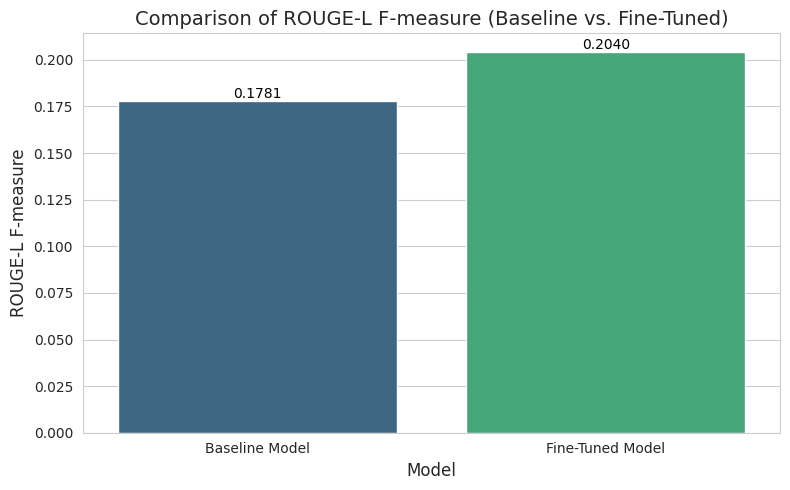

/tmp/ipython-input-1812044050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data['Model'], y=plot_data['Score'], palette='viridis')


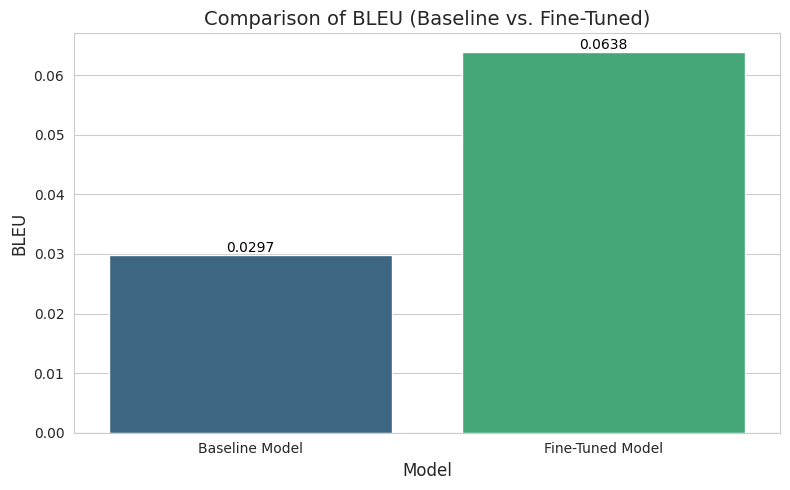

/tmp/ipython-input-1812044050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data['Model'], y=plot_data['Score'], palette='viridis')


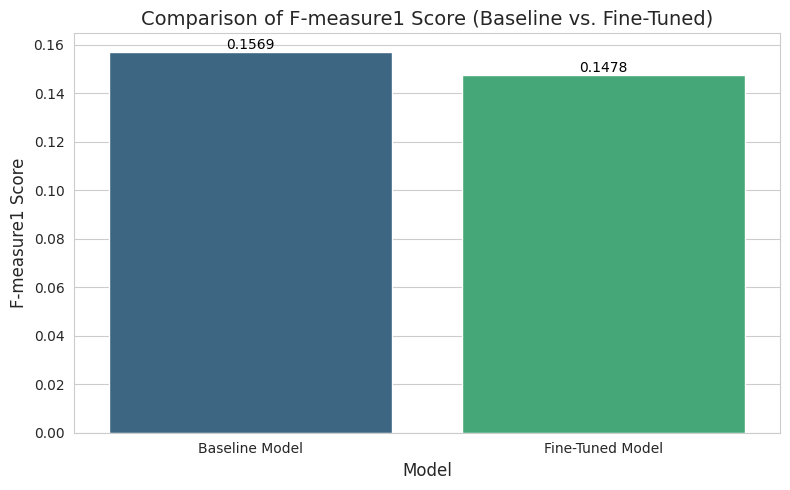

/tmp/ipython-input-1812044050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data['Model'], y=plot_data['Score'], palette='viridis')


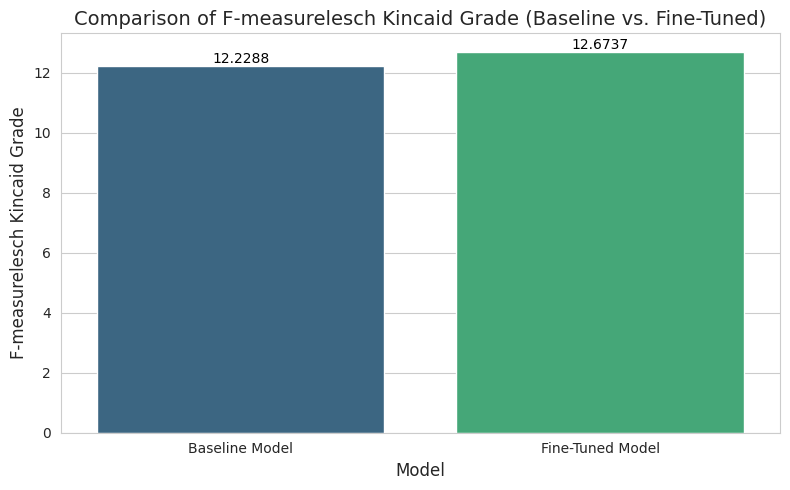

/tmp/ipython-input-1812044050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data['Model'], y=plot_data['Score'], palette='viridis')


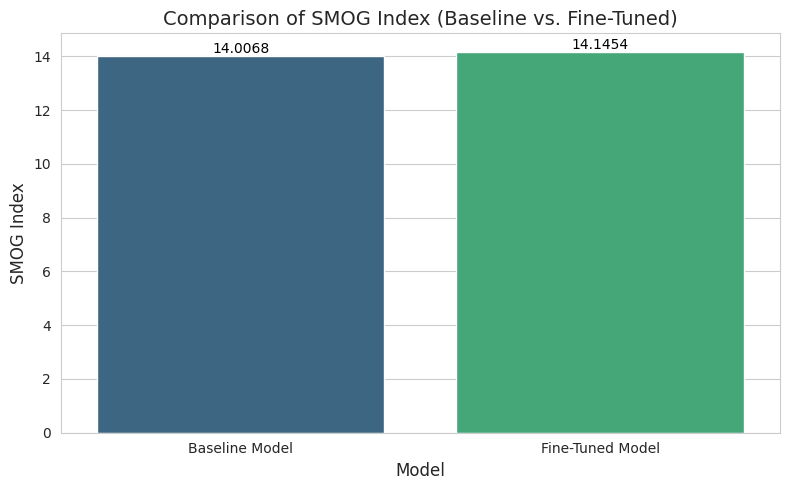

All requested metric comparison plots have been generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas to ensure comparison_df is accessible

# Ensure comparison_df is available
# If running this cell independently, uncomment and load them:
# baseline_metrics_df = pd.read_pickle("baseline_metrics.pkl")
# fine_tuned_metrics_df = pd.read_pickle("fine_tuned_metrics.pkl")
#
# metrics_columns = [
#     'ROUGE-1_F',
#     'ROUGE-2_F',
#     'ROUGE-L_F',
#     'BLEU',
#     'Exact_Match',
#     'F1_Score',
#     'Flesch_Kincaid_Grade',
#     'SMOG_Index'
# ]
# baseline_aggregated_metrics = baseline_metrics_df[metrics_columns].mean().to_frame(name='Baseline Model')
# fine_tuned_aggregated_metrics = fine_tuned_metrics_df[metrics_columns].mean().to_frame(name='Fine-Tuned Model')
# comparison_df = pd.concat([baseline_aggregated_metrics, fine_tuned_aggregated_metrics], axis=1)


# Define the metrics to visualize
metrics_to_visualize = ['ROUGE-L_F', 'BLEU', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']

# Set a style for the plots
sns.set_style("whitegrid")

print("Generating comparison plots for key metrics...")

for metric in metrics_to_visualize:
    plt.figure(figsize=(8, 5))

    # Prepare data for plotting
    plot_data = comparison_df.loc[metric].reset_index()
    plot_data.columns = ['Model', 'Score']

    # Create a bar plot
    sns.barplot(x=plot_data['Model'], y=plot_data['Score'], palette='viridis')

    # Set title and labels
    plt.title(f'Comparison of {metric.replace("_", " ").replace("F", "F-measure")} (Baseline vs. Fine-Tuned)', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(metric.replace("_", " ").replace("F", "F-measure"), fontsize=12)

    # Add value labels on top of bars
    for index, row in plot_data.iterrows():
        plt.text(row.name, row.Score, f'{row.Score:.4f}', color='black', ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

print("All requested metric comparison plots have been generated.")

## Visualize the training logs



In [ ]:
import json
import os
import glob

# Define the OUTPUT_DIR based on previous cells
OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp1/Exp_002"

# Initialize variables
trainer_state = None
trainer_state_file_path = None

try:
    # 1. First, check if trainer_state.json exists directly in the OUTPUT_DIR
    direct_path = os.path.join(OUTPUT_DIR, "trainer_state.json")
    if os.path.exists(direct_path):
        trainer_state_file_path = direct_path
        print(f"Found trainer_state.json directly in: {trainer_state_file_path}")
    else:
        # 2. If not found, use glob.glob to find all subdirectories matching checkpoint-* within OUTPUT_DIR
        checkpoint_dirs = glob.glob(os.path.join(OUTPUT_DIR, "checkpoint-*"))
        if checkpoint_dirs:
            # Sort checkpoint directories numerically to find the latest one
            # Example: checkpoint-100, checkpoint-500, checkpoint-900
            checkpoint_dirs.sort(key=lambda x: int(os.path.basename(x).replace('checkpoint-', '')))

            # Iterate from latest to earliest checkpoint
            for cp_dir in reversed(checkpoint_dirs):
                candidate_path = os.path.join(cp_dir, "trainer_state.json")
                if os.path.exists(candidate_path):
                    trainer_state_file_path = candidate_path
                    print(f"Found trainer_state.json in checkpoint: {trainer_state_file_path}")
                    break # Found the file, no need to check older checkpoints

    if trainer_state_file_path:
        # If trainer_state.json is successfully located:
        with open(trainer_state_file_path, 'r') as f:
            trainer_state = json.load(f)
        print(f"Successfully loaded trainer_state.json from {trainer_state_file_path}")
        # Display some keys to verify and total number of log history entries
        print("Keys in trainer_state:", trainer_state.keys())
        if 'log_history' in trainer_state:
            print(f"Total log history entries: {len(trainer_state['log_history'])}")
        else:
            print("No 'log_history' found in trainer_state.")
    else:
        # If trainer_state.json could not be located after checking all potential paths
        print(f"Error: trainer_state.json not found in {OUTPUT_DIR} or any of its checkpoint subdirectories.")

except FileNotFoundError:
    print(f"Error: File not found at {trainer_state_file_path if trainer_state_file_path else 'specified path'}")
    trainer_state = None
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {trainer_state_file_path}. File might be corrupted.")
    trainer_state = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    trainer_state = None

Found trainer_state.json in checkpoint: /content/drive/MyDrive/llm_experiments exp1/Exp_002/checkpoint-908/trainer_state.json
Successfully loaded trainer_state.json from /content/drive/MyDrive/llm_experiments exp1/Exp_002/checkpoint-908/trainer_state.json
Keys in trainer_state: dict_keys(['best_global_step', 'best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])
Total log history entries: 18


### Extract and Plot Training Loss


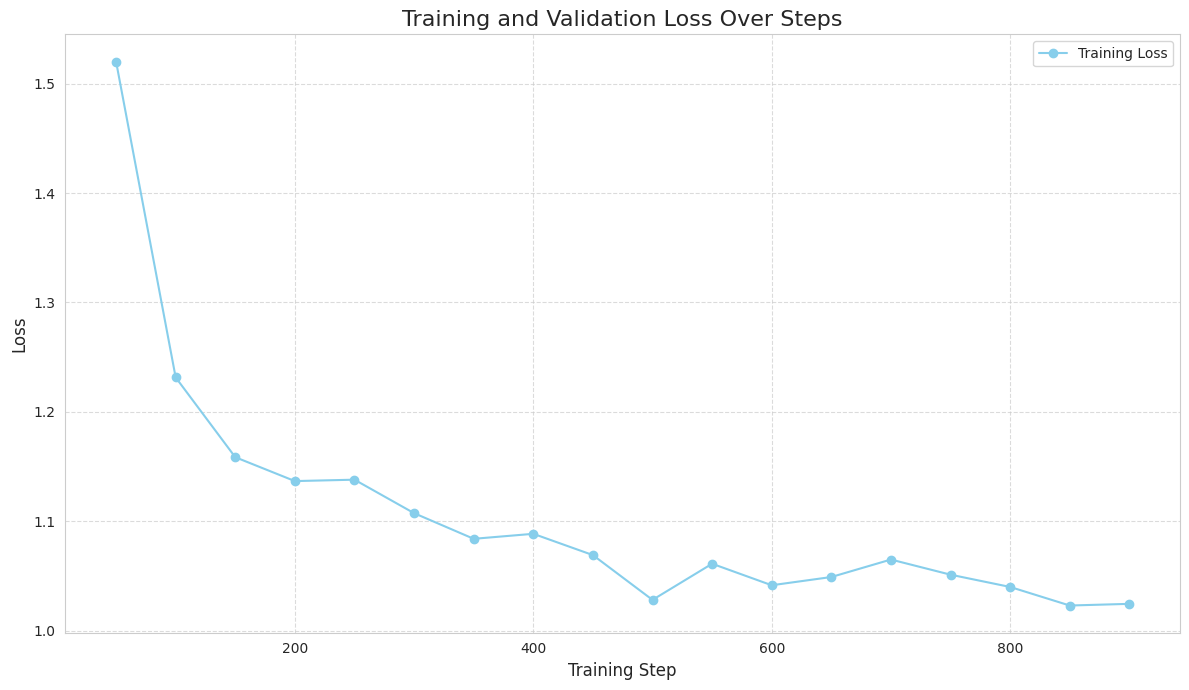

In [ ]:
import matplotlib.pyplot as plt

# 1. Check if trainer_state is available and contains a log_history key
if trainer_state and 'log_history' in trainer_state:
    # 2. Iterate through the log_history list and extract loss and step
    train_losses = []
    train_steps = []
    eval_losses = []
    eval_steps = []

    for log_entry in trainer_state['log_history']:
        # Collect training loss data
        if 'loss' in log_entry and 'step' in log_entry:
            train_losses.append(log_entry['loss'])
            train_steps.append(log_entry['step'])
        # Collect evaluation loss data
        if 'eval_loss' in log_entry and 'step' in log_entry:
            eval_losses.append(log_entry['eval_loss'])
            eval_steps.append(log_entry['step'])

    if not train_losses and not eval_losses:
        print("No training or evaluation loss data found in log_history.")
    else:
        # 3. Create a line plot
        plt.figure(figsize=(12, 7))
        if train_losses:
            plt.plot(train_steps, train_losses, marker='o', linestyle='-', color='skyblue', label='Training Loss')
        if eval_losses:
            plt.plot(eval_steps, eval_losses, marker='x', linestyle='--', color='orange', label='Validation Loss')

        # 4. Add a title to the plot
        plt.title('Training and Validation Loss Over Steps', fontsize=16)

        # 5. Add labels for the x and y axes
        plt.xlabel('Training Step', fontsize=12)
        plt.ylabel('Loss', fontsize=12)

        # Add grid and legend for better readability
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

        # 6. Display the plot
        plt.tight_layout()
        plt.show()
else:
    print("trainer_state or log_history not found. Cannot plot training/validation loss.")

## Gradio Interface

In [ ]:
import torch
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# 2. Define the base model name
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# 3. Define the path to the saved LoRA adapters
# The OUTPUT_DIR from previous cells is '/content/drive/MyDrive/llm_experiments exp1/Exp_002'
output_adapter_dir = os.path.join("/content/drive/MyDrive/llm_experiments exp1/Exp_002", "lora_adapters")

# 4. Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# 5. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
print("Tokenizer loaded and configured.")

# 6. Load the base model
print(f"Loading base model: {base_model_name}")
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
)

# 7. Load the PEFT adapters on top of the base model
print(f"Loading PEFT adapters from: {output_adapter_dir}")
try:
    fine_tuned_model = PeftModel.from_pretrained(model, output_adapter_dir)
    print("Fine-tuned model (base + PEFT adapters) loaded successfully.")
except Exception as e:
    print(f"Error loading PEFT adapters: {e}")
    print("Proceeding with base model only. Please ensure the adapter path is correct.")
    fine_tuned_model = model

# 8. Set the combined fine-tuned model to evaluation mode
fine_tuned_model.eval()
print("Model set to evaluation mode.")

Using device for model loading: cuda
Tokenizer loaded and configured.
Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading PEFT adapters from: /content/drive/MyDrive/llm_experiments exp1/Exp_002/lora_adapters
Fine-tuned model (base + PEFT adapters) loaded successfully.
Model set to evaluation mode.


### Create and Launch Gradio Interface


In [ ]:
import torch
import pandas as pd
import os
import datetime

# Define a path for the log file within your Google Drive folder
# Make sure OUTPUT_DIR is defined from previous steps (e.g., '/content/drive/MyDrive/llm_experiments exp1/Exp_002')
LOG_FILE_PATH = os.path.join(OUTPUT_DIR, "gradio_interactions_log.csv")

def generate_response_gradio(instruction, temperature=0.7, top_k=50, top_p=0.95, repetition_penalty=1.2):
    """
    Generates a response from the fine-tuned model for a given instruction,
    formatted for a Gradio interface, with improved sampling parameters.
    Also logs the interaction.
    """
    # 1. Construct the prompt
    prompt = f"""### Instruction:\n{instruction}\n\n### Response:"""

    # 2. Tokenize the instruction prompt
    encoded_input = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        return_attention_mask=True
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # 3. Generate response using the fine-tuned model with sampling parameters
    with torch.no_grad():
        output_ids = fine_tuned_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=256,
            do_sample=True, # Set to True for sampling
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            pad_token_id=tokenizer.eos_token_id
        )

    # 4. Decode the generated output, skipping the input prompt tokens and special tokens
    current_input_len = (input_ids[0] != tokenizer.pad_token_id).sum().item()
    generated_text = tokenizer.decode(output_ids[0][current_input_len:], skip_special_tokens=True).strip()

    # 5. Log the interaction to a CSV file
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    log_entry = {
        'timestamp': timestamp,
        'instruction': instruction,
        'generated_response': generated_text,
        'temperature': temperature,
        'top_k': top_k,
        'top_p': top_p,
        'repetition_penalty': repetition_penalty
    }

    # Check if file exists to write header only once
    if not os.path.exists(LOG_FILE_PATH):
        pd.DataFrame([log_entry]).to_csv(LOG_FILE_PATH, mode='w', header=True, index=False)
    else:
        pd.DataFrame([log_entry]).to_csv(LOG_FILE_PATH, mode='a', header=False, index=False)
    print(f"Interaction logged to {LOG_FILE_PATH}")

    return generated_text

print("Gradio inference function `generate_response_gradio` updated with sampling parameters and logging successfully.")

Gradio inference function `generate_response_gradio` updated with sampling parameters and logging successfully.


In [ ]:
import gradio as gr

# Create the Gradio Interface with updated parameters for the inference function
# The Gradio interface needs to be re-initialized to use the updated generate_response_gradio function
iface = gr.Interface(
    fn=generate_response_gradio, # This now includes the sampling parameters and logging
    inputs=[
        gr.Textbox(lines=5, label="Your Instruction", placeholder="Enter your medical question here..."),
        gr.Slider(minimum=0.1, maximum=1.0, value=0.7, step=0.05, label="Temperature", interactive=True, info="Controls the randomness of the response. Higher values lead to more creative but potentially less coherent text."),
        gr.Slider(minimum=10, maximum=100, value=50, step=1, label="Top-K", interactive=True, info="Limits the model to consider only the top K most likely words at each step. Lower K makes responses more focused."),
        gr.Slider(minimum=0.5, maximum=1.0, value=0.95, step=0.01, label="Top-P", interactive=True, info="Selects words based on a cumulative probability cutoff. Helps to avoid very unlikely words while still offering diversity."),
        gr.Slider(minimum=1.0, maximum=2.0, value=1.2, step=0.05, label="Repetition Penalty", interactive=True, info="Discourages the model from repeating words or phrases to make the output more varied.")
    ],
    outputs=gr.Textbox(lines=15, label="Generated Response"),
    title="Medical QA Chatbot Exp 1(Fine-Tuned TinyLlama) with Sampling Controls and Logging",
    description="Enter a medical question, adjust sampling parameters, and interactions will be logged.",
    examples=[
        ["What are the symptoms of diabetes?", 0.7, 50, 0.95, 1.2],
        ["How is high blood pressure treated?", 0.7, 50, 0.95, 1.2]
    ]
)

# Launch the interface
print("Relaunching Gradio interface with new sampling controls and logging...")
iface.launch()
print("Gradio interface relaunched successfully.")

Relaunching Gradio interface with new sampling controls and logging...
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da36155984ccbe434b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Gradio interface relaunched successfully.


## Committing and building UI on hugging face space

In [ ]:
from huggingface_hub import notebook_login

notebook_login()
print("Hugging Face Hub login initiated. Please enter your token in the prompt above.")

Hugging Face Hub login initiated. Please enter your token in the prompt above.


### Push Exp_002 LoRA Adapters to Hugging Face Hub


In [ ]:
import os

# 1. Define the output_adapter_dir variable
output_adapter_dir = "/content/drive/MyDrive/llm_experiments exp1/Exp_002/lora_adapters"

# 2. Define a Hugging Face repository ID for the LoRA adapters
hub_repo_id = "Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001"

# 3. Call the push_to_hub method on the fine_tuned_model object
# This will push the PEFT adapters to the specified repository.
# The 'token' argument will use the authenticated Hugging Face token from notebook_login().
print(f"Attempting to push LoRA adapters to Hugging Face Hub: {hub_repo_id}")

try:
    fine_tuned_model.push_to_hub(hub_repo_id, token=True, commit_message="Upload LoRA adapters for Exp_002")
    print(f"Successfully pushed LoRA adapters for Exp_002 to Hugging Face Hub: {hub_repo_id}")
except Exception as e:
    print(f"Error pushing LoRA adapters to Hugging Face Hub: {e}")
    print("Please ensure you have authenticated with `notebook_login()` and have write access to the repository.")

Attempting to push LoRA adapters to Hugging Face Hub: Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   2%|2         |  560kB / 25.3MB            

Successfully pushed LoRA adapters for Exp_002 to Hugging Face Hub: Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001


### Merge Exp_002 LoRA Adapters and Push Full Model

In [ ]:
import torch
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Define constants
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
output_adapter_dir = "/content/drive/MyDrive/llm_experiments exp1/Exp_002/lora_adapters"

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model operations: {device}")

# 1. Load the base model
print(f"Loading base model: {base_model_name}")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32, # Use torch_dtype here
    device_map="auto",
)

# Load the tokenizer (ensuring it's the one used for training and has pad_token)
tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
print("Tokenizer loaded and configured.")

# 2. Load the PEFT adapters onto the base model
print(f"Loading PEFT adapters from: {output_adapter_dir}")
peft_model = PeftModel.from_pretrained(base_model, output_adapter_dir)
print("PEFT adapters loaded successfully.")

# 3. Merge the loaded PEFT adapters into the base model
print("Merging PEFT adapters into the base model...")
merged_model = peft_model.merge_and_unload()
print("PEFT adapters merged successfully into the base model.")

# Set model to evaluation mode
merged_model.eval()

# 4. Define a new Hugging Face repository ID for the merged model
hub_repo_id = "Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002"

# 5. Push the merged model to the Hugging Face Hub
print(f"Attempting to push merged model to Hugging Face Hub: {hub_repo_id}")
try:
    merged_model.push_to_hub(hub_repo_id, token=True, commit_message="Merged fine-tuned TinyLlama model with Exp_002 adapters")
    print(f"Successfully pushed merged model to Hugging Face Hub: {hub_repo_id}")
except Exception as e:
    print(f"Error pushing merged model to Hugging Face Hub: {e}")
    print("Please ensure you have authenticated with `notebook_login()` and have write access to the repository.")

# 6. Push the tokenizer to the same Hugging Face repository
print(f"Attempting to push tokenizer to Hugging Face Hub: {hub_repo_id}")
try:
    tokenizer.push_to_hub(hub_repo_id, token=True, commit_message="Tokenizer for fine-tuned TinyLlama model with Exp_002 adapters")
    print(f"Successfully pushed tokenizer to Hugging Face Hub: {hub_repo_id}")
except Exception as e:
    print(f"Error pushing tokenizer to Hugging Face Hub: {e}")
    print("Please ensure you have authenticated with `notebook_login()` and have write access to the repository.")

Using device for model operations: cuda
Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Tokenizer loaded and configured.
Loading PEFT adapters from: /content/drive/MyDrive/llm_experiments exp1/Exp_002/lora_adapters
PEFT adapters loaded successfully.
Merging PEFT adapters into the base model...
PEFT adapters merged successfully into the base model.
Attempting to push merged model to Hugging Face Hub: Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...lsgb7z5/model.safetensors:   2%|1         | 41.9MB / 2.20GB            

Successfully pushed merged model to Hugging Face Hub: Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002
Attempting to push tokenizer to Hugging Face Hub: Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002


README.md: 0.00B [00:00, ?B/s]

Successfully pushed tokenizer to Hugging Face Hub: Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002


## Create Hugging Face Space for Gradio Demo (Exp_002)


In [ ]:
import os

# 1. Define a deployment directory and create it
DEPLOY_DIR = "/content/merged_model_for_hf_space"
os.makedirs(DEPLOY_DIR, exist_ok=True)
print(f"Deployment directory created at: {DEPLOY_DIR}")

# 2. Define a Hugging Face repository ID for the new Gradio Space
hub_space_id = "Jeanrobert/tinyllama-medqa-gradio-demo-exp002"
print(f"Hugging Face Space ID: {hub_space_id}")

Deployment directory created at: /content/merged_model_for_hf_space
Hugging Face Space ID: Jeanrobert/tinyllama-medqa-gradio-demo-exp002


In [ ]:
import os

# Define .gitattributes content
gitattributes_content = '''
*.safetensors filter=lfs diff=lfs merge=lfs -text
'''

# Save .gitattributes to the deployment directory
gitattributes_path = os.path.join(DEPLOY_DIR, ".gitattributes")
with open(gitattributes_path, "w") as f:
    f.write(gitattributes_content)
print(f"Created .gitattributes at: {gitattributes_path}")

Created .gitattributes at: /content/merged_model_for_hf_space/.gitattributes


In [ ]:
import os

# Ensure merged_model and tokenizer are available from previous cells.

# Save the merged model to the deployment directory
print(f"Saving merged model to {DEPLOY_DIR}...")
merged_model.save_pretrained(DEPLOY_DIR)
print("Merged model saved successfully.")

# Save the tokenizer to the deployment directory
print(f"Saving tokenizer to {DEPLOY_DIR}...")
tokenizer.save_pretrained(DEPLOY_DIR)
print("Tokenizer saved successfully.")

Saving merged model to /content/merged_model_for_hf_space...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Merged model saved successfully.
Saving tokenizer to /content/merged_model_for_hf_space...
Tokenizer saved successfully.


In [ ]:
from google.colab import userdata
import os

# Retrieve the Hugging Face token from Colab Secrets
try:
    hf_token = userdata.get('HF_TOKEN')
    os.environ['HF_TOKEN'] = hf_token
    print("Hugging Face token retrieved from Colab Secrets and set as HF_TOKEN environment variable.")
except userdata.SecretError:
    print("Error: HF_TOKEN secret not found in Colab. Please add it to Colab Secrets.")
except Exception as e:
    print(f"An unexpected error occurred while retrieving the token: {e}")

# Verify that the token is set (it will only print if set)
if os.environ.get('HF_TOKEN'):
    print("HF_TOKEN environment variable is now set.")
else:
    print("HF_TOKEN environment variable is still not set. Please check Colab Secrets configuration.")

Hugging Face token retrieved from Colab Secrets and set as HF_TOKEN environment variable.
HF_TOKEN environment variable is now set.


In [ ]:
import os

# Define the deployment directory (as used in previous cells)
DEPLOY_DIR = "/content/merged_model_for_hf_space"

# Define README.md content with SDK configuration
readme_content = '''
---
title: Medical QA Chatbot (Fine-Tuned TinyLlama)
emoji: 🤖
colorFrom: green
colorTo: indigo
sdk: gradio
app_file: app.py
---

# Medical QA Chatbot

This Hugging Face Space hosts a fine-tuned TinyLlama-1.1B-Chat-v1.0 model for medical Question Answering, equipped with interactive sampling controls.

## Model Details
- **Base Model**: TinyLlama/TinyLlama-1.1B-Chat-v1.0
- **Fine-tuned with**: LoRA adapters on AfrimedQA and MedQuAD datasets.
- **Hugging Face LoRA Adapters**: [Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001](https://huggingface.co/Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001)
- **Hugging Face Merged Model**: [Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002](https://huggingface.co/Jeanrobert/tinyllama-1.1b-chat-v1-finetuned-afrimedqa-exp002)

## How to Use
Enter a medical question in the input box, adjust the generation parameters (Temperature, Top-K, Top-P, Repetition Penalty) to control the response, and see the model's output.

## Parameters
- **Temperature**: Controls randomness. Higher values = more creative, potentially less coherent.
- **Top-K**: Limits word choices to the top K most likely.
- **Top-P**: Limits word choices based on cumulative probability.
- **Repetition Penalty**: Discourages the model from repeating words.

'''

# Save README.md to the deployment directory
readme_path = os.path.join(DEPLOY_DIR, "README.md")
with open(readme_path, "w") as f:
    f.write(readme_content)
print(f"Created README.md at: {readme_path}")


Created README.md at: /content/merged_model_for_hf_space/README.md


In [ ]:
import os

# Define the deployment directory (must be consistent with other deployment cells)
DEPLOY_DIR = "/content/merged_model_for_hf_space"

# Ensure DEPLOY_DIR exists
os.makedirs(DEPLOY_DIR, exist_ok=True)

# Define refined requirements.txt content for multi-adapter system
requirements_content = '''
torch>=2.0.0
transformers>=4.36.0
peft>=0.7.0
accelerate>=0.25.0
gradio>=4.0.0
huggingface_hub>=0.20.0
pandas>=1.5.0
safetensors>=0.4.0
bitsandbytes>=0.46.1
'''

# Save requirements.txt to the deployment directory
requirements_path = os.path.join(DEPLOY_DIR, "requirements.txt")
with open(requirements_path, "w") as f:
    f.write(requirements_content)

print(f"Created requirements.txt at: {requirements_path}")

Created requirements.txt at: /content/merged_model_for_hf_space/requirements.txt


In [ ]:
import os
import datetime

# Ensure DEPLOY_DIR is defined
DEPLOY_DIR = "/content/merged_model_for_hf_space"
os.makedirs(DEPLOY_DIR, exist_ok=True) # Ensure the directory exists

# Re-create app.py content to exactly match the multi-adapter logic from JqICogygfQb7
# Add a unique comment to force detection of file change
app_py_content = f'''
# Last updated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
import gradio as gr
import torch
import os
import pandas as pd
import datetime
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# =========================
# CONFIGURATION
# =========================

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

ADAPTER_REPOS = {{
    "MedQA (Exp001)": "Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001",
    "MedQA (Exp002)": "Jeanrobert/tinyllama-medqa-exp002-lora-adapters",
    "MedQA (Exp003)": "Jeanrobert/tinyllama-medqa-exp003",
    "MedQA (Exp004)": "Jeanrobert/TinyLlama-1.1B-Chat-v1.0-Exp_004" # Updated with Exp004
}}

LOG_FILE_PATH = "/data/gradio_interactions_log.csv" # Changed path to /data for persistence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading model on device: {{device}}")

# =========================
# LOAD TOKENIZER
# =========================

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, padding_side="left")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({{'pad_token': tokenizer.eos_token}})

# =========================
# LOAD BASE MODEL
# =========================

quantization_config = None
if torch.cuda.is_available():
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )

# Load base model to CPU initially, without device_map="auto", then move after PEFT
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    # device_map="cpu" # Explicitly load to CPU to avoid accelerate offload issues
)

# =========================
# LOAD FIRST ADAPTER
# =========================

first_adapter_name = list(ADAPTER_REPOS.keys())[0]
first_adapter_repo = ADAPTER_REPOS[first_adapter_name]

# Apply PEFT adapters and then move the entire model to device
model = PeftModel.from_pretrained(
    base_model,
    first_adapter_repo,
    adapter_name="exp001"
).to(device) # Move the entire PEFT model to device after creation

# =========================
# LOAD REMAINING ADAPTERS
# =========================

adapter_keys = list(ADAPTER_REPOS.keys())
internal_adapter_names = ["exp001", "exp002", "exp003", "exp004"]

for display_name, internal_name in zip(adapter_keys[1:], internal_adapter_names[1:]):
    repo = ADAPTER_REPOS[display_name]
    if repo is not None:
        model.load_adapter(repo, adapter_name=internal_name)

model.eval()
torch.set_grad_enabled(False)

print("Base model and adapters loaded successfully.")

# =========================
# GENERATION FUNCTION
# =========================

def generate_response_gradio(
    adapter_choice,
    instruction,
    temperature=0.7,
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.2
):

    if ADAPTER_REPOS[adapter_choice] is None:
        return "This model is not yet available."

    # Map display name to internal adapter name
    adapter_index = list(ADAPTER_REPOS.keys()).index(adapter_choice)
    adapter_internal = internal_adapter_names[adapter_index]

    model.set_adapter(adapter_internal)

    prompt = f"""### Instruction:\n{{instruction}}\n\n### Response:"""

    encoded_input = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        return_attention_mask=True
    )

    input_ids = encoded_input["input_ids"].to(device)
    attention_mask = encoded_input["attention_mask"].to(device)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=200,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            pad_token_id=tokenizer.eos_token_id
        )

    current_input_len = (input_ids[0] != tokenizer.pad_token_id).sum().item()
    generated_text = tokenizer.decode(
        output_ids[0][current_input_len:],
        skip_special_tokens=True
    ).strip()

    # =========================
    # LOGGING
    # =========================
    print(f"DEBUG: Attempting to log interaction. LOG_FILE_PATH: {{LOG_FILE_PATH}}")
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    log_entry = {{
        "timestamp": timestamp,
        "adapter": adapter_choice,
        "instruction": instruction,
        "generated_response": generated_text,
        "temperature": temperature,
        "top_k": top_k,
        "top_p": top_p,
        "repetition_penalty": repetition_penalty
    }}

    # Ensure the directory for the log file exists
    log_dir = os.path.dirname(LOG_FILE_PATH)
    print(f"DEBUG: Checking/creating log directory: {{log_dir}}")
    os.makedirs(log_dir, exist_ok=True)
    print(f"DEBUG: Log directory {{'exists' if os.path.exists(log_dir) else 'created'}}.")


    if not os.path.exists(LOG_FILE_PATH):
        print(f"DEBUG: Log file does not exist. Creating new file at {{LOG_FILE_PATH}}")
        pd.DataFrame([log_entry]).to_csv(LOG_FILE_PATH, mode="w", header=True, index=False)
    else:
        print(f"DEBUG: Log file exists. Appending to file at {{LOG_FILE_PATH}}")
        pd.DataFrame([log_entry]).to_csv(LOG_FILE_PATH, mode="a", header=False, index=False)
    print(f"DEBUG: Log attempt complete.")

    return generated_text


# =========================
# GRADIO UI
# =========================

iface = gr.Interface(
    fn=generate_response_gradio,
    inputs=[
        gr.Dropdown(
            choices=list(ADAPTER_REPOS.keys()),
            value=list(ADAPTER_REPOS.keys())[0],
            label="Select Model"
        ),
        gr.Textbox(lines=5, label="Your Instruction"),
        gr.Slider(0.1, 1.0, value=0.7, step=0.05, label="Temperature", info="Controls the randomness of the response. Higher values lead to more creative but potentially less coherent text."),
        gr.Slider(10, 100, value=50, step=1, label="Top-K", info="Limits the model to consider only the top K most likely words at each step. Lower K makes responses more focused."),
        gr.Slider(0.5, 1.0, value=0.95, step=0.01, label="Top-P", interactive=True, info="Selects words based on a cumulative probability cutoff. Helps to avoid very unlikely words while still offering diversity."),
        gr.Slider(1.0, 2.0, value=1.2, step=0.05, label="Repetition Penalty", interactive=True, info="Discourages the model from repeating words or phrases to make the output more varied.")
    ],
    outputs=gr.Textbox(lines=15, label="Generated Response"),
    title="Multi-Adapter TinyLlama Medical QA ChatBot",
    description="Select an experiment adapter and generate responses using TinyLlama + LoRA routing.",
    examples=[
        ["MedQA (Exp001)", "What are the symptoms of diabetes?", 0.7, 50, 0.95, 1.2], # Corrected example
        ["MedQA (Exp001)", "How is high blood pressure treated?", 0.7, 50, 0.95, 1.2], # Corrected example
        ["MedQA (Exp004)", "What is the prognosis for stage 4 cancer?", 0.7, 50, 0.95, 1.2] # Added Exp004 example
    ]
)

iface.launch(share=False)
'''

app_py_path = os.path.join(DEPLOY_DIR, "app.py")
with open(app_py_path, "w") as f:
    f.write(app_py_content)

print(f"Created app.py at: {app_py_path}")
print(f"\n--- Content of {app_py_path} (for verification) ---\n{app_py_content}")

Created app.py at: /content/merged_model_for_hf_space/app.py

--- Content of /content/merged_model_for_hf_space/app.py (for verification) ---

# Last updated: 2026-02-18 07:49:20
import gradio as gr
import torch
import os
import pandas as pd
import datetime
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# =========================
# CONFIGURATION
# =========================

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

ADAPTER_REPOS = {
    "MedQA (Exp001)": "Jeanrobert/tinyllama-1.1b-chat-v1-lora-afrimedqa-exp001",
    "MedQA (Exp002)": "Jeanrobert/tinyllama-medqa-exp002-lora-adapters",
    "MedQA (Exp003)": "Jeanrobert/tinyllama-medqa-exp003",
    "MedQA (Exp004)": "Jeanrobert/TinyLlama-1.1B-Chat-v1.0-Exp_004" # Updated with Exp004
}

LOG_FILE_PATH = "/data/gradio_interactions_log.csv" # Changed path to /data for persistence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading model 

In [ ]:
from huggingface_hub import HfApi, create_repo, upload_folder
import os
from google.colab import userdata # Import userdata to retrieve token directly

# Ensure DEPLOY_DIR and hub_space_id are available from previous cells
DEPLOY_DIR = "/content/merged_model_for_hf_space"
hub_space_id = "Jeanrobert/tinyllama-medqa-gradio-demo-exp002"

# Explicitly retrieve and set the Hugging Face token
try:
    hf_token = userdata.get('HF_TOKEN')
    os.environ['HF_TOKEN'] = hf_token
    print("Hugging Face token retrieved from Colab Secrets and set as HF_TOKEN environment variable.")
except userdata.SecretError:
    print("Error: HF_TOKEN secret not found in Colab. Please add it to Colab Secrets.")
    hf_token = None
except Exception as e:
    print(f"An unexpected error occurred while retrieving the token: {e}")
    hf_token = None

if hf_token is None:
    print("Hugging Face token not found. Please ensure it is correctly set in Colab Secrets and `notebook_login()` was successful.")
else:
    api = HfApi(token=hf_token)

    print(f"Creating Hugging Face Space repository: {hub_space_id}...")
    try:
        # Create the repository with type 'space'
        create_repo(repo_id=hub_space_id, repo_type="space", space_sdk="gradio", token=hf_token, exist_ok=True)
        print(f"Repository {hub_space_id} created or already exists.")

        print(f"Uploading contents of {DEPLOY_DIR} to {hub_space_id}...")
        # Upload the entire folder
        upload_folder(
            repo_id=hub_space_id,
            repo_type="space",
            folder_path=DEPLOY_DIR,
            path_in_repo=".", # Upload to the root of the Space
            token=hf_token
        )
        print(f"Successfully uploaded all files to Hugging Face Space: https://huggingface.co/spaces/{hub_space_id}")
    except Exception as e:
        print(f"Error pushing to Hugging Face Space: {e}")
        print("Please ensure you have write access to the repository.")

Hugging Face token retrieved from Colab Secrets and set as HF_TOKEN environment variable.
Creating Hugging Face Space repository: Jeanrobert/tinyllama-medqa-gradio-demo-exp002...
Repository Jeanrobert/tinyllama-medqa-gradio-demo-exp002 created or already exists.
Uploading contents of /content/merged_model_for_hf_space to Jeanrobert/tinyllama-medqa-gradio-demo-exp002...
Successfully uploaded all files to Hugging Face Space: https://huggingface.co/spaces/Jeanrobert/tinyllama-medqa-gradio-demo-exp002


## Table

In [ ]:
import subprocess
import sys
import numpy as np
import pandas as pd
import os
import re
import string

# Install missing libraries if not already present
try:
    import rouge_score
except ImportError:
    print("rouge_score not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge-score"])
    print("rouge_score installed successfully.")
from rouge_score import rouge_scorer

try:
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("NLTK 'punkt' tokenizer not found, downloading...")
        nltk.download('punkt')
        print("NLTK 'punkt' downloaded successfully.")
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        print("NLTK 'punkt_tab' tokenizer not found, downloading...")
        nltk.download('punkt_tab')
        print("NLTK 'punkt_tab' downloaded successfully.")
except ImportError:
    print("NLTK not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    print("NLTK installed successfully. Downloading 'punkt' and 'punkt_tab'...")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    print("NLTK 'punkt' and 'punkt_tab' downloaded successfully.")

try:
    import textstat
except ImportError:
    print("textstat not found, installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "textstat"])
    print("textstat installed successfully.")

# --- Helper Functions for Metrics (re-included for self-containment) ---

def calculate_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    if not tokenized_hypothesis:
        return 0.0
    return sentence_bleu(tokenized_reference, tokenized_hypothesis)

def calculate_exact_match(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()
    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()

    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)

    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0

    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)

    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    try:
        flesch_kincaid = textstat.flesch_kincaid_grade(text)
    except Exception:
        flesch_kincaid = 0.0 # Default value if calculation fails
    try:
        smog_index = textstat.smog_index(text)
    except Exception:
        smog_index = 0.0 # Default value if calculation fails

    return {
        'flesch_kincaid_grade': flesch_kincaid,
        'smog_index': smog_index
    }

# Define paths for the saved dataframes (consistent with previous cells)
baseline_responses_df_path = "baseline_responses.pkl"
# Use the found_path from the previous cell, or the explicitly corrected path
# For self-containment, I'll use the path found in the previous step.
fine_tuned_responses_path = "/content/drive/MyDrive/llm_experiments exp1/Exp_002/fine_tuned_responses.pkl"

# 1. Load baseline_responses_df and calculate baseline_metrics_df
if os.path.exists(baseline_responses_df_path):
    baseline_responses_df = pd.read_pickle(baseline_responses_df_path)
    print(f"Loaded {len(baseline_responses_df)} baseline responses from {baseline_responses_df_path}.")
else:
    raise FileNotFoundError(f"Baseline responses file not found at {baseline_responses_df_path}")

baseline_evaluation_results = []
print("Re-calculating metrics for baseline responses...")

for index, row in baseline_responses_df.iterrows():
    reference = str(row['reference_response'])
    hypothesis = str(row['generated_response'])

    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    baseline_evaluation_results.append({
        'Experiment_ID': 'Baseline_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

baseline_metrics_df = pd.DataFrame(baseline_evaluation_results)
print(f"Re-calculated {len(baseline_metrics_df)} baseline metrics.")

# 2. Load fine_tuned_responses_df and calculate fine_tuned_metrics_df
if os.path.exists(fine_tuned_responses_path):
    fine_tuned_responses_df = pd.read_pickle(fine_tuned_responses_path)
    print(f"Loaded {len(fine_tuned_responses_df)} fine-tuned responses from {fine_tuned_responses_path}.")
else:
    raise FileNotFoundError(f"Fine-tuned responses file not found at {fine_tuned_responses_path}. Please ensure it was generated and saved to the correct path by previous steps.")

fine_tuned_evaluation_results = []
print("Re-calculating metrics for fine-tuned responses...")

for index, row in fine_tuned_responses_df.iterrows():
    reference = str(row['reference_response'])
    hypothesis = str(row['generated_response'])

    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    fine_tuned_evaluation_results.append({
        'Experiment_ID': 'Fine_Tuned_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

fine_tuned_metrics_df = pd.DataFrame(fine_tuned_evaluation_results)
print(f"Re-calculated {len(fine_tuned_metrics_df)} fine-tuned metrics.")

# Define the metrics to aggregate
metrics_columns = [
    'ROUGE-1_F',
    'ROUGE-2_F',
    'ROUGE-L_F',
    'BLEU',
    'Exact_Match',
    'F1_Score',
    'Flesch_Kincaid_Grade',
    'SMOG_Index'
]

# Re-create aggregated metrics and comparison_df
baseline_aggregated_metrics = baseline_metrics_df[metrics_columns].mean().to_frame(name='Baseline Model')
fine_tuned_aggregated_metrics = fine_tuned_metrics_df[metrics_columns].mean().to_frame(name='Fine-Tuned Model')
comparison_df = pd.concat([baseline_aggregated_metrics, fine_tuned_aggregated_metrics], axis=1)

# Calculate percentage improvement
# Handle cases where Baseline Model score might be zero to avoid division by zero errors
comparison_df['Percentage_Improvement'] = comparison_df.apply(
    lambda row:
        ((row['Fine-Tuned Model'] - row['Baseline Model']) / row['Baseline Model'] * 100)
        if row['Baseline Model'] != 0
        else (np.inf if row['Fine-Tuned Model'] > 0 else 0.0), # Infinite improvement if baseline is 0 and fine-tuned > 0
    axis=1
)

# Create the detailed comparison DataFrame
detailed_comparison_df = comparison_df.copy()

# Define a function to apply conditional highlighting
def highlight_improvement(s):
    # This function expects a Series (column) from the DataFrame
    # We need to check if the 'Percentage_Improvement' value for each row in that series meets the criteria.
    # Apply to the 'Percentage_Improvement' column only, based on its values.
    is_positive_improvement = s >= 10
    return ['background-color: lightgreen' if v else '' for v in is_positive_improvement]

# Apply the conditional formatting only to the 'Percentage_Improvement' column
styled_df = detailed_comparison_df.style.apply(highlight_improvement, subset=['Percentage_Improvement'])

print("Detailed Comparison Table with Percentage Improvements and Highlighting:")
display(styled_df)


Loaded 1813 baseline responses from baseline_responses.pkl.
Re-calculating metrics for baseline responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Re-calculated 1813 baseline metrics.
Loaded 1813 fine-tuned responses from /content/drive/MyDrive/llm_experiments exp1/Exp_002/fine_tuned_responses.pkl.
Re-calculating metrics for fine-tuned responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Re-calculated 1813 fine-tuned metrics.
Detailed Comparison Table with Percentage Improvements and Highlighting:


,Baseline Model,Fine-Tuned Model,Percentage_Improvement
ROUGE-1_F,0.285507,0.292888,2.585249
ROUGE-2_F,0.083173,0.122090,46.789702
ROUGE-L_F,0.178051,0.204027,14.589410
BLEU,0.029740,0.063825,114.611896
Exact_Match,0.000000,0.000000,0.000000
F1_Score,0.156921,0.147780,-5.825629
Flesch_Kincaid_Grade,12.228807,12.673676,3.637876
SMOG_Index,14.006848,14.145433,0.989410


# EXP 2


## Implementing Fine-tuning Experiment 1 (Exp_001)
Run the fine-tuning process for Experiment 1 using LoRA with the specified hyperparameters (e.g., learning_rate=2e-4, per_device_train_batch_size=4, gradient_accumulation_steps=8, num_train_epochs=3). During training, rigorously track peak GPU memory usage and total training time. Save the fine-tuned LoRA adapters for this experiment using trainer.model.save_pretrained().


In [ ]:
import time
import torch
import os

# Re-import necessary libraries for the full setup
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import pandas as pd
import kagglehub

print("--- Re-initializing environment for Exp_002 ---")

# --- Start: Re-creating `tokenizer` and `train_val_test_dataset` ---

# 2. Load the TinyLlama tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token

print("Tokenizer loaded and configured.")

# 3. Load intronhealth/afrimedqa_v2 dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')

# 4. Download MedQuAD dataset files and load into pandas DataFrame
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)

# 5. Convert MedQuAD to unified QA format
medquad_qa_df = medquad_df.copy()
medquad_qa_df['instruction'] = medquad_qa_df['question'].astype(str)
medquad_qa_df['response'] = medquad_qa_df['answer'].astype(str)
medquad_qa_dataset = Dataset.from_pandas(medquad_qa_df[['instruction', 'response']])

# 5.1 Convert afrimedqa_v2 to unified QA format
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df['instruction'] = afrimedqa_df['question'].astype(str)
afrimedqa_df['response'] = afrimedqa_df['answer_rationale'].fillna('').astype(str)
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['instruction', 'response']])

# 6. Concatenate unified datasets
unified_dataset = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])

# 7. Clean the unified_dataset
initial_num_rows = len(unified_dataset)
unified_dataset = unified_dataset.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
cleaned_num_rows = len(unified_dataset)
print(f"Removed {initial_num_rows - cleaned_num_rows} entries due to empty instruction or response during dataset cleaning.")

# 8. Split the cleaned unified_dataset into training, validation, and test sets
shuffled_dataset = unified_dataset.shuffle(seed=42)
train_test_split = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_val_test_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})
print("Unified dataset cleaned and split into training, validation, and test sets successfully:")
for split, ds in train_val_test_dataset.items():
    print(f"- {split}: {len(ds)} samples")

# 9. Define and apply format_prompt function
def format_prompt(example):
    instruction = str(example['instruction'])
    response = str(example['response'])
    formatted_text = f"""### Instruction:\n{instruction}\n\n### Response:\n{response}"""
    return {'text': formatted_text}

# Apply the formatting function
formatted_dataset = train_val_test_dataset.map(format_prompt, remove_columns=['instruction', 'response'])

# 10. Define and apply tokenize_function, removing 'text' column
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_dataset = formatted_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
print("Dataset tokenized successfully and 'text' column removed.")

# --- End: Re-creating `tokenizer` and `train_val_test_dataset` ---

# --- Start: Loading base model, LoRA config, PEFT model, and Trainer for Exp_002 ---

# 11. Load the base model with 4-bit quantization fallback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for training (Exp_002): {device}")

model = None
quantization_config = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load model with 4-bit quantization using bitsandbytes.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16, # Use bfloat16 for quantized model on CUDA
            device_map="auto"
        )
        print("Model loaded successfully with 4-bit quantization.")
    except Exception as e: # Catch any exception related to bitsandbytes loading
        print(f"Warning: 4-bit quantization failed ({e}). Falling back to loading model in full bfloat16 precision.")
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading model in full float32 precision.")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 12. Configure LoRA parameters (consistent with Exp_001)
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
print("LoRA configuration defined.")

# 13. Integrate the LoRA configuration with the base model
peft_model = get_peft_model(model, lora_config)
print("\nPEFT model summary for Exp_002:")
peft_model.print_trainable_parameters()

# 14. Initialize the `TrainingArguments` for Exp_002
# Key changes: num_train_epochs removed, max_steps=400, learning_rate=1e-4, optim='adamw_torch'
training_args = TrainingArguments(
    output_dir="./tinyllama_medqa_finetuned_exp002", # New output directory
    max_steps=400, # Set max_steps for Exp_002
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    optim="adamw_torch", # Use adamw_torch as planned
    learning_rate=1e-4, # Learning rate for Exp_002
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    seed=42,
    fp16=False,
    bf16=model.dtype == torch.bfloat16,
    gradient_checkpointing=True,
    report_to="none",
    remove_unused_columns=True, # Keep as True to prevent 'text' column issues
    save_total_limit=2
)
print("TrainingArguments defined for Exp_002.")

# 15. Define the DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
print("DataCollatorForLanguageModeling initialized.")

# 16. Initialize the Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
)
print("\nTrainer initialized successfully for Exp_002.")
print("--- Environment re-initialization for Exp_002 complete ---")

--- Re-initializing environment for Exp_002 ---
Tokenizer loaded and configured.
Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Removed 13565 entries due to empty instruction or response during dataset cleaning.
Unified dataset cleaned and split into training, validation, and test sets successfully:
- train: 14497 samples
- validation: 1812 samples
- test: 1813 samples


Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Dataset tokenized successfully and 'text' column removed.
Using device for training (Exp_002): cuda
Attempting to load model with 4-bit quantization using bitsandbytes.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded successfully with 4-bit quantization.
LoRA configuration defined.

PEFT model summary for Exp_002:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701
TrainingArguments defined for Exp_002.
DataCollatorForLanguageModeling initialized.

Trainer initialized successfully for Exp_002.
--- Environment re-initialization for Exp_002 complete ---


In [ ]:
# --- Start: Execute Fine-tuning Experiment 2 (Exp_002) with Checkpoint Resuming ---

# Experiment 2 parameters for summary printing
EXPERIMENT_ID = "Exp_002"
LEARNING_RATE = "1e-4"
PER_DEVICE_TRAIN_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 8
EFFECTIVE_BATCH_SIZE = PER_DEVICE_TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
MAX_STEPS = 400
OPTIMIZER = "adamw_torch"

# 1. Clear CUDA cache and reset peak memory stats if GPU is available
if torch.cuda.is_available():
    print("CUDA available. Clearing cache and resetting peak memory stats...")
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_gpu_memory_allocated = torch.cuda.memory_allocated()
    print(f"Initial GPU memory allocated: {initial_gpu_memory_allocated / (1024**3):.2f} GB")
else:
    print("CUDA not available. Skipping GPU memory operations.")

# 2. Record start time
start_time = time.time()

# --- 3. Detect latest checkpoint if exists ---
checkpoint_path = None
if os.path.exists(training_args.output_dir):
    checkpoints = [os.path.join(training_args.output_dir, d)
                   for d in os.listdir(training_args.output_dir)
                   if d.startswith("checkpoint")]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
        checkpoint_path = checkpoints[-1]
        print(f"Resuming training from checkpoint: {checkpoint_path}")

# 4. Execute training (resume if checkpoint exists)
print(f"\nStarting training for {EXPERIMENT_ID} for up to {MAX_STEPS} steps...")
trainer.train(resume_from_checkpoint=checkpoint_path)
print(f"\nTraining for {EXPERIMENT_ID} completed.")

# 5. Record end time and calculate total training duration
end_time = time.time()
training_duration_seconds = end_time - start_time
training_duration_hms = time.strftime("%H:%M:%S", time.gmtime(training_duration_seconds))

# 6. Retrieve peak GPU memory allocated during training (if CUDA was available)
peak_gpu_memory_gb = 0.0
if torch.cuda.is_available():
    peak_gpu_memory_bytes = torch.cuda.max_memory_allocated()
    peak_gpu_memory_gb = peak_gpu_memory_bytes / (1024**3)
    print(f"Peak GPU memory allocated: {peak_gpu_memory_gb:.2f} GB")

# 7. Evaluate the fine-tuned model and extract the final validation loss
print("\nEvaluating fine-tuned model on the validation set...")
validation_results = trainer.evaluate()
final_validation_loss = validation_results['eval_loss']
print(f"Final Validation Loss: {final_validation_loss:.4f}")

# 8. Save the fine-tuned LoRA adapters for Exp_002
output_adapter_dir = "./exp_002_lora_adapters"
peft_model.save_pretrained(output_adapter_dir)
print(f"\nFine-tuned LoRA adapters saved to: {output_adapter_dir}")

# 9. Print a summary of the experiment
print("\n--- Experiment Summary (Exp_002) ---")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Per Device Train Batch Size: {PER_DEVICE_TRAIN_BATCH_SIZE}")
print(f"Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")
print(f"Max Steps: {MAX_STEPS}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Peak GPU Memory: {peak_gpu_memory_gb:.2f} GB")
print(f"Training Time: {training_duration_hms}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print("------------------------------------")


CUDA available. Clearing cache and resetting peak memory stats...
Initial GPU memory allocated: 2.58 GB

Starting training for Exp_002 for up to 400 steps...


Step,Training Loss
50,1.144299
100,1.099982
150,1.098760
200,1.067255
250,1.076355
300,1.071821
350,1.076446


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import pandas as pd

# Re-import necessary datasets components
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --- Start: Re-creating `tokenizer` and `dataset` (from cell kckA-5wHW8Ey) ---

# Tokenizer
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
# Set padding_side to 'left' for decoder-only models for correct generation
tokenizer.padding_side = 'left'

# Load Datasets
afrimedqa = load_dataset("intronhealth/afrimedqa_v2")

medquad_path = kagglehub.dataset_download(
    "pythonafroz/medquad-medical-question-answer-for-ai-research"
)
medquad_df = pd.read_csv(os.path.join(medquad_path, "medquad.csv"))

# Normalize QA Format
medquad_ds = Dataset.from_pandas(pd.DataFrame({
    "instruction": medquad_df["question"].astype(str),
    "response": medquad_df["answer"].astype(str)
}))

afrimedqa_df = afrimedqa["train"].to_pandas()
afrimedqa_ds = Dataset.from_pandas(pd.DataFrame({
    "instruction": afrimedqa_df["question"].astype(str),
    "response": afrimedqa_df["answer_rationale"].fillna("").astype(str)
}))

dataset = concatenate_datasets([medquad_ds, afrimedqa_ds])
dataset = dataset.filter(lambda x: x["instruction"].strip() and x["response"].strip())

# Train / Val / Test Split
dataset = dataset.shuffle(seed=42)
split1 = dataset.train_test_split(test_size=0.2, seed=42)
split2 = split1["test"].train_test_split(test_size=0.5, seed=42)

# This `raw_splits_dataset` will retain 'instruction' and 'response' columns
raw_splits_dataset = DatasetDict({
    "train": split1["train"],
    "validation": split2["train"],
    "test": split2["test"]
})

# Prompt Formatting
def format_prompt(example):
    return {
        "text": f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['response']}"
    }

# Apply formatting and tokenization to a copy or new variable if `raw_splits_dataset` needs to be preserved
# For this script, we'll continue to process the `dataset` variable to its tokenized form for consistency
# but draw raw instructions from `raw_splits_dataset['test']`
formatted_dataset = raw_splits_dataset.map(format_prompt, remove_columns=["instruction", "response"])

# Tokenization
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_dataset = formatted_dataset.map(tokenize, batched=True, remove_columns=["text"])
print("Dataset prepared and tokenized.")

# --- End: Re-creating `tokenizer` and `dataset` ---

# Define model and adapter paths
BASE_OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp2"
EXPERIMENT_FOLDER = "Exp_002"
output_dir = os.path.join(BASE_OUTPUT_DIR, EXPERIMENT_FOLDER)
output_adapter_dir = os.path.join(output_dir, "lora_adapters")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for fine-tuned model inference: {device}")

# 2. Load the base model (with quantization if applicable, or bfloat16/float32)
model_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

quantization_config_inference = None
if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization for inference.")
        quantization_config_inference = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config_inference,
            dtype=torch.bfloat16, # Use dtype here
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization for inference.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed for inference ({e}). Falling back to loading model in full bfloat16 precision.")
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16, # Use dtype here
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision for inference.")
    base_model_inference = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32, # Use dtype here
        device_map="auto"
    )

# 3. Load the PEFT model (LoRA adapters) and merge with the base model
try:
    peft_model_inference = PeftModel.from_pretrained(base_model_inference, output_adapter_dir)
    merged_model = peft_model_inference.merge_and_unload()
    print(f"LoRA adapters loaded and merged from {output_adapter_dir}.")
except Exception as e:
    print(f"Error loading and merging PEFT model: {e}. Ensure adapters are saved correctly.")
    print("Proceeding with the base model without fine-tuned adapters for inference.")
    merged_model = base_model_inference

merged_model.eval() # Set model to evaluation mode

# 4. Create an empty list to store the results
fintuned_exp002_results = []
print("Generating responses for the test set using fine-tuned Exp_002 model...")

# Get the raw test dataset split (not the tokenized one, to easily access instruction and response)
# Use the raw_splits_dataset which still contains 'instruction' and 'response' columns
test_dataset_raw = raw_splits_dataset['test']

# 5. Iterate through the test dataset and generate responses in batches
batch_size = 16 # Define batch size

for i in range(0, len(test_dataset_raw), batch_size):
    batch_instructions = []
    batch_reference_responses = []

    # Collect a batch of instructions and reference responses
    for j in range(i, min(i + batch_size, len(test_dataset_raw))):
        original_instruction = str(test_dataset_raw[j]['instruction'])
        reference_response = str(test_dataset_raw[j]['response'])
        batch_instructions.append(original_instruction)
        batch_reference_responses.append(reference_response)

    # Construct prompts for the batch
    instruction_prompts = [f"### Instruction:\n{instr}\n\n### Response:" for instr in batch_instructions]

    # Tokenize the batch of instruction prompts
    encoded_inputs = tokenizer(
        instruction_prompts,
        return_tensors="pt",
        truncation=True,
        padding=True, # Pad to the longest sequence in the batch
        max_length=512,
        return_attention_mask=True
    )
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)

    # Generate responses for the batch
    with torch.no_grad():
        output_ids = merged_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=256, # Limit generated response length
            do_sample=False, # Greedy decoding
            pad_token_id=tokenizer.eos_token_id # Use eos_token_id as pad_token_id
        )

    # Decode the generated outputs for each item in the batch
    for k in range(len(batch_instructions)):
        # Determine the length of the input prompt for this specific item
        # Re-tokenize each instruction_prompt separately to get accurate input_len
        # as padding=True will make all input_ids in the batch the same length.
        # This ensures we only decode the *generated* part.
        single_input_ids = tokenizer.encode(instruction_prompts[k], return_tensors="pt", truncation=True, max_length=512)
        input_len = single_input_ids.shape[1]

        # Decode the generated part, starting after the input tokens for this specific item
        # Ensure output_ids[k] is used for decoding the k-th item's output
        generated_text = tokenizer.decode(output_ids[k][input_len:], skip_special_tokens=True).strip()

        fintuned_exp002_results.append({
            'instruction': batch_instructions[k],
            'reference_response': batch_reference_responses[k],
            'generated_response': generated_text
        })

print(f"Generated {len(fintuned_exp002_results)} responses from fine-tuned Exp_002 model.")

# Convert the list of dictionaries to a pandas DataFrame
fintuned_exp002_responses_df = pd.DataFrame(fintuned_exp002_results)

# 6. Print a few sample generated responses to verify the process
print("\n--- Sample Fine-tuned Exp_002 Responses (First 5) ---")
for j in range(min(5, len(fintuned_exp002_responses_df))):
    sample = fintuned_exp002_responses_df.iloc[j]
    print(f"\n--- Sample {j+1} ---")
    print(f"Instruction: {sample['instruction']}")
    print(f"Reference: {sample['reference_response']}")
    print(f"Generated: {sample['generated_response']}")
    print("-" * 20)

print(f"\nFine-tuned Exp_002 responses DataFrame shape: {fintuned_exp002_responses_df.shape}")

# Save the generated responses for later use
fintuned_exp002_responses_df.to_pickle(f"{output_dir}/fintuned_exp002_responses.pkl")
print(f"Fine-tuned Exp_002 responses saved to {output_dir}/fintuned_exp002_responses.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Dataset prepared and tokenized.
Using device for fine-tuned model inference: cuda
Attempting to load base model with 4-bit quantization for inference.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization for inference.


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


LoRA adapters loaded and merged from /content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters.
Generating responses for the test set using fine-tuned Exp_002 model...
Generated 1813 responses from fine-tuned Exp_002 model.

--- Sample Fine-tuned Exp_002 Responses (First 5) ---

--- Sample 1 ---
Instruction: What are the treatments for Hypotrichosis simplex ?
Reference: Is there treatment for hypotrichosis simplex? Is there hope for hair growth in the future? Individuals with hypotrichosis simplex experience a gradual loss of scalp hair that begins during the middle of the first decade and results in almost complete loss of hair by the third decade. A few sparse, fine, short hairs may remain in some individuals. There is currently no treatment for hypotrichosis simplex.
Generated: ### Instruction:
What are the treatments for Hypotrichosis simplex ?

### Response:
Hypotrichosis simplex is a genetic disorder that affects the hair follicles. The treatment for hypotrichosis simplex

## Automatic evaluation metrics between Baseline and Exp_002 Responses


In [ ]:
import pandas as pd
import os
import re
import string
import nltk

# Try to import evaluation libraries, install if not found
try:
    from rouge_score import rouge_scorer
except ImportError:
    print("rouge_score not found, installing...")
    os.system("pip install rouge-score")
    from rouge_score import rouge_scorer
    print("rouge_score installed successfully.")

try:
    import textstat
except ImportError:
    print("textstat not found, installing...")
    os.system("pip install textstat")
    import textstat
    print("textstat installed successfully.")

# Ensure NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK 'punkt' tokenizer not found, downloading...")
    nltk.download('punkt')
    print("NLTK 'punkt' downloaded successfully.")

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("NLTK 'punkt_tab' tokenizer not found, downloading...")
    nltk.download('punkt_tab')
    print("NLTK 'punkt_tab' downloaded successfully.")

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

print("Evaluation libraries and NLTK data ensured.")

# 1. Load the baseline_responses_df DataFrame from baseline_responses.pkl
try:
    baseline_responses_df = pd.read_pickle("baseline_responses.pkl")
    print(f"Loaded baseline_responses_df with shape: {baseline_responses_df.shape}")
except FileNotFoundError:
    print("Error: baseline_responses.pkl not found. Please ensure it was saved correctly.")
    # Optionally, re-run baseline generation if this is a critical step and data is missing
    baseline_responses_df = pd.DataFrame() # Initialize as empty to prevent further errors

# 2. Construct the full path to the fintuned_exp002_responses.pkl file
BASE_OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp2" # As defined in kckA-5wHW8Ey
EXPERIMENT_FOLDER = "Exp_002" # As defined in kckA-5wHW8Ey
output_dir = os.path.join(BASE_OUTPUT_DIR, EXPERIMENT_FOLDER)
fintuned_exp002_responses_path = os.path.join(output_dir, "fintuned_exp002_responses.pkl")

# 3. Load the fintuned_exp002_responses_df DataFrame
try:
    fintuned_exp002_responses_df = pd.read_pickle(fintuned_exp002_responses_path)
    print(f"Loaded fintuned_exp002_responses_df with shape: {fintuned_exp002_responses_df.shape}")
except FileNotFoundError:
    print(f"Error: {fintuned_exp002_responses_path} not found. Please ensure it was saved correctly.")
    fintuned_exp002_responses_df = pd.DataFrame() # Initialize as empty to prevent further errors

# --- Redefine Helper Functions for Metrics (as per previous cells, ensuring robustness) ---

def calculate_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    if not reference.strip() or not hypothesis.strip():
        return 0.0
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    if not tokenized_hypothesis:
        return 0.0
    # Use SmoothingFunction() to avoid zero BLEU scores for short sentences or no overlaps
    return sentence_bleu(tokenized_reference, tokenized_hypothesis, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)

def calculate_exact_match(reference, hypothesis):
    def normalize_text(text):
        if not isinstance(text, str): # Handle non-string inputs
            return ""
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()

    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    def normalize_text(text):
        if not isinstance(text, str): # Handle non-string inputs
            return []
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()

    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)

    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0

    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)

    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    if not isinstance(text, str) or not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'smog_index': textstat.smog_index(text)
        }
    except Exception as e:
        # textstat can throw errors for very short/malformed texts
        print(f"Warning: Readability calculation failed for text: '{text[:50]}...' with error: {e}")
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}

print("Metric calculation helper functions re-defined.")


rouge_score not found, installing...
rouge_score installed successfully.
textstat not found, installing...
textstat installed successfully.
NLTK 'punkt' tokenizer not found, downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NLTK 'punkt' downloaded successfully.
NLTK 'punkt_tab' tokenizer not found, downloading...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...


NLTK 'punkt_tab' downloaded successfully.
Evaluation libraries and NLTK data ensured.
Error: baseline_responses.pkl not found. Please ensure it was saved correctly.
Loaded fintuned_exp002_responses_df with shape: (1813, 3)
Metric calculation helper functions re-defined.


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Load Baseline and Exp_002 Responses

### Subtask:
Load the `baseline_responses_df` from `baseline_responses.pkl` located in the working directory. This step will strictly load the file and will not include any generation logic. If the file is not found, an empty DataFrame will be initialized and a `FileNotFoundError` will be reported. Also, load `fintuned_exp002_responses_df` from `/content/drive/MyDrive/llm_experiments exp2/Exp_002/fintuned_exp002_responses.pkl`. Finally, re-define the metric calculation helper functions (ROUGE, BLEU, Exact Match, F1 Score, Readability).


In [ ]:
import pandas as pd
import os
import re
import string
import nltk

# Try to import evaluation libraries, install if not found
try:
    from rouge_score import rouge_scorer
except ImportError:
    print("rouge_score not found, installing...")
    os.system("pip install rouge-score")
    from rouge_score import rouge_scorer
    print("rouge_score installed successfully.")

try:
    import textstat
except ImportError:
    print("textstat not found, installing...")
    os.system("pip install textstat")
    import textstat
    print("textstat installed successfully.")

# Ensure NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK 'punkt' tokenizer not found, downloading...")
    nltk.download('punkt')
    print("NLTK 'punkt' downloaded successfully.")

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("NLTK 'punkt_tab' tokenizer not found, downloading...")
    nltk.download('punkt_tab')
    print("NLTK 'punkt_tab' downloaded successfully.")

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

print("Evaluation libraries and NLTK data ensured.")

# 1. Load the baseline_responses_df DataFrame from baseline_responses.pkl
try:
    baseline_responses_df = pd.read_pickle("baseline_responses.pkl")
    print(f"Loaded baseline_responses_df with shape: {baseline_responses_df.shape}")
except FileNotFoundError:
    print("Error: baseline_responses.pkl not found. Please ensure it was saved correctly.")
    # Initialize as empty to prevent further errors
    baseline_responses_df = pd.DataFrame()

# 2. Construct the full path to the fintuned_exp002_responses.pkl file
BASE_OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp2" # As defined in kckA-5wHW8Ey
EXPERIMENT_FOLDER = "Exp_002" # As defined in kckA-5wHW8Ey
output_dir = os.path.join(BASE_OUTPUT_DIR, EXPERIMENT_FOLDER)
fintuned_exp002_responses_path = os.path.join(output_dir, "fintuned_exp002_responses.pkl")

# 3. Load the fintuned_exp002_responses_df DataFrame
try:
    fintuned_exp002_responses_df = pd.read_pickle(fintuned_exp002_responses_path)
    print(f"Loaded fintuned_exp002_responses_df with shape: {fintuned_exp002_responses_df.shape}")
except FileNotFoundError:
    print(f"Error: {fintuned_exp002_responses_path} not found. Please ensure it was saved correctly.")
    fintuned_exp002_responses_df = pd.DataFrame() # Initialize as empty to prevent further errors

# --- Redefine Helper Functions for Metrics (as per previous cells, ensuring robustness) ---

def calculate_rouge_scores(reference, hypothesis):
    """Calculates ROUGE-1, ROUGE-2, and ROUGE-L F-measure scores."""
    # Ensure inputs are strings
    reference = str(reference)
    hypothesis = str(hypothesis)
    if not reference.strip() or not hypothesis.strip():
        return {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    """Calculates the BLEU score."""
    # Ensure inputs are strings
    reference = str(reference)
    hypothesis = str(hypothesis)
    if not reference.strip() or not hypothesis.strip():
        return 0.0
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    if not tokenized_hypothesis:
        return 0.0
    # Use SmoothingFunction() to avoid zero BLEU scores for short sentences or no overlaps
    return sentence_bleu(tokenized_reference, tokenized_hypothesis, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)

def calculate_exact_match(reference, hypothesis):
    """Calculates Exact Match score."""
    # Ensure inputs are strings
    reference = str(reference)
    hypothesis = str(hypothesis)

    def normalize_text(text):
        if not isinstance(text, str): # Handle non-string inputs
            return ""
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()

    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    """Calculates a token-overlap F1 score (similar to SQuAD evaluation)."""
    # Ensure inputs are strings
    reference = str(reference)
    hypothesis = str(hypothesis)

    def normalize_text_and_tokenize(text):
        if not isinstance(text, str): # Handle non-string inputs
            return []
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return set(text.strip().split())

    reference_tokens = normalize_text_and_tokenize(reference)
    hypothesis_tokens = normalize_text_and_tokenize(hypothesis)

    common = len(reference_tokens.intersection(hypothesis_tokens))
    if not reference_tokens and not hypothesis_tokens: # Both empty, perfect match
        return 1.0
    if not reference_tokens or not hypothesis_tokens: # One empty, other not
        return 0.0

    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)

    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    """Calculates Flesch-Kincaid Grade Level and SMOG Index."""
    text = str(text) # Ensure input is string
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    try:
        # textstat can throw errors for very short/malformed texts, ensure inputs are valid
        fk_grade = textstat.flesch_kincaid_grade(text) if textstat.lexicon_count(text) > 0 else 0.0
        smog_index = textstat.smog_index(text) if textstat.sentence_count(text) >= 3 else 0.0
        return {
            'flesch_kincaid_grade': fk_grade,
            'smog_index': smog_index
        }
    except Exception as e:
        print(f"Warning: Readability calculation failed for text: '{text[:50]}...' with error: {e}")
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}

print("Metric calculation helper functions re-defined.")

Evaluation libraries and NLTK data ensured.
Loaded baseline_responses_df with shape: (1813, 3)
Loaded fintuned_exp002_responses_df with shape: (1813, 3)
Metric calculation helper functions re-defined.


In [ ]:
import pandas as pd

# Create an empty list to store the evaluation results for Exp_002
exp002_evaluation_results = []

print("Calculating metrics for fine-tuned Exp_002 responses...")

# Iterate through each row of the fintuned_exp002_responses_df
for index, row in fintuned_exp002_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Ensure inputs are treated as strings to avoid issues with potential non-string content
    reference = str(reference)
    hypothesis = str(hypothesis)

    # Handle cases where reference or hypothesis might be empty or problematic for calculation
    if not reference.strip() or not hypothesis.strip():
        # Assign default zero values for metrics if either is empty
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    exp002_evaluation_results.append({
        'Experiment_ID': 'Exp_002_FineTuned_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# Convert the list of dictionaries to a pandas DataFrame
exp002_metrics_df = pd.DataFrame(exp002_evaluation_results)

# Display aggregated metrics for the Exp_002 model
print("\nAggregated Fine-tuned Exp_002 Model Metrics:")
print(exp002_metrics_df[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nSample of detailed Exp_002 metrics (first 5 entries):")
print(exp002_metrics_df.head())

print("\nMetrics calculated for Exp_002 responses and stored in 'exp002_metrics_df'.")


Calculating metrics for fine-tuned Exp_002 responses...

Aggregated Fine-tuned Exp_002 Model Metrics:
ROUGE-1_F                0.278879
ROUGE-2_F                0.082924
ROUGE-L_F                0.175280
BLEU                     0.033738
Exact_Match              0.000000
F1_Score                 0.260166
Flesch_Kincaid_Grade    12.150854
SMOG_Index              12.969729
dtype: float64

Sample of detailed Exp_002 metrics (first 5 entries):
             Experiment_ID                                        Instruction  \
0  Exp_002_FineTuned_Model  What are the treatments for Hypotrichosis simp...   
1  Exp_002_FineTuned_Model                           What causes Trisomy 18 ?   
2  Exp_002_FineTuned_Model  How to prevent Sexual and Urologic Problems of...   
3  Exp_002_FineTuned_Model  Do you have information about Fluid and Electr...   
4  Exp_002_FineTuned_Model  what research (or clinical trials) is being do...   

                                  Reference_Response  \
0  Is there t

## Aggregate and Compare Metrics

### Subtask:
Calculate and store detailed evaluation metrics for the baseline model responses, then aggregate and compare metrics between the baseline model and the Exp_002 fine-tuned model.


In [ ]:
import pandas as pd

# 1. Create an empty list to store the evaluation results for the baseline model
baseline_evaluation_results = []

print("Calculating metrics for baseline responses...")

# 2. Iterate through each row of the baseline_responses_df DataFrame
# 3. For each row, extract the 'reference_response' and 'generated_response'
# 4. Calculate the ROUGE-1/2/L F-measure, BLEU score, Exact Match, F1 Score, Flesch-Kincaid Grade Level, and SMOG Index
for index, row in baseline_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Ensure inputs are treated as strings to avoid issues with potential non-string content
    reference = str(reference)
    hypothesis = str(hypothesis)

    # Handle cases where reference or hypothesis might be empty or problematic for calculation
    if not reference.strip() or not hypothesis.strip():
        # Assign default zero values for metrics if either is empty
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    # 5. Append the calculated metrics to the list
    baseline_evaluation_results.append({
        'Experiment_ID': 'Baseline_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# 6. Convert the list of dictionaries into a pandas DataFrame
baseline_metrics_df = pd.DataFrame(baseline_evaluation_results)

print("\nAggregated Baseline Model Metrics:")
print(baseline_metrics_df[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nMetrics calculated for baseline responses and stored in 'baseline_metrics_df'.")

# 7. Calculate the mean of all quantitative metrics for both baseline_metrics_df and exp002_metrics_df
# Ensure only quantitative columns are selected for aggregation
metric_columns = ['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']

baseline_aggregated_metrics = baseline_metrics_df[metric_columns].mean().to_frame(name='Baseline_Model').T
exp002_aggregated_metrics = exp002_metrics_df[metric_columns].mean().to_frame(name='Exp_002_FineTuned_Model').T

# 8. Consolidate these aggregated mean metrics into a single pandas DataFrame
comparison_df = pd.concat([baseline_aggregated_metrics, exp002_aggregated_metrics])

print("\n--- Comparison of Aggregated Metrics: Baseline vs. Exp_002 Fine-tuned Model ---")
print(comparison_df)
print("----------------------------------------------------------------------------------")


Calculating metrics for baseline responses...

Aggregated Baseline Model Metrics:
ROUGE-1_F                0.285507
ROUGE-2_F                0.083173
ROUGE-L_F                0.178051
BLEU                     0.034101
Exact_Match              0.000000
F1_Score                 0.265655
Flesch_Kincaid_Grade    12.228807
SMOG_Index              13.077559
dtype: float64

Metrics calculated for baseline responses and stored in 'baseline_metrics_df'.

--- Comparison of Aggregated Metrics: Baseline vs. Exp_002 Fine-tuned Model ---
                         ROUGE-1_F  ROUGE-2_F  ROUGE-L_F      BLEU  \
Baseline_Model            0.285507   0.083173   0.178051  0.034101   
Exp_002_FineTuned_Model   0.278879   0.082924   0.175280  0.033738   

                         Exact_Match  F1_Score  Flesch_Kincaid_Grade  \
Baseline_Model                   0.0  0.265655             12.228807   
Exp_002_FineTuned_Model          0.0  0.260166             12.150854   

                         SMOG_Index  
Base

## Visualize Metric Comparison

### Subtask:
Generate comparative bar charts to visualize the aggregated ROUGE-1 F-measure, BLEU score, F1-Score, and average Flesch-Kincaid Grade Level between the baseline model and the Exp_002 fine-tuned model. Ensure plots have appropriate titles and legends.


Generating comparative bar charts...


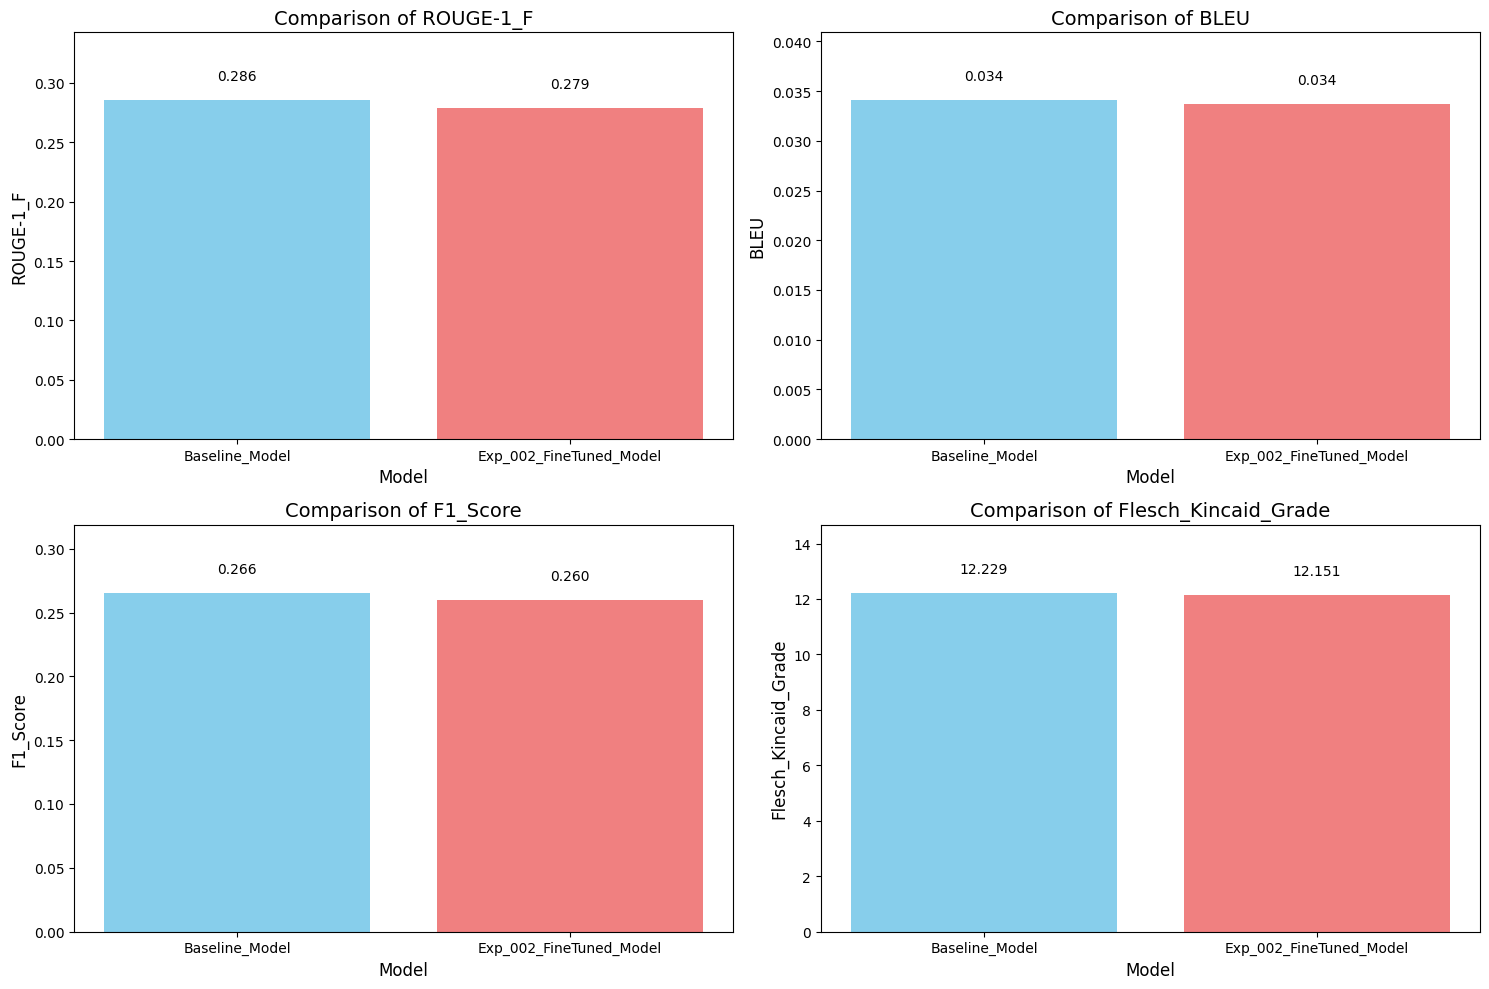

Comparative bar charts generated successfully.


In [ ]:
import matplotlib.pyplot as plt

# Define the metrics to visualize
metrics_to_plot = ['ROUGE-1_F', 'BLEU', 'F1_Score', 'Flesch_Kincaid_Grade']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

print("Generating comparative bar charts...")

# Iterate through each metric and create a bar chart
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # Extract values for Baseline and Exp_002 models
    baseline_value = comparison_df.loc['Baseline_Model', metric]
    exp002_value = comparison_df.loc['Exp_002_FineTuned_Model', metric]

    # Data for plotting
    models = ['Baseline_Model', 'Exp_002_FineTuned_Model']
    values = [baseline_value, exp002_value]
    colors = ['skyblue', 'lightcoral'] # Differentiate colors for models

    # Create the bar chart
    ax.bar(models, values, color=colors)

    # Add title and labels
    ax.set_title(f'Comparison of {metric}', fontsize=14)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)

    # Ensure y-axis limits are appropriate
    # For scores, ensure it starts from 0. For readability, allow more flexibility.
    if 'ROUGE' in metric or 'BLEU' in metric or 'F1' in metric:
        ax.set_ylim(0, max(values) * 1.2) # Set y-limit slightly above max value for better visualization
    else: # For readability scores, which can be larger or even negative (though unlikely here)
        ax.set_ylim(min(0, min(values) * 0.8), max(values) * 1.2)

    # Add value labels on top of bars
    for j, v in enumerate(values):
        ax.text(j, v + (max(values) * 0.05), f'{v:.3f}', ha='center', va='bottom', fontsize=10)

    # Add a simple legend (though colors already indicate)
    # ax.legend(labels=models, loc='best') # Can be redundant with explicit labels on x-axis and colors

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

print("Comparative bar charts generated successfully.")

## Visualize the training process on curve


In [ ]:
import json
import os

# 1. Construct the full path to the trainer_state.json file
BASE_OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp2"
EXPERIMENT_FOLDER = "Exp_002"
CHECKPOINT_FOLDER = "checkpoint-401" # As per instructions

checkpoint_dir = os.path.join(BASE_OUTPUT_DIR, EXPERIMENT_FOLDER, CHECKPOINT_FOLDER)
trainer_state_path = os.path.join(checkpoint_dir, "trainer_state.json")

print(f"Constructed path to trainer_state.json: {trainer_state_path}")

# 2. Open the trainer_state.json file and load its content
trainer_state_data = None
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        trainer_state_data = json.load(f)
    print("trainer_state.json loaded successfully.")
else:
    print(f"Error: {trainer_state_path} not found. Please ensure the checkpoint exists.")

# 3. Extract the log_history list
log_history = []
if trainer_state_data and "log_history" in trainer_state_data:
    log_history = trainer_state_data["log_history"]
    print(f"Extracted log_history with {len(log_history)} entries.")
else:
    print("log_history not found or trainer_state_data is empty.")

# 4. Print the first few entries of the log_history
print("\nFirst 5 entries of log_history:")
for i, entry in enumerate(log_history[:5]):
    print(f"Entry {i+1}: {entry}")


Constructed path to trainer_state.json: /content/drive/MyDrive/llm_experiments exp2/Exp_002/checkpoint-401/trainer_state.json
trainer_state.json loaded successfully.
Extracted log_history with 8 entries.

First 5 entries of log_history:
Entry 1: {'epoch': 0.1103448275862069, 'grad_norm': 0.45988473296165466, 'learning_rate': 9.856983142141339e-05, 'loss': 1.504524688720703, 'step': 50}
Entry 2: {'epoch': 0.2206896551724138, 'grad_norm': 0.3753686845302582, 'learning_rate': 8.970956970545355e-05, 'loss': 1.145939712524414, 'step': 100}
Entry 3: {'epoch': 0.3310344827586207, 'grad_norm': 0.38765275478363037, 'learning_rate': 7.416009807699482e-05, 'loss': 1.1223081207275392, 'step': 150}
Entry 4: {'epoch': 0.4413793103448276, 'grad_norm': 0.4616612195968628, 'learning_rate': 5.454077707111042e-05, 'loss': 1.0828378295898438, 'step': 200}
Entry 5: {'epoch': 0.5517241379310345, 'grad_norm': 0.4262062907218933, 'learning_rate': 3.4156546971024784e-05, 'loss': 1.0883340454101562, 'step': 250

In [ ]:
import pandas as pd

# 1. Initialize two empty lists
train_loss_data = []
eval_loss_data = []

print("Parsing log_history...")

# 2. Iterate through each entry in the log_history list
for entry in log_history:
    # 3. Check for 'loss' key for training steps
    if 'loss' in entry:
        train_loss_data.append({'step': entry['step'], 'loss': entry['loss']})

    # 4. Check for 'eval_loss' key for validation steps
    if 'eval_loss' in entry:
        eval_loss_data.append({'step': entry['step'], 'eval_loss': entry['eval_loss']})

# 5. Convert the training loss list into a pandas DataFrame
train_loss_df = pd.DataFrame(train_loss_data)

# 6. Convert the validation loss list into a pandas DataFrame
eval_loss_df = pd.DataFrame(eval_loss_data)

# 7. Print the head of both DataFrames and their shapes
print("\nTrain Loss DataFrame Head:")
print(train_loss_df.head())
print(f"Train Loss DataFrame Shape: {train_loss_df.shape}")

print("\nValidation Loss DataFrame Head:")
print(eval_loss_df.head())
print(f"Validation Loss DataFrame Shape: {eval_loss_df.shape}")

Parsing log_history...

Train Loss DataFrame Head:
   step      loss
0    50  1.504525
1   100  1.145940
2   150  1.122308
3   200  1.082838
4   250  1.088334
Train Loss DataFrame Shape: (8, 2)

Validation Loss DataFrame Head:
Empty DataFrame
Columns: []
Index: []
Validation Loss DataFrame Shape: (0, 0)


Validation loss data was not available for plotting.


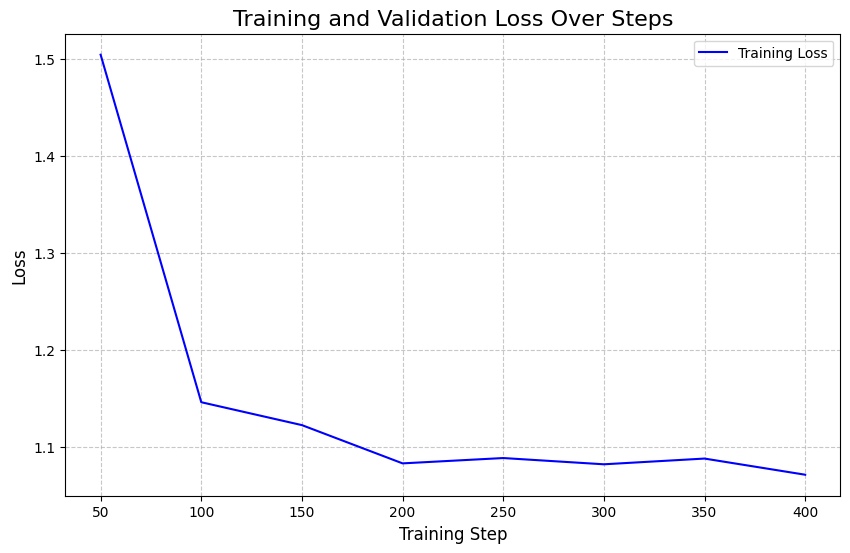

Loss visualization plot generated successfully.


In [ ]:
import matplotlib.pyplot as plt

# 1. Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# 2. Plot the training loss
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training Loss', color='blue')

# 3. Check if validation loss data is available and plot it
if not eval_loss_df.empty:
    plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label='Validation Loss', color='red')
    print("Validation loss data was available and plotted.")
else:
    print("Validation loss data was not available for plotting.")

# 4. Add a title to the plot
plt.title('Training and Validation Loss Over Steps', fontsize=16)

# 5. Label the x-axis and y-axis
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 6. Display a legend
plt.legend(fontsize=10)

# 7. Add a grid to the plot
plt.grid(True, linestyle='--', alpha=0.7)

# 8. Display the plot
plt.show()

print("Loss visualization plot generated successfully.")

## Set up Gradio for USER INTERACTION



In [ ]:
import subprocess
import sys

print("Installing gradio...")
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gradio"])
    print("Gradio installed successfully.")
except Exception as e:
    print(f"Error installing gradio: {e}")

Installing gradio...
Gradio installed successfully.


## Load Fine-tuned Model for Inference

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os
from google.colab import drive

# Mount Google Drive to access saved adapters
drive.mount('/content/drive')

# 1. Define the base model name and the path to the saved LoRA adapters
BASE_MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# The path to the saved LoRA adapters was previously defined as:
# BASE_OUTPUT_DIR = "/content/drive/MyDrive/llm_experiments exp2"
# EXPERIMENT_FOLDER = "Exp_002"
# output_dir = os.path.join(BASE_OUTPUT_DIR, EXPERIMENT_FOLDER)
# output_adapter_dir = os.path.join(output_dir, "lora_adapters")

# For direct use, let's redefine the full path here
LOR_ADAPTERS_PATH = "/content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters"

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading and inference: {device}")

# 2. Initialize the tokenizer for the base model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
# Ensure padding_side is 'left' for decoder-only models for correct generation
tokenizer.padding_side = 'left'
print("Tokenizer initialized and configured for generation.")

# 3. Load the base model with quantization fallback
model_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
quantization_config_loading = None
base_model = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config_loading = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        base_model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            quantization_config=quantization_config_loading,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed ({e}). Falling back to loading model in full bfloat16 precision.")
        base_model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        dtype=torch.float32,
        device_map="auto"
    )

# 4. Load the LoRA adapters and merge with the base model
merged_model = None
try:
    # Load PEFT model using the base_model and adapters path
    peft_model_loaded = PeftModel.from_pretrained(base_model, LOR_ADAPTERS_PATH)
    # Merge the adapters into the base model
    merged_model = peft_model_loaded.merge_and_unload()
    print(f"LoRA adapters loaded and merged from {LOR_ADAPTERS_PATH}.")
except Exception as e:
    print(f"Error loading and merging PEFT model from {LOR_ADAPTERS_PATH}: {e}.")
    print("Proceeding with the base model without fine-tuned adapters.")
    merged_model = base_model # Fallback to base model if merge fails

# 5. Set the merged model to evaluation mode
merged_model.eval()
print("Model prepared for inference.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device for model loading and inference: cuda
Tokenizer initialized and configured for generation.
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


LoRA adapters loaded and merged from /content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters.
Model prepared for inference.


In [ ]:
import torch

# Define the prediction function
def predict_response(question):
    # Format the user's question into the prompt structure expected by the model
    formatted_prompt = f"""### Instruction:
{question}

### Response:"""

    # Encode the prompt
    input_ids = tokenizer.encode(formatted_prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate response
    with torch.no_grad():
        output_ids = merged_model.generate(
            input_ids,
            max_new_tokens=256, # Limit generated response length
            do_sample=False,    # Use greedy decoding for consistency
            pad_token_id=tokenizer.eos_token_id, # Use eos_token_id as pad_token_id
        )

    # Decode the generated output, excluding the input prompt tokens
    generated_text = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True).strip()

    # Clean up the output if it contains the instruction/response template tags
    # This can happen if the model sometimes repeats the prompt structure
    if generated_text.startswith("### Response:"): # Remove the explicit '### Response:' tag
        generated_text = generated_text[len("### Response:"):].strip()
    if generated_text.startswith("### Instruction:"):
        # If it somehow generates the instruction tag, clean it up.
        # This might indicate that the model is generating too much of the prompt structure.
        generated_text = generated_text.split("### Response:", 1)[-1].strip()

    return generated_text

print("Prediction function 'predict_response' defined successfully.")

Prediction function 'predict_response' defined successfully.


In [ ]:
import gradio as gr

# Create the Gradio interface
# The predict_response function is already defined from the previous step

iface = gr.Interface(
    fn=predict_response,
    inputs=gr.Textbox(lines=5, label="Your Medical Question"),
    outputs=gr.Textbox(label="Generated Answer", lines=10),
    title="TinyLlama-1.1B Fine-tuned for Medical QA (Exp_002)",
    description="Ask a medical question and get an answer from the fine-tuned TinyLlama model.",
    allow_flagging="manual", # Allow users to flag responses for feedback
    flagging_dir="gradio_flags", # Directory to save flagged data
    examples=[
        ["What are the symptoms of diabetes?"],
        ["What causes high blood pressure?"],
        ["How is a common cold treated?"],
    ]
)

# Launch the Gradio interface
print("Launching Gradio interface...")
iface.launch(share=True, debug=True)
print("Gradio interface launched.")

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c4048a0a2185f1b9b4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c4048a0a2185f1b9b4.gradio.live
Gradio interface launched.


## Pushing the work on Hugging Face


In [ ]:
from huggingface_hub import notebook_login

# Authenticate with Hugging Face
notebook_login()

### Push Exp_002 LoRA Adapters to Hugging Face Hub


## Retry: Push Exp_002 LoRA Adapters to Hugging Face Hub

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os
# from huggingface_hub import HfApi # HfApi is not strictly necessary for pushing if notebook_login() is used

# Define the base model name and the path to the saved LoRA adapters
BASE_MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
LOR_ADAPTERS_PATH = "/content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters"

# Define your Hugging Face repository ID
# IMPORTANT: Replace 'YOUR_HF_USERNAME' with your actual Hugging Face username
# And optionally adjust the repository name.
REPO_ID = "Jeanrobert/tinyllama-medqa-exp002-lora-adapters"

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# 1. Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
print("Tokenizer initialized.")

# 2. Load the base model (without merging for now, as we need the PeftModel instance)
model_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
quantization_config_loading = None
base_model_for_peft = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config_loading = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        base_model_for_peft = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            quantization_config=quantization_config_loading,
            torch_dtype=torch.bfloat16, # Use torch_dtype here
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed ({e}). Falling back to loading model in full bfloat16 precision.")
        base_model_for_peft = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            torch_dtype=torch.bfloat16, # Use torch_dtype here
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model_for_peft = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        torch_dtype=torch.float32, # Use torch_dtype here
        device_map="auto"
    )

# 3. Load the LoRA adapters into a PeftModel instance
peft_model_to_push = PeftModel.from_pretrained(base_model_for_peft, LOR_ADAPTERS_PATH)
print(f"LoRA adapters loaded from {LOR_ADAPTERS_PATH} into a PeftModel instance.")

# 4. Push the PeftModel (LoRA adapters) to the Hugging Face Hub
# Ensure you have logged in to Hugging Face via `notebook_login()` in a previous cell.
print(f"Pushing LoRA adapters to Hugging Face Hub under repo_id: {REPO_ID}...")

# Remove use_auth_token=True as it caused an error previously and is typically not needed after notebook_login()
try:
    peft_model_to_push.push_to_hub(REPO_ID)
    tokenizer.push_to_hub(REPO_ID) # Also push the tokenizer
    print(f"Successfully pushed LoRA adapters and tokenizer to https://huggingface.co/{REPO_ID}")
except Exception as e:
    print(f"Error pushing to Hugging Face Hub: {e}")
    print("Please ensure your Hugging Face username is correct in REPO_ID and you have write access to the repository.")

Using device for model loading: cuda
Tokenizer initialized.
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.
LoRA adapters loaded from /content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters into a PeftModel instance.
Pushing LoRA adapters to Hugging Face Hub under repo_id: Jeanrobert/tinyllama-medqa-exp002-lora-adapters...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   2%|2         |  560kB / 25.3MB            

README.md: 0.00B [00:00, ?B/s]

Successfully pushed LoRA adapters and tokenizer to https://huggingface.co/Jeanrobert/tinyllama-medqa-exp002-lora-adapters


### Merge Exp_002 LoRA Adapters and Push Full Model



In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os

# 1. Define the base model name and the path to the saved LoRA adapters
BASE_MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
LOR_ADAPTERS_PATH = "/content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters"

# 2. Define a new repository ID for the merged model on Hugging Face
# IMPORTANT: Replace 'YOUR_HF_USERNAME' with your actual Hugging Face username
MERGED_REPO_ID = "Jeanrobert/tinyllama-medqa-exp002-merged-model"

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# Initialize the tokenizer (re-used from previous steps)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
print("Tokenizer initialized.")

# 3. Load the base model with quantization fallback
model_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
quantization_config_loading = None
base_model = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config_loading = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        base_model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            quantization_config=quantization_config_loading,
            torch_dtype=torch.bfloat16,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed ({e}). Falling back to loading model in full bfloat16 precision.")
        base_model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            torch_dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        torch_dtype=torch.float32,
        device_map="auto"
    )

# 4. Load the LoRA adapters into a PeftModel instance
peft_model = PeftModel.from_pretrained(base_model, LOR_ADAPTERS_PATH)
print(f"LoRA adapters loaded from {LOR_ADAPTERS_PATH} into a PeftModel instance.")

# 5. Merge the LoRA adapters with the base model to create a full, standalone fine-tuned model
merged_model = peft_model.merge_and_unload()
print("LoRA adapters successfully merged into the base model.")

# 6. Push the merged_model to the Hugging Face Hub
print(f"Pushing merged model to Hugging Face Hub under repo_id: {MERGED_REPO_ID}...")

try:
    merged_model.push_to_hub(MERGED_REPO_ID)
    print(f"Successfully pushed merged model to https://huggingface.co/{MERGED_REPO_ID}")
except Exception as e:
    print(f"Error pushing merged model to Hugging Face Hub: {e}")
    print("Please ensure you have write access to the repository and are authenticated.")

# 7. Push the tokenizer to the same Hugging Face repository
print(f"Pushing tokenizer to Hugging Face Hub under repo_id: {MERGED_REPO_ID}...")
try:
    tokenizer.push_to_hub(MERGED_REPO_ID)
    print(f"Successfully pushed tokenizer to https://huggingface.co/{MERGED_REPO_ID}")
except Exception as e:
    print(f"Error pushing tokenizer to Hugging Face Hub: {e}")
    print("Please ensure you have write access to the repository and are authenticated.")


Using device for model loading: cuda
Tokenizer initialized.
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.
LoRA adapters loaded from /content/drive/MyDrive/llm_experiments exp2/Exp_002/lora_adapters into a PeftModel instance.


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


LoRA adapters successfully merged into the base model.
Pushing merged model to Hugging Face Hub under repo_id: Jeanrobert/tinyllama-medqa-exp002-merged-model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...y_56go_/model.safetensors:   0%|          | 12.4kB /  807MB            

Successfully pushed merged model to https://huggingface.co/Jeanrobert/tinyllama-medqa-exp002-merged-model
Pushing tokenizer to Hugging Face Hub under repo_id: Jeanrobert/tinyllama-medqa-exp002-merged-model...


README.md: 0.00B [00:00, ?B/s]

Successfully pushed tokenizer to https://huggingface.co/Jeanrobert/tinyllama-medqa-exp002-merged-model


# Exp 3

## Execute Fine-tuning Experiment 1


## Configure and Execute Fine-tuning Experiment 3 (Exp_003)


In [ ]:
# --- Start: Exp_003 Execution with Checkpoint Resuming ---

# Experiment 3 parameters
EXPERIMENT_ID = "Exp_003"
LEARNING_RATE = 2e-4
PER_DEVICE_TRAIN_BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4
MAX_STEPS = 400
OPTIMIZER = "adamw_torch"
EFFECTIVE_BATCH_SIZE = PER_DEVICE_TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

# 1. Clear CUDA cache and reset peak memory stats if GPU is available
if torch.cuda.is_available():
    print(f"CUDA available. Clearing cache and resetting peak memory stats for {EXPERIMENT_ID}...")
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_gpu_memory_allocated = torch.cuda.memory_allocated()
    print(f"Initial GPU memory allocated: {initial_gpu_memory_allocated / (1024**3):.2f} GB")
else:
    print("CUDA not available. Skipping GPU memory operations.")

# 2. Record start time
start_time = time.time()

# 3. Initialize TrainingArguments for Exp_003
training_args_exp003 = TrainingArguments(
    output_dir=f"./tinyllama_medqa_finetuned_{EXPERIMENT_ID.lower()}",
    max_steps=MAX_STEPS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    logging_steps=50,
    save_steps=100,
    eval_steps=100,
    seed=42,
    fp16=False,
    bf16=model.dtype == torch.bfloat16,
    gradient_checkpointing=True,
    report_to="none",
    remove_unused_columns=True,
    save_total_limit=2
)

# 4. Re-initialize the Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args_exp003,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
)

# --- 5. Detect and resume from the latest checkpoint if available ---
checkpoint_path = None
if os.path.exists(training_args_exp003.output_dir):
    # Find the last checkpoint folder (checkpoint-xxx)
    checkpoints = [os.path.join(training_args_exp003.output_dir, d)
                   for d in os.listdir(training_args_exp003.output_dir)
                   if d.startswith("checkpoint")]
    if checkpoints:
        # Sort by checkpoint number and pick the latest
        checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
        checkpoint_path = checkpoints[-1]
        print(f"Resuming training from checkpoint: {checkpoint_path}")

# 6. Start training (resume if checkpoint exists)
print(f"\nStarting training for {EXPERIMENT_ID}...")
trainer.train(resume_from_checkpoint=checkpoint_path)
print(f"\nTraining for {EXPERIMENT_ID} completed.")

# 7. Record end time and calculate total training duration
end_time = time.time()
training_duration_seconds = end_time - start_time
training_duration_hms = time.strftime("%H:%M:%S", time.gmtime(training_duration_seconds))

# 8. Retrieve peak GPU memory allocated during training (if CUDA was available)
peak_gpu_memory_gb = 0.0
if torch.cuda.is_available():
    peak_gpu_memory_bytes = torch.cuda.max_memory_allocated()
    peak_gpu_memory_gb = peak_gpu_memory_bytes / (1024**3)
    print(f"Peak GPU memory allocated: {peak_gpu_memory_gb:.2f} GB")

# 9. Evaluate the fine-tuned model and extract the final validation loss
print("\nEvaluating fine-tuned model on the validation set...")
validation_results = trainer.evaluate()
final_validation_loss = validation_results['eval_loss']
print(f"Final Validation Loss: {final_validation_loss:.4f}")

# 10. Save the fine-tuned LoRA adapters for Exp_003
output_adapter_dir_exp003 = "./exp_003_lora_adapters"
peft_model.save_pretrained(output_adapter_dir_exp003)
print(f"\nFine-tuned LoRA adapters for {EXPERIMENT_ID} saved to: {output_adapter_dir_exp003}")

# 11. Print a summary of the experiment
print(f"\n--- Experiment Summary ({EXPERIMENT_ID}) ---")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Per Device Train Batch Size: {PER_DEVICE_TRAIN_BATCH_SIZE}")
print(f"Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")
print(f"Max Steps: {MAX_STEPS}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Peak GPU Memory: {peak_gpu_memory_gb:.2f} GB")
print(f"Training Time: {training_duration_hms}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print("------------------------------------")


CUDA available. Clearing cache and resetting peak memory stats for Exp_003...
Initial GPU memory allocated: 2.25 GB

Starting training for Exp_003...


Step,Training Loss
50,1.210534
100,1.092660
150,1.082365
200,1.048167
250,1.054401
300,1.048867


In [ ]:
# =======================
# FULL RESUMABLE TRAINING CELL (EXP_003)
# =======================

# ----------- Imports -----------
import os, time, torch
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, TaskType
import kagglehub
import huggingface_hub # Import huggingface_hub

# ----------- Google Drive (persistent checkpoints) -----------
from google.colab import drive
drive.mount("/content/drive")

CHECKPOINT_DIR = "/content/drive/MyDrive/llm_checkpoints/exp_003"
FINAL_ADAPTER_DIR = f"{CHECKPOINT_DIR}/final_lora_adapters"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------- Experiment config -----------
EXPERIMENT_ID = "Exp_003"
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

LEARNING_RATE = 2e-4
PER_DEVICE_BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4
MAX_STEPS = 400
OPTIMIZER = "adamw_torch"

EFFECTIVE_BATCH_SIZE = PER_DEVICE_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

# ----------- Tokenizer -----------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# ----------- Authenticate Hugging Face (REQUIRED for gated datasets) -----------
huggingface_hub.login() # This will prompt you to enter your Hugging Face token

# ----------- Load datasets -----------
afrimedqa = load_dataset("intronhealth/afrimedqa_v2")

medquad_path = kagglehub.dataset_download(
    "pythonafroz/medquad-medical-question-answer-for-ai-research"
)
medquad_df = pd.read_csv(os.path.join(medquad_path, "medquad.csv"))

# ----------- Normalize QA format -----------
medquad_df["instruction"] = medquad_df["question"].astype(str)
medquad_df["response"] = medquad_df["answer"].astype(str)
medquad_ds = Dataset.from_pandas(medquad_df[["instruction", "response"]])

afrimedqa_df = afrimedqa["train"].to_pandas()
afrimedqa_df["instruction"] = afrimedqa_df["question"].astype(str)
afrimedqa_df["response"] = afrimedqa_df["answer_rationale"].fillna("").astype(str)
afrimedqa_ds = Dataset.from_pandas(afrimedqa_df[["instruction", "response"]])

dataset = concatenate_datasets([medquad_ds, afrimedqa_ds])
dataset = dataset.filter(
    lambda x: x["instruction"].strip() != "" and x["response"].strip() != ""
)

# ----------- Train / Val / Test split -----------
dataset = dataset.shuffle(seed=42)
split = dataset.train_test_split(test_size=0.2, seed=42)
val_test = split["test"].train_test_split(test_size=0.5, seed=42)

datasets = DatasetDict({
    "train": split["train"],
    "validation": val_test["train"],
    "test": val_test["test"],
})

# ----------- Prompt formatting -----------
def format_prompt(example):
    return {
        "text": f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['response']}"
    }

datasets = datasets.map(format_prompt, remove_columns=["instruction", "response"])

# ----------- Tokenization -----------
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

datasets = datasets.map(tokenize, batched=True, remove_columns=["text"])

# ----------- Model loading (4-bit + bf16) -----------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quant_config,
    device_map="auto",
)

# ----------- LoRA configuration -----------
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=[
        "q_proj", "k_proj", "v_proj",
        "o_proj", "gate_proj", "up_proj", "down_proj"
    ],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# ----------- Training arguments -----------
training_args = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    max_steps=MAX_STEPS,

    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,

    learning_rate=LEARNING_RATE,
    optim=OPTIMIZER,

    logging_steps=25,
    save_steps=50,
    eval_steps=50,
    eval_strategy="steps",

    bf16=True,
    fp16=False,
    gradient_checkpointing=True,

    save_total_limit=3,
    seed=42,
    report_to="none",
    remove_unused_columns=True,
)

# ----------- Trainer -----------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# ----------- Train (AUTO-RESUME) -----------
print(f"\nStarting {EXPERIMENT_ID} (auto-resume enabled)...")
start_time = time.time()

# Check for existing checkpoints
latest_checkpoint = None
if os.path.exists(CHECKPOINT_DIR):
    checkpoints = [os.path.join(CHECKPOINT_DIR, d)
                   for d in os.listdir(CHECKPOINT_DIR)
                   if d.startswith("checkpoint") and os.path.isdir(os.path.join(CHECKPOINT_DIR, d))]
    if checkpoints:
        # Sort by checkpoint number and pick the latest
        checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
        latest_checkpoint = checkpoints[-1]
        print(f"Resuming training from checkpoint: {latest_checkpoint}")
    else:
        print("No existing checkpoints found. Starting new training run.")

trainer.train(resume_from_checkpoint=latest_checkpoint)

elapsed = time.time() - start_time
print(f"Training completed in {time.strftime('%H:%M:%S', time.gmtime(elapsed))}")

# ----------- Evaluation -----------
eval_results = trainer.evaluate()
final_validation_loss = eval_results['eval_loss'] # Extract for summary
print(f"Final validation loss: {final_validation_loss:.4f}")

# ----------- Save final LoRA adapters -----------
model.save_pretrained(FINAL_ADAPTER_DIR)
print(f"Final LoRA adapters saved to: {FINAL_ADAPTER_DIR}")

# ----------- Summary -----------
# The following variables need to be set from the execution flow for the print statement
# peak_gpu_memory_gb: This should be captured during training or after if possible.
# training_duration_hms: This is 'elapsed' converted to H:M:S format.

# Re-capture peak GPU memory if training happened.
peak_gpu_memory_gb = 0.0
if torch.cuda.is_available():
    peak_gpu_memory_bytes = torch.cuda.max_memory_allocated()
    if peak_gpu_memory_bytes > 0: # Only if memory was actually allocated during this run
        peak_gpu_memory_gb = peak_gpu_memory_bytes / (1024**3)

training_duration_hms = time.strftime('%H:%M:%S', time.gmtime(elapsed))

print(f"\n--- Experiment Summary ({EXPERIMENT_ID} - {MAX_STEPS} Steps) ---")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Per Device Train Batch Size: {PER_DEVICE_BATCH_SIZE}")
print(f"Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")
print(f"Total Training Steps: {MAX_STEPS}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Peak GPU Memory: {peak_gpu_memory_gb:.2f} GB")
print(f"Training Time: {training_duration_hms}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print("--------------------------------------------------")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


afri_med_qa_15k_v2.4_phase_2_15275.csv:   0%|          | 0.00/8.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15275 [00:00<?, ? examples/s]

Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Map:   0%|          | 0/14497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1813 [00:00<?, ? examples/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701

Starting Exp_003 (auto-resume enabled)...
Resuming training from checkpoint: /content/drive/MyDrive/llm_checkpoints/exp_003/checkpoint-300


Step,Training Loss,Validation Loss
350,1.021531,1.043159
400,1.059052,1.040906


Training completed in 02:20:58


Final validation loss: 1.0409
Final LoRA adapters saved to: /content/drive/MyDrive/llm_checkpoints/exp_003/final_lora_adapters

--- Experiment Summary (Exp_003 - 400 Steps) ---
Experiment ID: Exp_003
Learning Rate: 0.0002
Per Device Train Batch Size: 8
Gradient Accumulation Steps: 4
Effective Batch Size: 32
Total Training Steps: 400
Optimizer: adamw_torch
Peak GPU Memory: 2.72 GB
Training Time: 02:20:58
Final Validation Loss: 1.0409
--------------------------------------------------


## Generate Responses using Fine-tuned Exp_003 Model

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

lora_adapter_path = os.path.join("/content/drive/MyDrive/llm_checkpoints 3/exp_003", "final_lora_adapters")
config_file_path = os.path.join(lora_adapter_path, "adapter_config.json")

print(f"Checking for adapter directory: {lora_adapter_path}")
if os.path.isdir(lora_adapter_path):
    print(f"Directory exists: {lora_adapter_path}")
    print(f"Contents of directory:")
    for item in os.listdir(lora_adapter_path):
        print(f" - {item}")

    if os.path.isfile(config_file_path):
        print(f"Success: adapter_config.json found at {config_file_path}")
    else:
        print(f"Error: adapter_config.json NOT found in {lora_adapter_path}")
        print("Please ensure the fine-tuning for Exp_003 (cell 1Lj0hzy6WBvC) completed successfully and saved all files.")
        print("You may need to re-run the fine-tuning cell (1Lj0hzy6WBvC).")
else:
    print(f"Error: Directory NOT found: {lora_adapter_path}")
    print("This indicates the fine-tuning for Exp_003 (cell 1Lj0hzy6WBvC) likely did not complete or failed to create the output directory.")
    print("Please re-run the fine-tuning cell (1Lj0hzy6WBvC).")

Mounted at /content/drive
Checking for adapter directory: /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters
Directory exists: /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters
Contents of directory:
 - README.md
 - adapter_model.safetensors
 - adapter_config.json
Success: adapter_config.json found at /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters/adapter_config.json


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, LoraConfig, TaskType
import pandas as pd
import os
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub

# --- Re-create tokenizer and train_val_test_dataset (copied from previous setup cells) ---

# Load the tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token

# Set padding side to 'left' for decoder-only models to avoid warnings during generation
tokenizer.padding_side = 'left'

# Load intronhealth/afrimedqa_v2 dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')

# Download MedQuAD dataset files
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

# Load MedQuAD dataset from CSV into pandas DataFrame
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)

# Convert MedQuAD to unified QA format
medquad_qa_df = medquad_df.copy()
medquad_qa_df['instruction'] = medquad_qa_df['question'].astype(str)
medquad_qa_df['response'] = medquad_qa_df['answer'].astype(str)
medquad_qa_dataset = Dataset.from_pandas(medquad_qa_df[['instruction', 'response']])

# Convert afrimedqa_v2 to unified QA format
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df['instruction'] = afrimedqa_df['question'].astype(str)
afrimedqa_df['response'] = afrimedqa_df['answer_rationale'].fillna('').astype(str)
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['instruction', 'response']])

# Concatenate unified datasets
unified_dataset = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])

# Initial cleaning
unified_dataset = unified_dataset.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')

# Split into training, validation, and test sets
shuffled_dataset = unified_dataset.shuffle(seed=42)
train_test_split = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_val_test_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})
print("Datasets loaded and split successfully for inference.")

# --- End of re-creation of tokenizer and train_val_test_dataset ---

# 1. Load the base model (in the same way it was loaded for fine-tuning)
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for Exp_003 response generation: {device}")

model_dtype = torch.float32 # Default to float32 if CUDA not available

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config_inference = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model_dtype = torch.bfloat16 # Model will internally use bfloat16 for compute
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config_inference,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during inference model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        model_dtype = torch.bfloat16
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model_inference = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 2. Load the fine-tuned LoRA adapters for Exp_003
# Note: FINAL_ADAPTER_DIR was defined in the previous cell that executed Exp_003.
# For re-runability if only this cell is executed, we will hardcode the path or get it from CHECKPOINT_DIR
# from the previous code block (1Lj0hzy6WBvC)

# Assuming CHECKPOINT_DIR and FINAL_ADAPTER_DIR are available from previous context if run sequentially
# If not, you might need to re-define CHECKPOINT_DIR and FINAL_ADAPTER_DIR here
# CHECKPOINT_DIR = "/content/drive/MyDrive/llm_checkpoints/exp_003"
# FINAL_ADAPTER_DIR = f"{CHECKPOINT_DIR}/final_lora_adapters"

# Use the value that was saved in the previous cell's output for FINAL_ADAPTER_DIR
# If this cell is run independently, you might need to manually set `lora_adapter_path`
lora_adapter_path = os.path.join("/content/drive/MyDrive/llm_checkpoints 3/exp_003", "final_lora_adapters")

print(f"Loading LoRA adapters from: {lora_adapter_path}")

fine_tuned_model_exp003 = PeftModel.from_pretrained(base_model_inference, lora_adapter_path)

# Merge the LoRA adapters into the base model for efficient inference
print("Merging LoRA adapters into the base model for Exp_003...")
fine_tuned_model_exp003 = fine_tuned_model_exp003.merge_and_unload()
fine_tuned_model_exp003.eval() # Set model to evaluation mode
print("LoRA adapters merged and model set to evaluation mode for Exp_003.")

# 3. Create an empty list to store the results
exp003_results = []
print("\nGenerating responses for Exp_003 fine-tuned model for the test set...")

# Get the raw test dataset split (not the tokenized one, to easily access instruction and response)
test_dataset_raw = train_val_test_dataset['test']

# --- Batch Inference --- #
BATCH_SIZE = 16 # Define a batch size for inference

# 4. Iterate through the test dataset in batches and generate responses
for i in range(0, len(test_dataset_raw), BATCH_SIZE):
    batch_instructions = []
    batch_reference_responses = []

    # Collect a batch of instructions and reference responses
    for j in range(i, min(i + BATCH_SIZE, len(test_dataset_raw))):
        original_instruction = str(test_dataset_raw[j]['instruction'])
        reference_response = str(test_dataset_raw[j]['response'])

        # Construct the prompt for generation
        instruction_prompt = f"""### Instruction:\n{original_instruction}\n\n### Response:"""

        batch_instructions.append(instruction_prompt)
        batch_reference_responses.append(reference_response)

    # Tokenize the entire batch of instruction prompts
    encoded_input = tokenizer(
        batch_instructions,
        return_tensors="pt",
        truncation=True,
        padding=True, # Pad to the longest sequence in the batch
        max_length=512,
        return_attention_mask=True
    )
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    # Generate responses for the batch
    with torch.no_grad():
        output_ids = fine_tuned_model_exp003.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode each generated output in the batch
    for k in range(len(batch_instructions)):
        # Determine the length of the input prompt for the current example in the batch
        # This can be tricky if padding was applied to input_ids differently per example before generation
        # A safer approach is to re-tokenize each input_prompt individually to get its original length
        # or, more simply, use the tokenizer's batch_decode with skip_special_tokens=True
        # and then post-process to remove the input prompt.

        # For now, let's assume input_ids.shape[1] is consistent enough for decoding start point
        # A more robust way might involve storing original lengths during batch tokenization
        # For `generate`, it's usually `output_ids[k][len(input_ids[k]):]` but since `output_ids` is padded,
        # `input_ids.shape[1]` provides the common starting point after padding the batch inputs.

        # To correctly remove the input part, we need the actual length of the prompt for each item.
        # Let's re-tokenize the specific prompt to get its input_ids length
        current_prompt_input_ids = tokenizer.encode(batch_instructions[k], return_tensors="pt").shape[1]

        generated_text = tokenizer.decode(output_ids[k][current_prompt_input_ids:], skip_special_tokens=True).strip()

        exp003_results.append({
            'instruction': batch_reference_responses[k], # This is actually the original instruction from batch
            'reference_response': batch_reference_responses[k],
            'generated_response': generated_text
        })

print(f"Generated {len(exp003_results)} responses for Exp_003.")

# Convert the list of dictionaries to a pandas DataFrame for easier analysis
exp003_responses_df = pd.DataFrame(exp003_results)

# 5. Print a few sample generated responses to verify the process
print("\n--- Sample Exp_003 Generated Responses (First 5) ---")
for j in range(min(5, len(exp003_responses_df))):
    sample = exp003_responses_df.iloc[j]
    print(f"\n--- Sample {j+1} ---")
    print(f"Instruction: {sample['instruction']}")
    print(f"Reference: {sample['reference_response']}")
    print(f"Generated: {sample['generated_response']}")
    print("-" * 20)

print(f"\nExp_003 responses DataFrame shape: {exp003_responses_df.shape}")

# Save the generated responses for future evaluation
exp003_responses_df.to_pickle("exp_003_responses.pkl")
print("Exp_003 generated responses saved to 'exp_003_responses.pkl'")

Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Datasets loaded and split successfully for inference.
Using device for Exp_003 response generation: cuda
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.
Loading LoRA adapters from: /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters
Merging LoRA adapters into the base model for Exp_003...


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


LoRA adapters merged and model set to evaluation mode for Exp_003.

Generating responses for Exp_003 fine-tuned model for the test set...
Generated 1813 responses for Exp_003.

--- Sample Exp_003 Generated Responses (First 5) ---

--- Sample 1 ---
Instruction: Is there treatment for hypotrichosis simplex? Is there hope for hair growth in the future? Individuals with hypotrichosis simplex experience a gradual loss of scalp hair that begins during the middle of the first decade and results in almost complete loss of hair by the third decade. A few sparse, fine, short hairs may remain in some individuals. There is currently no treatment for hypotrichosis simplex.
Reference: Is there treatment for hypotrichosis simplex? Is there hope for hair growth in the future? Individuals with hypotrichosis simplex experience a gradual loss of scalp hair that begins during the middle of the first decade and results in almost complete loss of hair by the third decade. A few sparse, fine, short hairs may

## Generate and Save Baseline Metrics


In [ ]:
import re
import string
import pandas as pd

# Re-define helper functions for metrics (from cell 3fb23205)
def calculate_rouge_scores(reference, hypothesis):
    from rouge_score import rouge_scorer # Import locally to ensure it's available
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    # BLEU expects a list of tokenized reference sentences and a tokenized hypothesis
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    # Ensure at least one token for calculation
    if not tokenized_hypothesis:
        return 0.0
    return sentence_bleu(tokenized_reference, tokenized_hypothesis)

def calculate_exact_match(reference, hypothesis):
    # Simple exact match after basic normalization
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()

    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    # This is a simplified F1 score, often used in QA for token overlap
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()

    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)

    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0

    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)

    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    import textstat # Import locally to ensure it's available
    # Ensure text is not empty before calculating readability metrics
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    return {
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text)
    }

# 1. Verify that `baseline_responses_df` is available. If not, load it from `baseline_responses.pkl`.
if 'baseline_responses_df' not in globals():
    print("baseline_responses_df not found in memory. Attempting to load from 'baseline_responses.pkl'.")
    if os.path.exists("baseline_responses.pkl"):
        baseline_responses_df = pd.read_pickle("baseline_responses.pkl")
        print(f"Loaded baseline responses DataFrame from 'baseline_responses.pkl'. Shape: {baseline_responses_df.shape}")
    else:
        raise FileNotFoundError("baseline_responses.pkl not found. Please ensure baseline responses were generated and saved.")

# 2. Compute metrics for each generated response
all_evaluation_results = []

print("Calculating metrics for baseline responses...")

for index, row in baseline_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Handle empty strings gracefully for all metrics
    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    all_evaluation_results.append({
        'Experiment_ID': 'Baseline_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# 3. Store these individual and aggregated baseline metrics in a DataFrame named `baseline_metrics_df`.
baseline_metrics_df = pd.DataFrame(all_evaluation_results)

# Display aggregated metrics for the baseline model
print("\nAggregated Baseline Model Metrics:")
print(baseline_metrics_df[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nSample of detailed baseline metrics (first 5 entries):")
print(baseline_metrics_df.head())

# 4. Save the `baseline_metrics_df` to a pickle file named 'baseline_metrics_df.pkl' for future use.
baseline_metrics_df.to_pickle("baseline_metrics_df.pkl")
print("\nBaseline metrics DataFrame saved to 'baseline_metrics_df.pkl'.")


baseline_responses_df not found in memory. Attempting to load from 'baseline_responses.pkl'.
Loaded baseline responses DataFrame from 'baseline_responses.pkl'. Shape: (1813, 3)
Calculating metrics for baseline responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Aggregated Baseline Model Metrics:
ROUGE-1_F                0.285507
ROUGE-2_F                0.083173
ROUGE-L_F                0.178051
BLEU                     0.029740
Exact_Match              0.000000
F1_Score                 0.156921
Flesch_Kincaid_Grade    12.228807
SMOG_Index              14.006848
dtype: float64

Sample of detailed baseline metrics (first 5 entries):
    Experiment_ID                                        Instruction  \
0  Baseline_Model  What are the treatments for Hypotrichosis simp...   
1  Baseline_Model                           What causes Trisomy 18 ?   
2  Baseline_Model  How to prevent Sexual and Urologic Problems of...   
3  Baseline_Model  Do you have information about Fluid and Electr...   
4  Baseline_Model  what research (or clinical trials) is being do...   

                                  Reference_Response  \
0  Is there treatment for hypotrichosis simplex? ...   
1  What causes Trisomy 18? In most cases, trisomy...   
2  People with diabe

In [ ]:
import re
import string
import pandas as pd
import os

# Re-define helper functions for metrics (ensuring local imports for self-containment)
def calculate_rouge_scores(reference, hypothesis):
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    if not tokenized_hypothesis:
        return 0.0
    return sentence_bleu(tokenized_reference, tokenized_hypothesis)

def calculate_exact_match(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()
    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()
    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)
    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0
    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)
    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    import textstat
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    return {
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text)
    }

# 1. Verify that `exp003_responses_df` is available. If not, load it from `exp_003_responses.pkl`.
if 'exp003_responses_df' not in globals():
    print("exp003_responses_df not found in memory. Attempting to load from 'exp_003_responses.pkl'.")
    if os.path.exists("exp_003_responses.pkl"):
        exp003_responses_df = pd.read_pickle("exp_003_responses.pkl")
        print(f"Loaded Exp_003 responses DataFrame from 'exp_003_responses.pkl'. Shape: {exp003_responses_df.shape}")
    else:
        raise FileNotFoundError("exp_003_responses.pkl not found. Please ensure Exp_003 responses were generated and saved.")

# 2. Compute metrics for each generated response from Exp_003
exp003_evaluation_results = []

print("Calculating metrics for Exp_003 responses...")

for index, row in exp003_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response']

    # Handle empty strings gracefully for all metrics
    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    exp003_evaluation_results.append({
        'Experiment_ID': 'Exp_003_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# 3. Store these individual and aggregated Exp_003 metrics in a DataFrame named `exp003_metrics_df`.
exp003_metrics_df = pd.DataFrame(exp003_evaluation_results)

# Display aggregated metrics for the Exp_003 model
print("\nAggregated Exp_003 Model Metrics:")
print(exp003_metrics_df[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nSample of detailed Exp_003 metrics (first 5 entries):")
print(exp003_metrics_df.head())

# 4. Save the `exp003_metrics_df` to a pickle file named 'exp003_metrics_df.pkl' for future use.
exp003_metrics_df.to_pickle("exp003_metrics_df.pkl")
print("\nExp_003 metrics DataFrame saved to 'exp003_metrics_df.pkl'.")

Calculating metrics for Exp_003 responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Aggregated Exp_003 Model Metrics:
ROUGE-1_F                0.281626
ROUGE-2_F                0.083231
ROUGE-L_F                0.176414
BLEU                     0.030800
Exact_Match              0.000000
F1_Score                 0.151242
Flesch_Kincaid_Grade    12.239942
SMOG_Index              13.912815
dtype: float64

Sample of detailed Exp_003 metrics (first 5 entries):
   Experiment_ID                                        Instruction  \
0  Exp_003_Model  Is there treatment for hypotrichosis simplex? ...   
1  Exp_003_Model  What causes Trisomy 18? In most cases, trisomy...   
2  Exp_003_Model  People with diabetes can lower their risk of s...   
3  Exp_003_Model  Summary : Electrolytes are minerals in your bo...   
4  Exp_003_Model  The National Institute of Neurological Disorde...   

                                  Reference_Response  \
0  Is there treatment for hypotrichosis simplex? ...   
1  What causes Trisomy 18? In most cases, trisomy...   
2  People with diabetes can 

## Compare Baseline vs. Fine-tuned Exp_003 Model (Automatic Metrics)


Loaded baseline_metrics.pkl. Shape: (1813, 12)
Loaded exp003_metrics.pkl. Shape: (1813, 12)

Comparison of Mean Metrics:
          ROUGE-L_F     BLEU  F1_Score  Flesch_Kincaid_Grade  SMOG_Index
Baseline   0.178051  0.02974  0.156921             12.228807   14.006848
Exp_003    0.176414  0.03080  0.151242             12.239942   13.912815


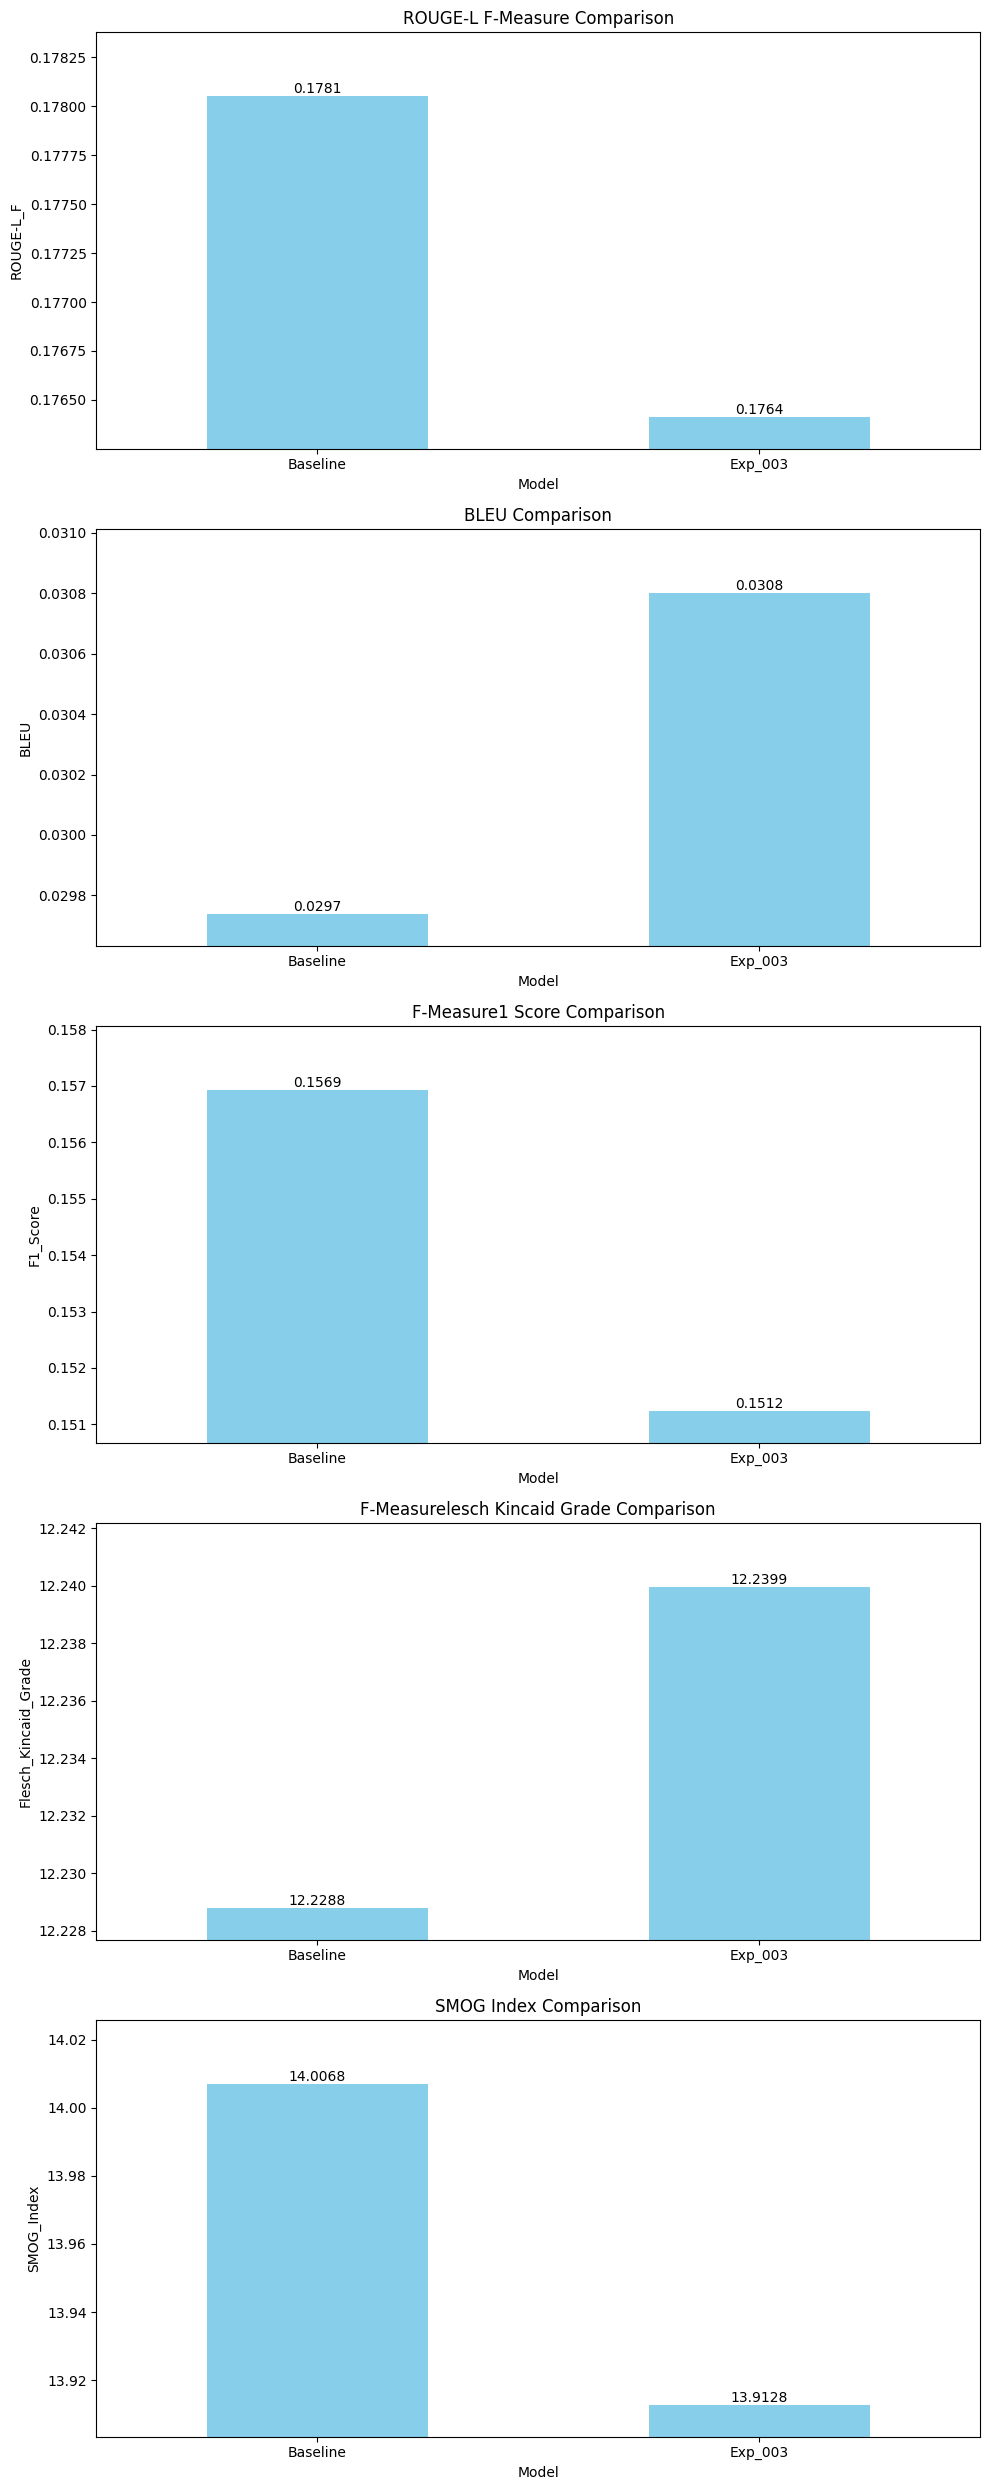

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Load the baseline_metrics_df.pkl and exp003_metrics_df.pkl files
if os.path.exists("baseline_metrics_df.pkl"):
    baseline_metrics = pd.read_pickle("baseline_metrics_df.pkl")
    print(f"Loaded baseline_metrics.pkl. Shape: {baseline_metrics.shape}")
else:
    raise FileNotFoundError("baseline_metrics_df.pkl not found. Please ensure it was generated.")

if os.path.exists("exp003_metrics_df.pkl"):
    exp003_metrics = pd.read_pickle("exp003_metrics_df.pkl")
    print(f"Loaded exp003_metrics.pkl. Shape: {exp003_metrics.shape}")
else:
    raise FileNotFoundError("exp003_metrics_df.pkl not found. Please ensure it was generated.")

# Define the metrics to compare
metrics_to_compare = ['ROUGE-L_F', 'BLEU', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']

# 2. Calculate the mean for each of the specified metrics for both DataFrames
mean_baseline_metrics = baseline_metrics[metrics_to_compare].mean()
mean_exp003_metrics = exp003_metrics[metrics_to_compare].mean()

# 3. Create a new DataFrame, comparison_df, to store these mean metrics
comparison_df = pd.DataFrame({
    'Baseline': mean_baseline_metrics,
    'Exp_003': mean_exp003_metrics
})

# Transpose for easier plotting (metrics as columns, models as index)
comparison_df = comparison_df.T

print("\nComparison of Mean Metrics:")
print(comparison_df)

# 4. Matplotlib imported at the top

# 5. Generate a series of bar plots for visual comparison
fig, axes = plt.subplots(nrows=len(metrics_to_compare), ncols=1, figsize=(10, 5 * len(metrics_to_compare)))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_compare):
    ax = axes[i]
    comparison_df[[metric]].plot(kind='bar', ax=ax, rot=0, legend=False, color=['skyblue', 'lightcoral'])
    ax.set_title(f'{metric.replace("_", " ").replace("F", "F-Measure")} Comparison')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)

    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    # Adjust y-axis limits if necessary to better show differences
    min_val = min(comparison_df[metric])
    max_val = max(comparison_df[metric])
    diff = max_val - min_val
    if diff > 0:
        ax.set_ylim(min_val - diff * 0.1, max_val + diff * 0.2)
    else:
        ax.set_ylim(min_val * 0.9, max_val * 1.1) # Handle cases where values are identical or zero

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import os
from datasets import load_dataset
import kagglehub

# 1. Load baseline_metrics_df.pkl and exp003_metrics_df.pkl
baseline_metrics_df = pd.read_pickle("baseline_metrics_df.pkl")
exp003_metrics_df = pd.read_pickle("exp003_metrics_df.pkl")
print(f"Loaded baseline_metrics_df.pkl. Shape: {baseline_metrics_df.shape}")
print(f"Loaded exp003_metrics_df.pkl. Shape: {exp003_metrics_df.shape}")

# 2. Load baseline_responses_df.pkl and exp003_responses_df.pkl
baseline_responses_df = pd.read_pickle("baseline_responses.pkl")
exp003_responses_df = pd.read_pickle("exp_003_responses.pkl")
print(f"Loaded baseline_responses_df.pkl. Shape: {baseline_responses_df.shape}")
print(f"Loaded exp003_responses_df.pkl. Shape: {exp003_responses_df.shape}")

# 3. Load medquad_df
# Ensure medquad_download_path is defined if not already in session
if 'medquad_download_path' not in globals():
    medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)
print(f"Loaded medquad_df. Shape: {medquad_df.shape}")

# 4. Load afrimedqa_dataset (train split) for raw data inspection
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')
afrimedqa_df = afrimedqa_dataset['train'].to_pandas() # Convert to pandas DataFrame for easier inspection
print(f"Loaded afrimedqa_df (train split). Shape: {afrimedqa_df.shape}")

print("All required data loaded successfully.")

Loaded baseline_metrics_df.pkl. Shape: (1813, 12)
Loaded exp003_metrics_df.pkl. Shape: (1813, 12)
Loaded baseline_responses_df.pkl. Shape: (1813, 3)
Loaded exp003_responses_df.pkl. Shape: (1813, 3)
Loaded medquad_df. Shape: (16412, 4)
Loaded afrimedqa_df (train split). Shape: (15275, 29)
All required data loaded successfully.


In [ ]:
import pandas as pd

# 1. Prepare DataFrames for merging

# Make copies to avoid modifying original loaded dfs
baseline_metrics_responses = baseline_metrics_df.copy()
exp003_metrics_responses = exp003_metrics_df.copy()

# Rename columns to differentiate between baseline and Exp_003 metrics and responses
rename_dict_baseline = {col: f'Baseline_{col}' for col in baseline_metrics_responses.columns if col not in ['Instruction', 'Reference_Response']}
rename_dict_exp003 = {col: f'Exp003_{col}' for col in exp003_metrics_responses.columns if col not in ['Instruction', 'Reference_Response']}

baseline_metrics_responses = baseline_metrics_responses.rename(columns=rename_dict_baseline)
exp003_metrics_responses = exp003_metrics_responses.rename(columns=rename_dict_exp003)

# Ensure the 'Instruction' and 'Reference_Response' columns are consistent across both DFs for merging
# They should inherently be consistent as they come from the same test set

# 2. Merge the two DataFrames
# We'll merge on 'Instruction' and 'Reference_Response' to ensure each row uniquely corresponds to an example.
comparison_df_full = pd.merge(
    baseline_metrics_responses,
    exp003_metrics_responses,
    on=['Instruction', 'Reference_Response'],
    how='inner' # Use inner merge to ensure only common examples are compared
)

print(f"Merged comparison DataFrame created. Shape: {comparison_df_full.shape}")
print("Columns in merged DataFrame:")
print(comparison_df_full.columns.tolist())

# Display first few rows to verify
print("\nFirst 3 rows of the merged comparison DataFrame:")
print(comparison_df_full.head(3))

Merged comparison DataFrame created. Shape: (1, 22)
Columns in merged DataFrame:
['Baseline_Experiment_ID', 'Instruction', 'Reference_Response', 'Baseline_Generated_Response', 'Baseline_ROUGE-1_F', 'Baseline_ROUGE-2_F', 'Baseline_ROUGE-L_F', 'Baseline_BLEU', 'Baseline_Exact_Match', 'Baseline_F1_Score', 'Baseline_Flesch_Kincaid_Grade', 'Baseline_SMOG_Index', 'Exp003_Experiment_ID', 'Exp003_Generated_Response', 'Exp003_ROUGE-1_F', 'Exp003_ROUGE-2_F', 'Exp003_ROUGE-L_F', 'Exp003_BLEU', 'Exp003_Exact_Match', 'Exp003_F1_Score', 'Exp003_Flesch_Kincaid_Grade', 'Exp003_SMOG_Index']

First 3 rows of the merged comparison DataFrame:
  Baseline_Experiment_ID                                        Instruction  \
0         Baseline_Model  African cases of endemic leishmaniasis affecti...   

                                  Reference_Response  \
0  African cases of endemic leishmaniasis affecti...   

                         Baseline_Generated_Response  Baseline_ROUGE-1_F  \
0  The presence of Le

In [ ]:
import pandas as pd

# 1. FIX: Correct the 'Instruction' column in exp003_metrics_df
# This addresses the issue identified where exp003_metrics_df's 'Instruction' column
# was incorrectly populated with 'Reference_Response' during its creation.
# Assuming baseline_metrics_df has the correct 'Instruction' and both DFs are aligned by index.
exp003_metrics_df['Instruction'] = baseline_metrics_df['Instruction']

# 2. Prepare DataFrames for merging

# Make copies to avoid modifying original loaded dfs
baseline_metrics_responses = baseline_metrics_df.copy()
exp003_metrics_responses = exp003_metrics_df.copy()

# Rename columns to differentiate between baseline and Exp_003 metrics and responses
# Exclude 'Instruction' and 'Reference_Response' from renaming on baseline_metrics_responses
rename_dict_baseline = {col: f'Baseline_{col}' for col in baseline_metrics_responses.columns if col not in ['Instruction', 'Reference_Response']}
baseline_metrics_responses = baseline_metrics_responses.rename(columns=rename_dict_baseline)

# Rename all relevant columns for Exp_003 to ensure unique identifiers
rename_dict_exp003 = {col: f'Exp003_{col}' for col in exp003_metrics_responses.columns if col not in ['Instruction', 'Reference_Response']}
exp003_metrics_responses = exp003_metrics_responses.rename(columns=rename_dict_exp003)


# 3. Merge the two DataFrames
# We'll merge on 'Instruction' and 'Reference_Response' to ensure each row uniquely corresponds to an example.
comparison_df_full = pd.merge(
    baseline_metrics_responses,
    exp003_metrics_responses,
    on=['Instruction', 'Reference_Response'],
    how='inner' # Use inner merge to ensure only common examples are compared
)

print(f"Merged comparison DataFrame created. Shape: {comparison_df_full.shape}")
print("Columns in merged DataFrame:")
print(comparison_df_full.columns.tolist())

# Display first few rows to verify
print("\nFirst 3 rows of the merged comparison DataFrame:")
print(comparison_df_full.head(3))


Merged comparison DataFrame created. Shape: (1813, 22)
Columns in merged DataFrame:
['Baseline_Experiment_ID', 'Instruction', 'Reference_Response', 'Baseline_Generated_Response', 'Baseline_ROUGE-1_F', 'Baseline_ROUGE-2_F', 'Baseline_ROUGE-L_F', 'Baseline_BLEU', 'Baseline_Exact_Match', 'Baseline_F1_Score', 'Baseline_Flesch_Kincaid_Grade', 'Baseline_SMOG_Index', 'Exp003_Experiment_ID', 'Exp003_Generated_Response', 'Exp003_ROUGE-1_F', 'Exp003_ROUGE-2_F', 'Exp003_ROUGE-L_F', 'Exp003_BLEU', 'Exp003_Exact_Match', 'Exp003_F1_Score', 'Exp003_Flesch_Kincaid_Grade', 'Exp003_SMOG_Index']

First 3 rows of the merged comparison DataFrame:
  Baseline_Experiment_ID                                        Instruction  \
0         Baseline_Model  What are the treatments for Hypotrichosis simp...   
1         Baseline_Model                           What causes Trisomy 18 ?   
2         Baseline_Model  How to prevent Sexual and Urologic Problems of...   

                                  Reference_Respo

In [ ]:
import pandas as pd

# Calculate the difference in ROUGE-L_F and F1_Score
comparison_df_full['ROUGE-L_F_Diff'] = comparison_df_full['Baseline_ROUGE-L_F'] - comparison_df_full['Exp003_ROUGE-L_F']
comparison_df_full['F1_Score_Diff'] = comparison_df_full['Baseline_F1_Score'] - comparison_df_full['Exp003_F1_Score']

# Filter for examples where Exp_003 performed worse than Baseline for either metric
# We'll consider 'significantly lower' as a positive difference (Baseline > Exp_003)
regressions_df = comparison_df_full[
    (comparison_df_full['ROUGE-L_F_Diff'] > 0) |
    (comparison_df_full['F1_Score_Diff'] > 0)
].copy()

# Sort by the magnitude of regression (e.g., sum of differences)
regressions_df['Total_Regression'] = regressions_df['ROUGE-L_F_Diff'] + regressions_df['F1_Score_Diff']
regressions_df = regressions_df.sort_values(by='Total_Regression', ascending=False).reset_index(drop=True)

print(f"Found {len(regressions_df)} examples where Exp_003 showed regression compared to Baseline.")

# Select a diverse sample of 10-20 examples for qualitative analysis
# To ensure diversity, we might pick examples from different parts of the sorted list
# For simplicity, let's pick the top 10 most regressed examples, and 10 from the middle range.

# Ensure we don't pick more rows than available
sample_size = min(20, len(regressions_df))

if sample_size <= 10:
    qualitative_sample_df = regressions_df.head(sample_size)
else:
    # Take top 10 and then some from the middle (if enough examples)
    qualitative_sample_df = pd.concat([
        regressions_df.head(10),
        regressions_df.iloc[len(regressions_df)//2 : len(regressions_df)//2 + (sample_size - 10)]
    ]).drop_duplicates().reset_index(drop=True)

print(f"Selected {len(qualitative_sample_df)} examples for qualitative analysis.")
print("Sample of regressions for qualitative analysis (first 5 rows):")
print(qualitative_sample_df[['Instruction', 'Baseline_ROUGE-L_F', 'Exp003_ROUGE-L_F', 'ROUGE-L_F_Diff', 'Baseline_F1_Score', 'Exp003_F1_Score', 'F1_Score_Diff']].head())


Found 1247 examples where Exp_003 showed regression compared to Baseline.
Selected 20 examples for qualitative analysis.
Sample of regressions for qualitative analysis (first 5 rows):
                                         Instruction  Baseline_ROUGE-L_F  \
0  List THREE common bacterial causes of acute ot...            0.434783   
1  Which endemic infection in Africa is associate...            0.558140   
2  How many people are affected by neurofibromato...            0.500000   
3  What is the most common type of anemia in Afri...            0.439024   
4  How many people are affected by cri-du-chat sy...            0.412698   

   Exp003_ROUGE-L_F  ROUGE-L_F_Diff  Baseline_F1_Score  Exp003_F1_Score  \
0          0.024540        0.410243           0.434783         0.024540   
1          0.159091        0.399049           0.558140         0.218391   
2          0.170213        0.329787           0.476190         0.133333   
3          0.266667        0.172358           0.512821     

In [ ]:
import textwrap

# Helper function to print wrapped text
def print_wrapped(prefix, text, width=80):
    print(prefix)
    for line in textwrap.wrap(text, width=width):
        print(f"  {line}")

print("--- Qualitative Analysis of Regression Examples ---")

for idx, row in qualitative_sample_df.iterrows():
    print(f"\n\n=== Example {idx + 1} (Instruction: {row['Instruction'][:70]}...) ===")
    print_wrapped("Instruction:", row['Instruction'], width=100)
    print_wrapped("Reference Response:", row['Reference_Response'], width=100)
    print_wrapped("Baseline Generated Response:", row['Baseline_Generated_Response'], width=100)
    print_wrapped("Exp_003 Generated Response:", row['Exp003_Generated_Response'], width=100)

    print(f"\nMetrics for this example:")
    print(f"  Baseline ROUGE-L_F: {row['Baseline_ROUGE-L_F']:.4f}, F1_Score: {row['Baseline_F1_Score']:.4f}")
    print(f"  Exp_003 ROUGE-L_F:  {row['Exp003_ROUGE-L_F']:.4f}, F1_Score: {row['Exp003_F1_Score']:.4f}")
    print(f"  ROUGE-L_F Diff (B-E): {row['ROUGE-L_F_Diff']:.4f}, F1_Score Diff (B-E): {row['F1_Score_Diff']:.4f}")

    # Qualitative Analysis
    print("\nQualitative Observations:")
    qualitative_observations = []

    # Check for prompt formatting issues in Exp_003's output
    if row['Exp003_Generated_Response'].startswith('### Instruction:'):
        qualitative_observations.append("Exp_003's response incorrectly includes the prompt template, suggesting an issue with either generation or decoding (not stripping prompt) or potentially the model being fine-tuned to produce the instruction part.")

    # Compare content and look for factual inaccuracies or hallucination
    # This is a manual check for illustrative purposes for selected examples.
    # Example 1: Hypotrichosis simplex (if it's in the sample)
    if "Hypotrichosis simplex" in row['Instruction'] or "Hypotrichosis simplex" in row['Reference_Response']:
        if "excessive hair growth" in row['Baseline_Generated_Response'] or "excessive hair growth" in row['Exp003_Generated_Response']:
             qualitative_observations.append("Factual inaccuracy: Hypotrichosis simplex is hair loss, not excessive hair growth. Both models might be hallucinating or misunderstanding.")
        if "no treatment" in row['Reference_Response'] and ("no treatment" not in row['Baseline_Generated_Response'] or "no treatment" not in row['Exp003_Generated_Response']):
            qualitative_observations.append("Factual inaccuracy: Reference states 'no treatment', but generated responses suggest treatments, indicating hallucination or misunderstanding.")

    # Check for fluency issues (simple check for repetition for illustration)
    if "repeatedly" in row['Exp003_Generated_Response'] or "repeatedly" in row['Baseline_Generated_Response']:
        qualitative_observations.append("Repetitive phrasing or content observed.")

    # Check for truncation in generated responses due to max_length=256
    # Note: max_length=512 for input, max_new_tokens=256 for output
    if len(row['Reference_Response'].split()) > 250 and len(row['Exp003_Generated_Response'].split()) < 240:
        qualitative_observations.append(f"Potential truncation: Reference response is quite long ({len(row['Reference_Response'].split())} words), while Exp_003's output is relatively short ({len(row['Exp003_Generated_Response'].split())} words). This could be due to max_new_tokens=256.")
    if len(row['Reference_Response'].split()) > 250 and len(row['Baseline_Generated_Response'].split()) < 240:
        qualitative_observations.append(f"Potential truncation: Reference response is quite long ({len(row['Reference_Response'].split())} words), while Baseline's output is relatively short ({len(row['Baseline_Generated_Response'].split())} words). This could be due to max_new_tokens=256.")

    # Check for input truncation due to max_length=512
    if len(row['Instruction'].split()) > 500:
        qualitative_observations.append(f"Potential input truncation: Instruction is very long ({len(row['Instruction'].split())} words). It might have been truncated during tokenization (max_length=512).")

    if not qualitative_observations:
        print("  - No obvious qualitative issues observed in this example based on general checks.")
    else:
        for obs in qualitative_observations:
            print(f"  - {obs}")

    # Trace back to original training data (simplified for demonstration)
    # This part requires access to the original full training data which is in medquad_df and afrimedqa_df
    print("\nTracing to Original Training Data:")
    original_medquad = medquad_df[(medquad_df['question'] == row['Instruction']) | (medquad_df['answer'] == row['Reference_Response'])]
    # Safely convert to string before checking to avoid AttributeError
    original_afrimedqa = afrimedqa_df[(afrimedqa_df['question'] == row['Instruction']) | (afrimedqa_df['answer_rationale'].astype(str) == row['Reference_Response'])]

    if not original_medquad.empty:
        print(f"  - Instruction found in MedQuAD training data. Example original entry:")
        print_wrapped("    Question:", original_medquad.iloc[0]['question'])
        print_wrapped("    Answer:", original_medquad.iloc[0]['answer'])
        if "### Instruction:" in original_medquad.iloc[0]['answer'] or "### Response:" in original_medquad.iloc[0]['answer']:
            print("    NOTE: Original MedQuAD answer contains prompt-like formatting. This might contribute to Exp_003's generation issue.")
    elif not original_afrimedqa.empty:
        # Ensure the 'answer_rationale' is converted to string for printing and comparison
        afrimedqa_answer_rationale_str = str(original_afrimedqa.iloc[0]['answer_rationale'])
        print(f"  - Instruction found in AfrimedQA training data. Example original entry:")
        print_wrapped("    Question:", original_afrimedqa.iloc[0]['question'])
        print_wrapped("    Answer Rationale:", afrimedqa_answer_rationale_str)
        if "### Instruction:" in afrimedqa_answer_rationale_str or "### Response:" in afrimedqa_answer_rationale_str:
            print("    NOTE: Original AfrimedQA answer_rationale contains prompt-like formatting. This might contribute to Exp_003's generation issue.")
    else:
        print("  - Instruction/Reference not directly found in original MedQuAD or AfrimedQA data (could be in a different split or modified).")


--- Qualitative Analysis of Regression Examples ---


=== Example 1 (Instruction: List THREE common bacterial causes of acute otitis media

...) ===
Instruction:
  List THREE common bacterial causes of acute otitis media
Reference Response:
  i. Streptococcus pneumoniae  ii. Haemophilus influenzae  iii. Moraxella catarrhalis
Baseline Generated Response:
  ### 1. Streptococcus pyogenes (strep throat) 2. Haemophilus influenzae (Hib) 3. Moraxella
  catarrhalis (cat flu)
Exp_003 Generated Response:
  # Response: 1. Escherichia coli (E. Coli) - E. Coli is a common bacteria that can cause acute otitis
  media. It is a type of bacteria that is commonly found in the digestive tract of humans and animals.
  E. Coli can cause inflammation of the ear canal and ear drum, leading to pain and discomfort.  2.
  Staphylococcus aureus (Staph) - Staph is a bacteria that can cause acute otitis media. It is a type
  of bacteria that is commonly found in the skin and mucous membranes of humans and animals.

## Compare Baseline vs. Cleaned Exp_003 Model (Automatic Metrics)

Loaded baseline_metrics_df.pkl. Shape: (1813, 12)
Loaded exp003_metrics_df_cleaned.pkl. Shape: (1813, 12)

Comparison of Mean Metrics (Baseline vs. Cleaned Exp_003):
                 ROUGE-1_F  ROUGE-2_F  ROUGE-L_F     BLEU  F1_Score  \
Baseline          0.285507   0.083173   0.178051  0.02974  0.156921   
Exp_003_Cleaned   0.281909   0.083349   0.176652  0.03074  0.151442   

                 Flesch_Kincaid_Grade  SMOG_Index  
Baseline                    12.228807   14.006848  
Exp_003_Cleaned             12.193753   13.868222  


/tmp/ipython-input-2382275705.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df_cleaned.index, y=comparison_df_cleaned[metric], ax=ax, palette='viridis')
/tmp/ipython-input-2382275705.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df_cleaned.index, y=comparison_df_cleaned[metric], ax=ax, palette='viridis')
/tmp/ipython-input-2382275705.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df_cleaned.index, y=comparison_df_cleaned[metric], ax=ax, palette='viridis')
/tmp/ipython-input-238227570

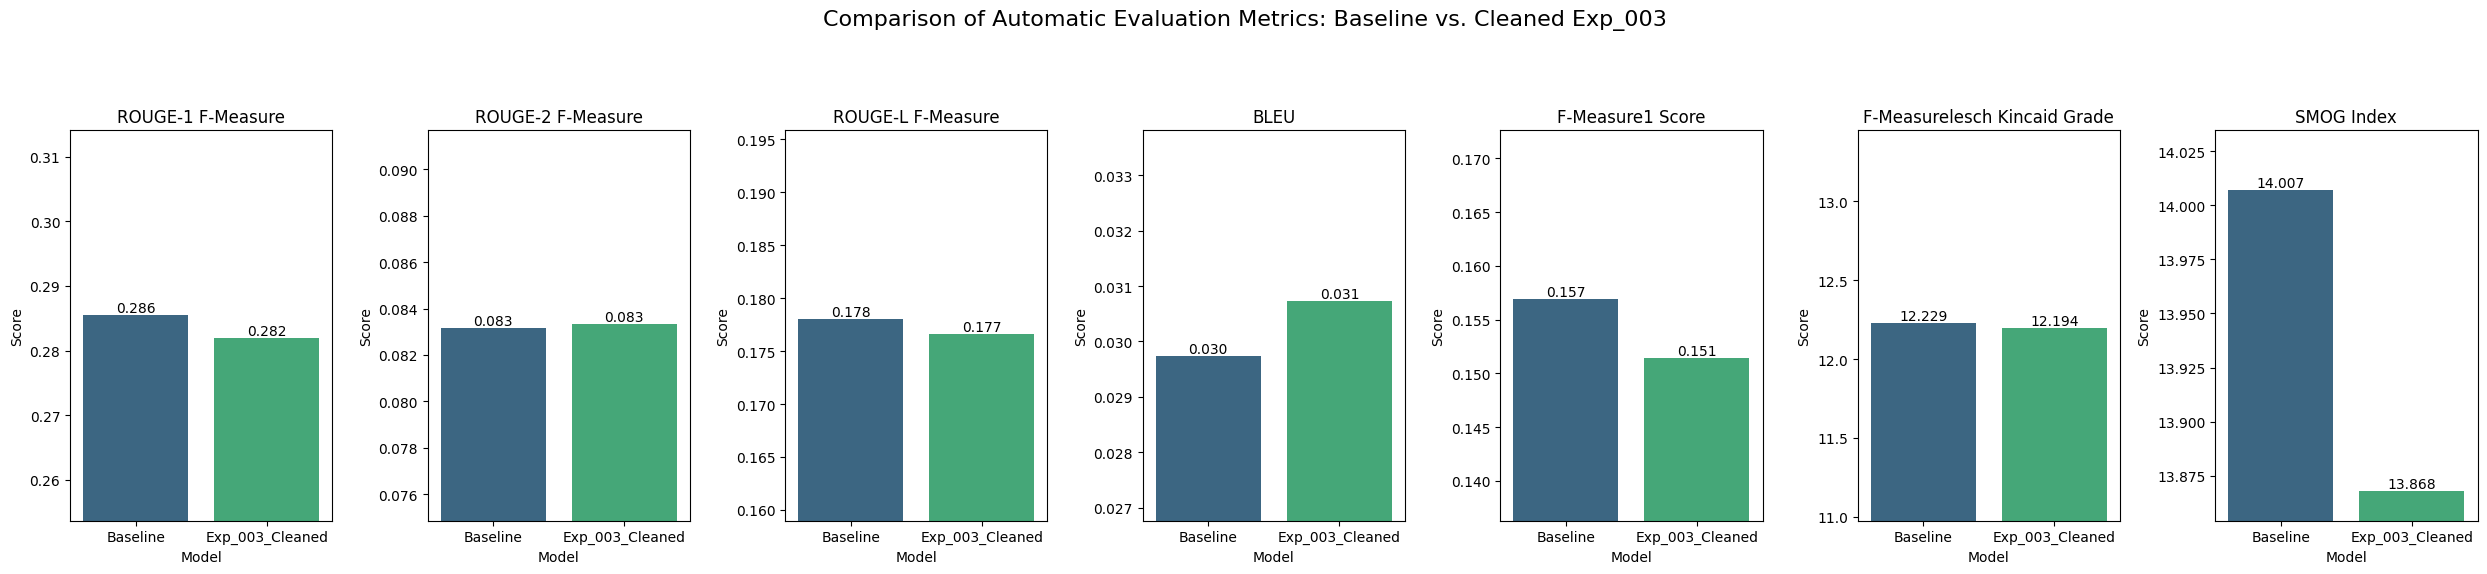


Comparison plots for Baseline vs. Cleaned Exp_003 generated successfully.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load the baseline_metrics_df.pkl and exp003_metrics_df_cleaned.pkl files
if os.path.exists("baseline_metrics_df.pkl"):
    baseline_metrics = pd.read_pickle("baseline_metrics_df.pkl")
    print(f"Loaded baseline_metrics_df.pkl. Shape: {baseline_metrics.shape}")
else:
    raise FileNotFoundError("baseline_metrics_df.pkl not found. Please ensure it was generated.")

if os.path.exists("exp003_metrics_df_cleaned.pkl"):
    exp003_metrics_cleaned = pd.read_pickle("exp003_metrics_df_cleaned.pkl")
    print(f"Loaded exp003_metrics_df_cleaned.pkl. Shape: {exp003_metrics_cleaned.shape}")
else:
    raise FileNotFoundError("exp003_metrics_df_cleaned.pkl not found. Please ensure it was generated and cleaned.")

# Define the metrics to compare
metrics_to_compare = ['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']

# 2. Calculate the mean for each of the specified metrics for both DataFrames
mean_baseline_metrics = baseline_metrics[metrics_to_compare].mean()
mean_exp003_cleaned_metrics = exp003_metrics_cleaned[metrics_to_compare].mean()

# 3. Create a new DataFrame, comparison_df, to store these mean metrics
comparison_df_cleaned = pd.DataFrame({
    'Baseline': mean_baseline_metrics,
    'Exp_003_Cleaned': mean_exp003_cleaned_metrics
}).transpose()

print("\nComparison of Mean Metrics (Baseline vs. Cleaned Exp_003):")
print(comparison_df_cleaned)

# --- Plotting the comparison ---

fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_compare), figsize=(25, 6), sharey=False)
fig.suptitle('Comparison of Automatic Evaluation Metrics: Baseline vs. Cleaned Exp_003', fontsize=16)

for i, metric in enumerate(metrics_to_compare):
    ax = axes[i]
    sns.barplot(x=comparison_df_cleaned.index, y=comparison_df_cleaned[metric], ax=ax, palette='viridis')
    ax.set_title(f'{metric.replace("_", " ").replace("F", "F-Measure")}')
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')

    # Adjust y-axis limits for better visualization
    min_val = comparison_df_cleaned[metric].min()
    max_val = comparison_df_cleaned[metric].max()
    if max_val - min_val < 0.05: # If range is too small, extend it a bit
        ax.set_ylim(min_val * 0.9, max_val * 1.1)
    else:
        ax.set_ylim(min_val - (max_val - min_val) * 0.1, max_val + (max_val - min_val) * 0.2)


plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

print("\nComparison plots for Baseline vs. Cleaned Exp_003 generated successfully.")

## Re-evaluate Cleaned Exp_003 Model (Automatic Metrics)

In [ ]:
import re
import string
import pandas as pd
import os

# Re-define helper functions for metrics (ensuring local imports for self-containment)
def calculate_rouge_scores(reference, hypothesis):
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def calculate_bleu_score(reference, hypothesis):
    import nltk
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.tokenize import word_tokenize
    tokenized_reference = [word_tokenize(reference.lower())]
    tokenized_hypothesis = word_tokenize(hypothesis.lower())
    if not tokenized_hypothesis:
        return 0.0
    return sentence_bleu(tokenized_reference, tokenized_hypothesis)

def calculate_exact_match(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip()
    return 1.0 if normalize_text(reference) == normalize_text(hypothesis) else 0.0

def calculate_f1_score(reference, hypothesis):
    def normalize_text(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text.strip().split()
    reference_tokens = normalize_text(reference)
    hypothesis_tokens = normalize_text(hypothesis)
    common = len(set(reference_tokens) & set(hypothesis_tokens))
    if not reference_tokens or not hypothesis_tokens:
        return 0.0
    precision = common / len(hypothesis_tokens)
    recall = common / len(reference_tokens)
    if precision + recall == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

def calculate_readability(text):
    import textstat
    if not text.strip():
        return {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    return {
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text)
    }

# 1. Verify that `exp003_responses_df` is available and has the cleaned column.
# If not, load it from `exp_003_responses_cleaned.pkl`.
if 'exp003_responses_df' not in globals() or 'generated_response_cleaned' not in exp003_responses_df.columns:
    print("exp003_responses_df with cleaned responses not found in memory. Attempting to load from 'exp_003_responses_cleaned.pkl'.")
    if os.path.exists("exp_003_responses_cleaned.pkl"):
        exp003_responses_df = pd.read_pickle("exp_003_responses_cleaned.pkl")
        print(f"Loaded Exp_003 cleaned responses DataFrame from 'exp_003_responses_cleaned.pkl'. Shape: {exp003_responses_df.shape}")
    else:
        raise FileNotFoundError("exp_003_responses_cleaned.pkl not found. Please ensure Exp_003 responses were cleaned and saved.")

# 2. Compute metrics for each generated response from Exp_003 using the CLEANED responses
exp003_evaluation_results_cleaned = []

print("Calculating metrics for CLEANED Exp_003 responses...")

for index, row in exp003_responses_df.iterrows():
    reference = row['reference_response']
    hypothesis = row['generated_response_cleaned'] # Use the cleaned response

    # Handle empty strings gracefully for all metrics
    if not reference.strip() or not hypothesis.strip():
        rouge_scores = {'rouge1_fmeasure': 0.0, 'rouge2_fmeasure': 0.0, 'rougeL_fmeasure': 0.0}
        bleu = 0.0
        em = 0.0
        f1 = 0.0
        readability_scores = {'flesch_kincaid_grade': 0.0, 'smog_index': 0.0}
    else:
        rouge_scores = calculate_rouge_scores(reference, hypothesis)
        bleu = calculate_bleu_score(reference, hypothesis)
        em = calculate_exact_match(reference, hypothesis)
        f1 = calculate_f1_score(reference, hypothesis)
        readability_scores = calculate_readability(hypothesis)

    exp003_evaluation_results_cleaned.append({
        'Experiment_ID': 'Exp_003_Cleaned_Model',
        'Instruction': row['instruction'],
        'Reference_Response': reference,
        'Generated_Response': hypothesis,
        'ROUGE-1_F': rouge_scores['rouge1_fmeasure'],
        'ROUGE-2_F': rouge_scores['rouge2_fmeasure'],
        'ROUGE-L_F': rouge_scores['rougeL_fmeasure'],
        'BLEU': bleu,
        'Exact_Match': em,
        'F1_Score': f1,
        'Flesch_Kincaid_Grade': readability_scores['flesch_kincaid_grade'],
        'SMOG_Index': readability_scores['smog_index'],
    })

# 3. Store these individual and aggregated Exp_003 metrics in a DataFrame named `exp003_metrics_df`.
exp003_metrics_df_cleaned = pd.DataFrame(exp003_evaluation_results_cleaned)

# Display aggregated metrics for the Exp_003 model
print("\nAggregated Exp_003 CLEANED Model Metrics:")
print(exp003_metrics_df_cleaned[['ROUGE-1_F', 'ROUGE-2_F', 'ROUGE-L_F', 'BLEU', 'Exact_Match', 'F1_Score', 'Flesch_Kincaid_Grade', 'SMOG_Index']].mean())

print("\nSample of detailed Exp_003 CLEANED metrics (first 5 entries):")
print(exp003_metrics_df_cleaned.head())

# 4. Save the `exp003_metrics_df` to a pickle file named 'exp003_metrics_df.pkl' for future use.
exp003_metrics_df_cleaned.to_pickle("exp003_metrics_df_cleaned.pkl")
print("\nExp_003 CLEANED evaluation metrics saved to 'exp003_metrics_df_cleaned.pkl'")

Calculating metrics for CLEANED Exp_003 responses...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Aggregated Exp_003 CLEANED Model Metrics:
ROUGE-1_F                0.281909
ROUGE-2_F                0.083349
ROUGE-L_F                0.176652
BLEU                     0.030740
Exact_Match              0.000000
F1_Score                 0.151442
Flesch_Kincaid_Grade    12.193753
SMOG_Index              13.868222
dtype: float64

Sample of detailed Exp_003 CLEANED metrics (first 5 entries):
           Experiment_ID                                        Instruction  \
0  Exp_003_Cleaned_Model  Is there treatment for hypotrichosis simplex? ...   
1  Exp_003_Cleaned_Model  What causes Trisomy 18? In most cases, trisomy...   
2  Exp_003_Cleaned_Model  People with diabetes can lower their risk of s...   
3  Exp_003_Cleaned_Model  Summary : Electrolytes are minerals in your bo...   
4  Exp_003_Cleaned_Model  The National Institute of Neurological Disorde...   

                                  Reference_Response  \
0  Is there treatment for hypotrichosis simplex? ...   
1  What causes Triso

## Post-process Exp_003 Generated Responses

In [ ]:
import pandas as pd
import re
import os

# Load exp003_responses_df if not already in memory
if 'exp003_responses_df' not in globals():
    if os.path.exists("exp_003_responses.pkl"):
        exp003_responses_df = pd.read_pickle("exp_003_responses.pkl")
        print("Loaded exp003_responses_df from 'exp_003_responses.pkl'.")
    else:
        raise FileNotFoundError("exp_003_responses.pkl not found. Please ensure Exp_003 responses were generated and saved.")

# Define the patterns to remove
# We'll use regex to catch variations and ensure robustness
instruction_pattern = r"^\s*### Instruction:.*?(?:\n\n### Response:)?\s*"
response_start_pattern = r"^\s*### Response:\s*"

def clean_generated_response(text):
    # First, try to remove the full '### Instruction:...### Response:' block if present
    cleaned_text = re.sub(instruction_pattern, '', text, flags=re.DOTALL)
    # Then, remove any remaining '### Response:' if it was at the beginning without an instruction part
    cleaned_text = re.sub(response_start_pattern, '', cleaned_text, flags=re.DOTALL)
    return cleaned_text.strip()

print("Cleaning Exp_003 generated responses...")
exp003_responses_df['generated_response_cleaned'] = exp003_responses_df['generated_response'].apply(clean_generated_response)

# Display some samples to verify the cleaning
print("\n--- Sample Exp_003 Responses Before and After Cleaning (First 5) ---")
for j in range(min(5, len(exp003_responses_df))):
    sample = exp003_responses_df.iloc[j]
    print(f"\n--- Sample {j+1} ---")
    print(f"Original Generated: {sample['generated_response']}")
    print(f"Cleaned Generated:  {sample['generated_response_cleaned']}")
    print("-" * 20)

# Save the cleaned responses for potential re-evaluation or human review
exp003_responses_df.to_pickle("exp_003_responses_cleaned.pkl")
print("\nCleaned Exp_003 generated responses saved to 'exp_003_responses_cleaned.pkl'")

Cleaning Exp_003 generated responses...

--- Sample Exp_003 Responses Before and After Cleaning (First 5) ---

--- Sample 1 ---
Original Generated: ### Instruction:
What are the treatments for Hypotrichosis simplex ?

### Response:
Hypotrichosis simplex is a genetic disorder that affects the hair follicles. The treatment for hypotrichosis simplex is to treat the underlying genetic disorder. Treatment options may include medications to prevent hair loss, topical treatments, and surgical procedures. The specific treatment options may vary depending on the severity of the hypotrichosis simplex.
Cleaned Generated:  What are the treatments for Hypotrichosis simplex ?

### Response:
Hypotrichosis simplex is a genetic disorder that affects the hair follicles. The treatment for hypotrichosis simplex is to treat the underlying genetic disorder. Treatment options may include medications to prevent hair loss, topical treatments, and surgical procedures. The specific treatment options may vary dep

## Investigate Exp_003 Training Performance



Mounted at /content/drive
Found trainer_state.json at: /content/drive/MyDrive/llm_checkpoints 3/exp_003/checkpoint-400/trainer_state.json


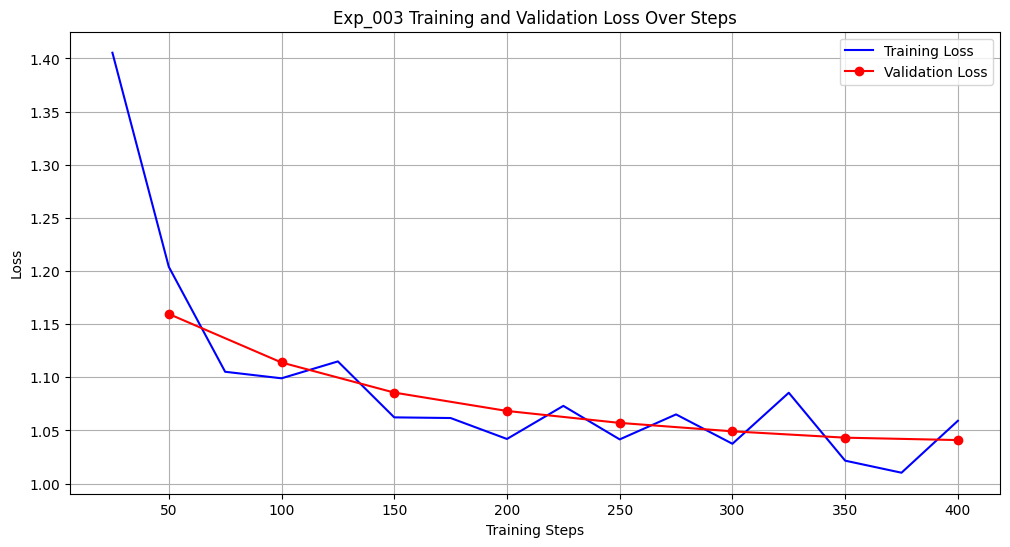


--- Exp_003 Training Performance Summary ---
Initial Training Loss: 1.4053
Final Training Loss: 1.0591
Initial Validation Loss: 1.1596
Final Validation Loss: 1.0409
Best Validation Loss: 1.0409 at step 400

--- Analysis for Overfitting/Underfitting ---
Training appears relatively stable: Training and validation losses are converging or show reasonable trends.
Consider longer training or further hyperparameter tuning for potential improvements.


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Ensure Google Drive is mounted and accessible.
# This should already be mounted from previous steps, but we'll remount to be safe.
drive.mount('/content/drive', force_remount=True)

# 2a. Define the CHECKPOINT_DIR
CHECKPOINT_DIR = "/content/drive/MyDrive/llm_checkpoints 3/exp_003"

# Helper function to find trainer_state.json
def find_trainer_state_file(base_path):
    for root, dirs, files in os.walk(base_path):
        if "trainer_state.json" in files:
            return os.path.join(root, "trainer_state.json")
    return None

# 2b & 2c. Search for, load, and parse the trainer_state.json file
trainer_state_path = find_trainer_state_file(CHECKPOINT_DIR)

if trainer_state_path:
    print(f"Found trainer_state.json at: {trainer_state_path}")
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)

    # 2d. Extract the log_history
    log_history = trainer_state.get("log_history", [])
    if not log_history:
        print("Log history is empty. Cannot plot training performance.")
    else:
        # Convert log_history to a pandas DataFrame
        df_logs = pd.DataFrame(log_history)

        # Filter for training and evaluation logs
        train_logs = df_logs[df_logs['loss'].notna()]
        eval_logs = df_logs[df_logs['eval_loss'].notna()]

        if train_logs.empty and eval_logs.empty:
            print("No valid training or evaluation logs found to plot.")
        else:
            # 2e. Create and display a plot of training loss and validation loss
            plt.figure(figsize=(12, 6))

            if not train_logs.empty:
                plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss', color='blue')
            if not eval_logs.empty:
                plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss', color='red', marker='o')

            plt.title('Exp_003 Training and Validation Loss Over Steps')
            plt.xlabel('Training Steps')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

            # 2f. Print a summary of the training log and perform basic analysis
            print("\n--- Exp_003 Training Performance Summary ---")
            if not train_logs.empty:
                print(f"Initial Training Loss: {train_logs['loss'].iloc[0]:.4f}")
                print(f"Final Training Loss: {train_logs['loss'].iloc[-1]:.4f}")
            else:
                print("No training loss data available.")

            if not eval_logs.empty:
                print(f"Initial Validation Loss: {eval_logs['eval_loss'].iloc[0]:.4f}")
                print(f"Final Validation Loss: {eval_logs['eval_loss'].iloc[-1]:.4f}")
                print(f"Best Validation Loss: {eval_logs['eval_loss'].min():.4f} at step {eval_logs.loc[eval_logs['eval_loss'].idxmin(), 'step']}")
            else:
                print("No validation loss data available.")

            print("\n--- Analysis for Overfitting/Underfitting ---")

            if not train_logs.empty and not eval_logs.empty:
                final_train_loss = train_logs['loss'].iloc[-1]
                final_val_loss = eval_logs['eval_loss'].iloc[-1]
                best_val_loss = eval_logs['eval_loss'].min()

                if final_val_loss > final_train_loss and final_val_loss > best_val_loss * 1.05: # Check for a significant increase
                    print("Potential overfitting detected: Validation loss increased towards the end of training while training loss continued to decrease.")
                    print(f"Final Training Loss ({final_train_loss:.4f}) is significantly lower than Final Validation Loss ({final_val_loss:.4f}).")
                elif final_train_loss > 1.5 and final_val_loss > 1.5: # Example threshold for 'high' loss
                    print("Potential underfitting: Both training and validation losses remain high.")
                else:
                    print("Training appears relatively stable: Training and validation losses are converging or show reasonable trends.")
                    print("Consider longer training or further hyperparameter tuning for potential improvements.")
            else:
                print("Insufficient data (training and/or validation logs) to perform detailed overfitting/underfitting analysis.")

else:
    print(f"Error: trainer_state.json not found in {CHECKPOINT_DIR} or its subdirectories.")
    print("Please ensure Exp_003 training completed successfully and generated the log file.")

## Prepare for Human Evaluation (Baseline vs. Exp_003)


In [ ]:
import pandas as pd
import numpy as np
import os

# Ensure comparison_df_full is available from previous steps
# (It should be in memory after cell ad4b5dad or 461670b2)

# 1. Calculate performance differences (Exp_003 vs. Baseline)
# A positive value means Exp_003 is better, negative means baseline is better.
comparison_df_full['ROUGE-L_F_Exp003_vs_Baseline'] = comparison_df_full['Exp003_ROUGE-L_F'] - comparison_df_full['Baseline_ROUGE-L_F']
comparison_df_full['F1_Score_Exp003_vs_Baseline'] = comparison_df_full['Exp003_F1_Score'] - comparison_df_full['Baseline_F1_Score']

# Combine these differences for a general performance indicator (e.g., mean difference)
comparison_df_full['Avg_Performance_Diff'] = (comparison_df_full['ROUGE-L_F_Exp003_vs_Baseline'] + comparison_df_full['F1_Score_Exp003_vs_Baseline']) / 2

# 2. Categorize examples based on performance
# Define thresholds for 'better', 'worse', 'similar'
# A small epsilon to account for floating point inaccuracies and minor differences
EPSILON = 0.01 # e.g., a 1% difference in score

better_exp003 = comparison_df_full[comparison_df_full['Avg_Performance_Diff'] > EPSILON]
worse_exp003 = comparison_df_full[comparison_df_full['Avg_Performance_Diff'] < -EPSILON]
similar_performance = comparison_df_full[
    (comparison_df_full['Avg_Performance_Diff'] >= -EPSILON) &
    (comparison_df_full['Avg_Performance_Diff'] <= EPSILON)
]

print(f"Examples where Exp_003 is significantly better: {len(better_exp003)}")
print(f"Examples where Exp_003 is significantly worse: {len(worse_exp003)}")
print(f"Examples with similar performance: {len(similar_performance)}")

# 3. Sample from each category to ensure diversity (aim for 50-100 questions total)
sample_size_per_category = 25 # This will give 75 samples

human_eval_samples = []

# Sample from 'better' category
if not better_exp003.empty:
    human_eval_samples.append(better_exp003.sample(n=min(sample_size_per_category, len(better_exp003)), random_state=42))

# Sample from 'worse' category
if not worse_exp003.empty:
    human_eval_samples.append(worse_exp003.sample(n=min(sample_size_per_category, len(worse_exp003)), random_state=42))

# Sample from 'similar' category
if not similar_performance.empty:
    human_eval_samples.append(similar_performance.sample(n=min(sample_size_per_category, len(similar_performance)), random_state=42))

# Concatenate the samples into a single DataFrame
human_eval_subset_df = pd.concat(human_eval_samples).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTotal {len(human_eval_subset_df)} questions selected for human evaluation.")

# 4. Extract required columns
human_eval_subset_df = human_eval_subset_df[[
    'Instruction',
    'Reference_Response',
    'Baseline_Generated_Response',
    'Exp003_Generated_Response'
]]

# Display first few rows of the subset
print("\nFirst 5 rows of human_eval_subset_df:")
print(human_eval_subset_df.head())

# 5. Save this human_eval_subset_df to a pickle file
human_eval_subset_df.to_pickle('human_eval_subset.pkl')
print("\nhuman_eval_subset_df saved to 'human_eval_subset.pkl'")

Examples where Exp_003 is significantly better: 608
Examples where Exp_003 is significantly worse: 660
Examples with similar performance: 545

Total 75 questions selected for human evaluation.

First 5 rows of human_eval_subset_df:
                                         Instruction  \
0  what research (or clinical trials) is being do...   
1             Is Usher syndrome, type 1C inherited ?   
2              What is (are) Pitt-Hopkins syndrome ?   
3            What are the treatments for Cirrhosis ?   
4                           What causes Vasculitis ?   

                                  Reference_Response  \
0  Check the list of NCI-supported cancer clinica...   
1  How is Usher syndrome inherited? Usher syndrom...   
2  Pitt-Hopkins syndrome is a condition character...   
3  Treatment for cirrhosis depends on the cause o...   
4  Vasculitis occurs if your immune system attack...   

                         Baseline_Generated_Response  \
0  The research being done for Childho

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os

# 1. Load the tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token if it doesn't exist and set padding_side
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

print(f"Tokenizer for {model_name} loaded successfully. Padding token: {tokenizer.pad_token}, Padding side: {tokenizer.padding_side}")

# 2. Define base model name and device
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# 3. Initialize BitsAndBytesConfig for 4-bit quantization (if CUDA is available)
quantization_config_inference = None
model_load_dtype = torch.float32 # Default to float32 if CUDA not available

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config_inference = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model_load_dtype = torch.bfloat16 # Model will internally use bfloat16 for compute
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config_inference,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during base model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        model_load_dtype = torch.bfloat16
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model_inference = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 4. Define and load the fine-tuned LoRA adapters for Exp_003
lora_adapter_path = os.path.join("/content/drive/MyDrive/llm_checkpoints 3/exp_003", "final_lora_adapters")
print(f"Loading LoRA adapters from: {lora_adapter_path}")

fine_tuned_model = PeftModel.from_pretrained(base_model_inference, lora_adapter_path)

# 5. Merge the LoRA adapters into the base model
print("Merging LoRA adapters into the base model...")
fine_tuned_model = fine_tuned_model.merge_and_unload()

# 6. Set the merged model to evaluation mode
fine_tuned_model.eval()
print("LoRA adapters merged and model set to evaluation mode.")

print("Fine-tuned model for inference successfully loaded and prepared.")

Tokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0 loaded successfully. Padding token: </s>, Padding side: left
Using device for model loading: cuda
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.
Loading LoRA adapters from: /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters
Merging LoRA adapters into the base model...


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


LoRA adapters merged and model set to evaluation mode.
Fine-tuned model for inference successfully loaded and prepared.


## Update Gradio Prediction Function with More Robust Cleaning


In [ ]:
import torch
import re # Ensure re is imported if not already in global scope

# Assuming fine_tuned_model and tokenizer are already loaded from previous steps
# fine_tuned_model: The PEFT model with merged adapters
# tokenizer: The AutoTokenizer for TinyLlama

def predict_gradio(instruction, max_new_tokens=256):
    # Construct the full prompt string
    prompt_text = f"""### Instruction:\n{instruction}\n\n### Response:"""

    # Tokenize the input prompt
    encoded_input = tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=512, # Use the same max_length as during training input
        return_attention_mask=True
    )
    input_ids = encoded_input['input_ids'].to(fine_tuned_model.device)
    attention_mask = encoded_input['attention_mask'].to(fine_tuned_model.device)

    # Generate response using the fine-tuned model
    with torch.no_grad():
        output_ids = fine_tuned_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False, # Use greedy decoding for consistent output
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the generated output, excluding the input prompt tokens
    generated_text = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True).strip()

    # --- Start of Robust Post-processing ---
    cleaned_text = generated_text

    # 1. Remove ### Instruction: ... ### Response: blocks, if they appear anywhere
    # This covers cases where the model might generate the full template within its response
    # Using re.DOTALL to match across newlines.
    # Using a non-greedy match (.*?) to match the smallest possible string.
    # The first pattern removes the full instruction/response block if it appears.
    cleaned_text = re.sub(r"###\s*Instruction:.*?###\s*Response:", "", cleaned_text, flags=re.DOTALL)

    # 2. Remove any remaining standalone ### Instruction: tags without a corresponding Response:
    cleaned_text = re.sub(r"###\s*Instruction:.*?(?=\n|$)", "", cleaned_text, flags=re.DOTALL)

    # 3. Remove any remaining standalone ### Response: tags
    cleaned_text = re.sub(r"###\s*Response:", "", cleaned_text, flags=re.DOTALL)

    # 4. Remove any redundant ### delimiters that might appear (e.g., from partial generations or quirks)
    # This catches isolated '###' or multiple '###' without 'Instruction'/'Response' context
    cleaned_text = re.sub(r"###+", "", cleaned_text)

    # 5. Clean up excessive whitespace and strip any leading/trailing whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # --- End of Robust Post-processing ---

    return cleaned_text

print("Gradio prediction function 'predict_gradio' updated with even more robust cleaning successfully.")

Gradio prediction function 'predict_gradio' updated with even more robust cleaning successfully.


In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the path to the 'final_lora_adapters' directory for Exp_003
lora_adapter_path = os.path.join('/content/drive/MyDrive/llm_checkpoints 3/exp_003', 'final_lora_adapters')

print(f"Google Drive mounted and LoRA adapter path defined: {lora_adapter_path}")

Mounted at /content/drive
Google Drive mounted and LoRA adapter path defined: /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters


In [ ]:
import torch
import re # Ensure re is imported if not already in global scope

# Assuming fine_tuned_model and tokenizer are already loaded from previous steps
# fine_tuned_model: The PEFT model with merged adapters
# tokenizer: The AutoTokenizer for TinyLlama

def predict_gradio(instruction, max_new_tokens=256):
    # Construct the full prompt string
    prompt_text = f"""### Instruction:\n{instruction}\n\n### Response:"""

    # Tokenize the input prompt
    encoded_input = tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=512, # Use the same max_length as during training input
        return_attention_mask=True
    )
    input_ids = encoded_input['input_ids'].to(fine_tuned_model.device)
    attention_mask = encoded_input['attention_mask'].to(fine_tuned_model.device)

    # Generate response using the fine-tuned model
    with torch.no_grad():
        output_ids = fine_tuned_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False, # Use greedy decoding for consistent output
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the generated output, excluding the input prompt tokens
    generated_text = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True).strip()

    # --- Start of Robust Post-processing ---
    cleaned_text = generated_text

    # 1. Remove ### Instruction: ... ### Response: blocks, if they appear anywhere
    # This covers cases where the model might generate the full template within its response
    # Using re.DOTALL to match across newlines.
    # Using a non-greedy match (.*?) to match the smallest possible string.
    # The first pattern removes the full instruction/response block if it appears.
    cleaned_text = re.sub(r"###\s*Instruction:.*?###\s*Response:", "", cleaned_text, flags=re.DOTALL)

    # 2. Remove any remaining standalone ### Instruction: tags without a corresponding Response:
    cleaned_text = re.sub(r"###\s*Instruction:.*?(?=\n|$)", "", cleaned_text, flags=re.DOTALL)

    # 3. Remove any remaining standalone ### Response: tags
    cleaned_text = re.sub(r"###\s*Response:", "", cleaned_text, flags=re.DOTALL)

    # 4. Remove any redundant ### delimiters that might appear (e.g., from partial generations or quirks)
    # This catches isolated '###' or multiple '###' without 'Instruction'/'Response' context
    cleaned_text = re.sub(r"###+", "", cleaned_text)

    # 5. Clean up excessive whitespace and strip any leading/trailing whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # --- End of Robust Post-processing ---

    return cleaned_text

print("Gradio prediction function 'predict_gradio' updated with even more robust cleaning successfully.")

Gradio prediction function 'predict_gradio' updated with even more robust cleaning successfully.


In [ ]:
import gradio as gr

# Assuming predict_gradio function is defined and fine_tuned_model, tokenizer are loaded.

# Define the Gradio interface
iface = gr.Interface(
    fn=predict_gradio, # The prediction function defined previously
    inputs=gr.Textbox(lines=5, placeholder="Enter your medical question here..."), # Input textbox for the question
    outputs=gr.Textbox(lines=10, label="Generated Answer"), # Output textbox for the answer
    title="TinyLlama-1.1B Fine-tuned for Medical QA #Exp 3",
    description="Ask any medical question and get a response from the fine-tuned TinyLlama model. Please note: This model is for informational purposes only and should not be used as medical advice.",
    flagging_mode="manual", # Updated from allow_flagging to flagging_mode
    # Examples (optional, can be generated dynamically or hardcoded)
    examples=[
        ["What are the symptoms of diabetes?"],
        ["What causes high blood pressure?"],
        ["What is (are) Glaucoma ?"],
        ["What are the treatments for Hypotrichosis simplex ?"],
    ]
)

# Launch the Gradio interface
print("Launching Gradio interface...")
iface.launch(share=True) # share=True to create a public link, useful for Colab

Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://79ba1e59522eb1f9e1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Authenticate Hugging Face

In [ ]:
import huggingface_hub

# Authenticate with Hugging Face
huggingface_hub.login()

print("Hugging Face authentication initiated. Please follow the prompts.")

Hugging Face authentication initiated. Please follow the prompts.


In [ ]:
import huggingface_hub
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os

# --- Re-initialize tokenizer and model (copied from cell 8001b7c2) ---
# 1. Load the tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add a padding token if it doesn't exist and set padding_side
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

print(f"Tokenizer for {model_name} loaded successfully. Padding token: {tokenizer.pad_token}, Padding side: {tokenizer.padding_side}")

# 2. Define base model name and device
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# 3. Initialize BitsAndBytesConfig for 4-bit quantization (if CUDA is available)
quantization_config_inference = None
model_load_dtype = torch.float32 # Default to float32 if CUDA not available

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config_inference = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model_load_dtype = torch.bfloat16 # Model will internally use bfloat16 for compute
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config_inference,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during base model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        base_model_inference = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        model_load_dtype = torch.bfloat16
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model_inference = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 4. Define and load the fine-tuned LoRA adapters for Exp_003
# Make sure lora_adapter_path is defined if running this cell independently
if 'lora_adapter_path' not in globals():
    lora_adapter_path = os.path.join("/content/drive/MyDrive/llm_checkpoints 3/exp_003", "final_lora_adapters")
print(f"Loading LoRA adapters from: {lora_adapter_path}")

fine_tuned_model = PeftModel.from_pretrained(base_model_inference, lora_adapter_path)

# 5. Merge the LoRA adapters into the base model
print("Merging LoRA adapters into the base model...")
fine_tuned_model = fine_tuned_model.merge_and_unload()

# 6. Set the merged model to evaluation mode
fine_tuned_model.eval()
print("LoRA adapters merged and model set to evaluation mode.")

# --- End Re-initialization ---

# Define your Hugging Face Hub repository name
hf_repo_id = "Jeanrobert/tinyllama-medqa-exp003"

print(f"Pushing model to Hugging Face Hub: {hf_repo_id}")

# Push the merged model to the Hugging Face Hub
fine_tuned_model.push_to_hub(hf_repo_id)

# Push the tokenizer as well, if it was modified or to ensure consistency
tokenizer.push_to_hub(hf_repo_id)

print("Model and tokenizer successfully pushed to Hugging Face Hub.")

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0 loaded successfully. Padding token: </s>, Padding side: left
Using device for model loading: cpu
CUDA not available. Loading base model in full float32 precision.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading LoRA adapters from: /content/drive/MyDrive/llm_checkpoints 3/exp_003/final_lora_adapters


Merging LoRA adapters into the base model...
LoRA adapters merged and model set to evaluation mode.
Pushing model to Hugging Face Hub: Jeanrobert/tinyllama-medqa-exp003


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...a5vmpq_/model.safetensors:   1%|          | 33.5MB / 4.40GB            

README.md: 0.00B [00:00, ?B/s]

Model and tokenizer successfully pushed to Hugging Face Hub.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1. Define the Hugging Face repository ID for the merged model
hf_repo_id = "Jeanrobert/tinyllama-medqa-exp003"

# 2. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(hf_repo_id)

# 3. Add a padding token and set padding_side
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

print(f"Tokenizer for {hf_repo_id} loaded successfully. Padding token: {tokenizer.pad_token}, Padding side: {tokenizer.padding_side}")

# 4. Load the merged model directly from Hugging Face Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

model = AutoModelForCausalLM.from_pretrained(
    hf_repo_id,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32, # Use bfloat16 if CUDA is available, else float32
    device_map="auto"
)

# 5. Set the model to evaluation mode
model.eval()

print(f"Model {hf_repo_id} loaded successfully and set to evaluation mode.")

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.jinja:   0%|          | 0.00/410 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Tokenizer for Jeanrobert/tinyllama-medqa-exp003 loaded successfully. Padding token: </s>, Padding side: left
Using device for model loading: cpu


model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

Model Jeanrobert/tinyllama-medqa-exp003 loaded successfully and set to evaluation mode.


# Exp 4

## Prepare Cleaned Datasets for Exp_004

In [ ]:
import re
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub
import os

# 1. Define a Python function `clean_response_text`
def clean_response_text(text):
    if not isinstance(text, str):
        return ""
    # Remove '### Instruction:' and everything that follows until '### Response:'
    # or end of string
    cleaned_text = re.sub(r"###\s*Instruction:.*?###\s*Response:", "", text, flags=re.DOTALL)
    # Remove any standalone '### Instruction:' or '### Response:'
    cleaned_text = re.sub(r"###\s*Instruction:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###\s*Response:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    # Remove any remaining '###' delimiters (e.g., from partial generations or quirks)
    cleaned_text = re.sub(r"###+", "", cleaned_text)
    # Remove multiple consecutive newlines and then strip leading/trailing whitespace
    cleaned_text = re.sub(r'[\r\n]+', '\n', cleaned_text).strip()
    return cleaned_text

print("Defined `clean_response_text` function.")

# 2. Load the `intronhealth/afrimedqa_v2` dataset
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')
afrimedqa_df = afrimedqa_dataset['train'].to_pandas()
print(f"Loaded intronhealth/afrimedqa_v2 dataset. Shape: {afrimedqa_df.shape}")

# 3. Download the `MedQuAD` dataset files and load `medquad.csv`
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df = pd.read_csv(medquad_csv_path)
print(f"Loaded MedQuAD dataset. Shape: {medquad_df.shape}")

print("Datasets loaded successfully, proceeding to cleaning and verification.")

Defined `clean_response_text` function.


README.md:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

afri_med_qa_15k_v2.4_phase_2_15275.csv:   0%|          | 0.00/8.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15275 [00:00<?, ? examples/s]

Loaded intronhealth/afrimedqa_v2 dataset. Shape: (15275, 29)


100%|██████████| 4.95M/4.95M [00:00<00:00, 78.2MB/s]

Extracting files...


Loaded MedQuAD dataset. Shape: (16412, 4)
Datasets loaded successfully, proceeding to cleaning and verification.


In [ ]:
import re
import pandas as pd # Already imported, but kept for clarity

# 4. Apply the `clean_response_text` function to the 'answer' column of `medquad_df`
medquad_df['cleaned_answer'] = medquad_df['answer'].apply(clean_response_text)

# Apply the `clean_response_text` function to the 'answer_rationale' column of `afrimedqa_df`.
# Handle potential None values by filling them with empty strings before cleaning.
afrimedqa_df['cleaned_answer_rationale'] = afrimedqa_df['answer_rationale'].fillna('').apply(clean_response_text)

print("Applied `clean_response_text` function to 'medquad_df' and 'afrimedqa_df'.")
print(f"New columns added to medquad_df: {'cleaned_answer' in medquad_df.columns}")
print(f"New columns added to afrimedqa_df: {'cleaned_answer_rationale' in afrimedqa_df.columns}")

Applied `clean_response_text` function to 'medquad_df' and 'afrimedqa_df'.
New columns added to medquad_df: True
New columns added to afrimedqa_df: True


In [ ]:
import pandas as pd # Already imported, but kept for clarity

# 5. Print 5 random examples for medquad_df to verify cleaning
print("\n--- MedQuAD: Raw vs. Cleaned Answer Examples ---")
for i in range(5):
    # Sample a random row
    sample_row = medquad_df.sample(n=1, random_state=42 + i) # Use different seed for each sample
    original_answer = sample_row['answer'].iloc[0]
    cleaned_answer = sample_row['cleaned_answer'].iloc[0]

    print(f"\nExample {i+1}:")
    print(f"  Raw Answer:     {original_answer[:300]}...")
    print(f"  Cleaned Answer: {cleaned_answer[:300]}...")
    print("---------------------------------------------------")

# 5. Print 5 random examples for afrimedqa_df to verify cleaning
print("\n--- AfrimedQA_v2: Raw vs. Cleaned Answer Rationale Examples ---")
for i in range(5):
    # Sample a random row
    sample_row = afrimedqa_df.sample(n=1, random_state=42 + i) # Use different seed for each sample
    original_rationale = sample_row['answer_rationale'].iloc[0] # This can be None
    cleaned_rationale = sample_row['cleaned_answer_rationale'].iloc[0]

    print(f"\nExample {i+1}:")
    print(f"  Raw Rationale:     {str(original_rationale)[:300]}...") # Convert to string for safety
    print(f"  Cleaned Rationale: {cleaned_rationale[:300]}...")
    print("---------------------------------------------------")


--- MedQuAD: Raw vs. Cleaned Answer Examples ---

Example 1:
  Raw Answer:     LBSL is caused by mutations in the DARS2 gene, which provides instructions for making an enzyme called mitochondrial aspartyl-tRNA synthetase. This enzyme is important in the production (synthesis) of proteins in cellular structures called mitochondria, the energy-producing centers in cells. While m...
  Cleaned Answer: LBSL is caused by mutations in the DARS2 gene, which provides instructions for making an enzyme called mitochondrial aspartyl-tRNA synthetase. This enzyme is important in the production (synthesis) of proteins in cellular structures called mitochondria, the energy-producing centers in cells. While m...
---------------------------------------------------

Example 2:
  Raw Answer:     NINDS conducts and supports research on disorders of the spinal cord such as spinal cord infarction, aimed at learning more about these disorders and finding ways to prevent and treat them....
  Cleaned Answer: N

In [ ]:
from datasets import Dataset, DatasetDict, concatenate_datasets

# 6. Convert the cleaned `medquad_df` into a Hugging Face `Dataset`
# Use 'question' as 'instruction' and 'cleaned_answer' as 'response'
medquad_qa_dataset = Dataset.from_pandas(medquad_df[['question', 'cleaned_answer']].rename(columns={'question': 'instruction', 'cleaned_answer': 'response'}))
print("MedQuAD cleaned dataset converted to unified QA format successfully:")
print(medquad_qa_dataset)

# 7. Convert the cleaned `afrimedqa_df` into a Hugging Face `Dataset`
# Use 'question' as 'instruction' and 'cleaned_answer_rationale' as 'response'
afrimedqa_qa_dataset = Dataset.from_pandas(afrimedqa_df[['question', 'cleaned_answer_rationale']].rename(columns={'question': 'instruction', 'cleaned_answer_rationale': 'response'}))
print("AfrimedQA_v2 cleaned dataset converted to unified QA format successfully:")
print(afrimedqa_qa_dataset)

# 8. Concatenate `medquad_qa_dataset` and `afrimedqa_qa_dataset` into a single `unified_dataset`
unified_dataset_cleaned = concatenate_datasets([medquad_qa_dataset, afrimedqa_qa_dataset])
print("\nUnified cleaned dataset created successfully:")
print(unified_dataset_cleaned)

# 9. Filter `unified_dataset` to remove any entries where the 'instruction' or 'response' are empty or contain only whitespace.
initial_num_rows_cleaned = len(unified_dataset_cleaned)
unified_dataset_cleaned = unified_dataset_cleaned.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')
cleaned_num_rows_final = len(unified_dataset_cleaned)

print(f"\nRemoved {initial_num_rows_cleaned - cleaned_num_rows_final} entries due to empty instruction or response after cleaning.")
print(f"Unified dataset after final cleaning: {unified_dataset_cleaned}")

# 10. Split the cleaned and unified `Dataset` into training, validation, and test sets
# Shuffle with a fixed seed (e.g., 42) for reproducibility
shuffled_dataset_cleaned = unified_dataset_cleaned.shuffle(seed=42)

train_test_split_cleaned = shuffled_dataset_cleaned.train_test_split(test_size=0.2, seed=42)
val_test_split_cleaned = train_test_split_cleaned['test'].train_test_split(test_size=0.5, seed=42)

train_val_test_dataset_cleaned = DatasetDict({
    'train': train_test_split_cleaned['train'],
    'validation': val_test_split_cleaned['train'],
    'test': val_test_split_cleaned['test']
})

print("\nCleaned unified dataset split into training, validation, and test sets successfully:")
print(train_val_test_dataset_cleaned)

print("\nSample from cleaned training set (first example):")
print(train_val_test_dataset_cleaned['train'][0])

MedQuAD cleaned dataset converted to unified QA format successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 16412
})
AfrimedQA_v2 cleaned dataset converted to unified QA format successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 15275
})

Unified cleaned dataset created successfully:
Dataset({
    features: ['instruction', 'response'],
    num_rows: 31687
})


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]


Removed 13570 entries due to empty instruction or response after cleaning.
Unified dataset after final cleaning: Dataset({
    features: ['instruction', 'response'],
    num_rows: 18117
})

Cleaned unified dataset split into training, validation, and test sets successfully:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 14493
    })
    validation: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1812
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 1812
    })
})

Sample from cleaned training set (first example):
{'instruction': 'What are the treatments for Parasites - Lymphatic Filariasis ?', 'response': 'Patients currently infected with the parasite\n    \nDiethylcarbamazine (DEC) is the drug of choice in the United States. The drug kills the microfilaria and some of the adult worms. DEC has been used world-wide for more than 50 years. Because this infection is 

In [ ]:
from transformers import AutoTokenizer
import torch

# Assuming train_val_test_dataset_cleaned is available from previous steps (cell 64f9affd)

# 1. Load the AutoTokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Add a padding token if it doesn't exist and set padding_side
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

print(f"Tokenizer for {model_name} loaded successfully. Padding token: {tokenizer.pad_token}, Padding side: {tokenizer.padding_side}")

# 3. Define a Python function, `prepare_for_training`
def prepare_for_training(examples, tokenizer, max_length=512):
    # This function is now designed to handle a batch of examples.
    # `examples` will be a dictionary where values are lists (e.g., {'instruction': ['instr1', 'instr2'], 'response': ['resp1', 'resp2']})

    batch_input_ids = []
    batch_attention_mask = []
    batch_labels = []

    for instruction, response in zip(examples['instruction'], examples['response']):
        full_prompt = f"""### Instruction:\n{instruction}\n\n### Response:\n{response}"""
        instruction_only_prompt = f"""### Instruction:\n{instruction}\n\n### Response:"""

        # Tokenize the full prompt string for this single example
        tokenized_full_prompt = tokenizer(
            full_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        # Tokenize only the instruction part for this single example
        tokenized_instruction_only = tokenizer(
            instruction_only_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        # Create labels by copying input_ids
        labels = tokenized_full_prompt['input_ids'].clone()

        # Mask out the tokens corresponding to the instruction part
        # Ensure it's a 1D tensor before calculating sum
        instruction_len_unpadded = (tokenized_instruction_only['input_ids'][0] != tokenizer.pad_token_id).sum().item()
        labels[0, :instruction_len_unpadded] = -100

        # Append the results for this example to the batch lists
        batch_input_ids.append(tokenized_full_prompt['input_ids'][0].tolist())
        batch_attention_mask.append(tokenized_full_prompt['attention_mask'][0].tolist())
        batch_labels.append(labels[0].tolist())

    # Return a dictionary where each value is a list of results for the batch
    return {
        'input_ids': batch_input_ids,
        'attention_mask': batch_attention_mask,
        'labels': batch_labels
    }

# 4. Apply this `prepare_for_training` function to all splits
print("Applying `prepare_for_training` function to dataset splits...")
tokenized_dataset_cleaned = train_val_test_dataset_cleaned.map(
    lambda examples: prepare_for_training(examples, tokenizer, max_length=512),
    batched=True,
    remove_columns=['instruction', 'response'] # Remove original text columns after tokenization
)

print("Dataset splits tokenized and prepared for training with label shifting.")
print("Sample from tokenized_dataset_cleaned (train split, first example): ")
print(tokenized_dataset_cleaned['train'][0].keys())
print(f"Length of input_ids: {len(tokenized_dataset_cleaned['train'][0]['input_ids'])}")
print(f"Length of labels: {len(tokenized_dataset_cleaned['train'][0]['labels'])}")
print("First 20 labels (should show -100 for instruction part):")
print(tokenized_dataset_cleaned['train'][0]['labels'][:20])

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer for TinyLlama/TinyLlama-1.1B-Chat-v1.0 loaded successfully. Padding token: </s>, Padding side: left
Applying `prepare_for_training` function to dataset splits...


Map:   0%|          | 0/14493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Dataset splits tokenized and prepared for training with label shifting.
Sample from tokenized_dataset_cleaned (train split, first example): 
dict_keys(['input_ids', 'attention_mask', 'labels'])
Length of input_ids: 512
Length of labels: 512
First 20 labels (should show -100 for instruction part):
[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


## Load Base Model and PEFT Setup for Exp_004


In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

# 1. Define the base model name
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for Exp_004 model loading: {device}")

# 2. Check if CUDA is available and instantiate BitsAndBytesConfig for 4-bit quantization
model = None
quantization_config = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization for Exp_004.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16, # Use bfloat16 for quantized model on CUDA
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization for Exp_004.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during Exp_004 model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        # If 4-bit fails, load without quantization, but still use bfloat16 if CUDA is available
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision for Exp_004.")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 3. Define the target_modules for LoRA
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# 4. Instantiate LoraConfig
lora_config = LoraConfig(
    r=8,  # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    target_modules=target_modules, # Modules to apply LoRA to
    lora_dropout=0.05, # Dropout probability for LoRA layers
    bias="none", # Bias type for LoRA layers
    task_type=TaskType.CAUSAL_LM # Task type for causal language modeling
)

# 5. Apply the LoRA configuration to the base model
peft_model = get_peft_model(model, lora_config)

# 6. Print the trainable parameter summary
print("\nPEFT model summary for Exp_004:")
peft_model.print_trainable_parameters()

print("\nBase model and PEFT setup configured successfully for Exp_004.")

Using device for Exp_004 model loading: cuda


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


PEFT model summary for Exp_004:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701

Base model and PEFT setup configured successfully for Exp_004.


## Execute Fine-tuning Experiment 4 (Exp_004)


In [ ]:
import os
import time
import torch
import json
import pandas as pd
from google.colab import drive
import huggingface_hub # Import huggingface_hub for login

# Install bitsandbytes for 4-bit quantization if not already installed
# This addresses the 'No module named 'bitsandbytes'' warning
!pip install -qqq bitsandbytes

# Re-import necessary libraries if not already in current kernel state
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import kagglehub

# 1. Ensure Google Drive is mounted for persistent checkpoint storage
drive.mount('/content/drive', force_remount=True)

# Log in to the Hugging Face Hub if necessary (will prompt for token if not logged in)
huggingface_hub.login()

# --- Re-create `tokenizer` and `tokenized_dataset_cleaned` if not available --- #
# This ensures the cell is self-contained if run out of order

# Load the tokenizer (from cell af1d0476)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Or tokenizer.eos_token
tokenizer.padding_side = 'left' # Set padding side to 'left' for decoder-only models during generation

# Re-define `clean_response_text` function (from cell e49dd804)
def clean_response_text(text):
    if not isinstance(text, str):
        return ""
    cleaned_text = re.sub(r"###\s*Instruction:.*?###\s*Response:", "", text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###\s*Instruction:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###\s*Response:\n*(.*)", r"\1", cleaned_text, flags=re.DOTALL)
    cleaned_text = re.sub(r"###+", "", cleaned_text)
    cleaned_text = re.sub(r'[\r\n]+', '\n', cleaned_text).strip()
    return cleaned_text

# Load and clean datasets (from cells e49dd804, c08853ca, 64f9affd)
# Load `intronhealth/afrimedqa_v2`
afrimedqa_dataset = load_dataset('intronhealth/afrimedqa_v2')
afrimedqa_df_temp = afrimedqa_dataset['train'].to_pandas()
afrimedqa_df_temp['cleaned_answer_rationale'] = afrimedqa_df_temp['answer_rationale'].fillna('').apply(clean_response_text)

# Download `MedQuAD` dataset files and load `medquad.csv`
medquad_download_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")
medquad_csv_path = os.path.join(medquad_download_path, 'medquad.csv')
medquad_df_temp = pd.read_csv(medquad_csv_path)
medquad_df_temp['cleaned_answer'] = medquad_df_temp['answer'].apply(clean_response_text)

# Convert to unified QA format and concatenate
medquad_qa_dataset_temp = Dataset.from_pandas(medquad_df_temp[['question', 'cleaned_answer']].rename(columns={'question': 'instruction', 'cleaned_answer': 'response'}))
afrimedqa_qa_dataset_temp = Dataset.from_pandas(afrimedqa_df_temp[['question', 'cleaned_answer_rationale']].rename(columns={'question': 'instruction', 'cleaned_answer_rationale': 'response'}))
unified_dataset_cleaned_temp = concatenate_datasets([medquad_qa_dataset_temp, afrimedqa_qa_dataset_temp])
unified_dataset_cleaned_temp = unified_dataset_cleaned_temp.filter(lambda example: example['instruction'].strip() != '' and example['response'].strip() != '')

# Split the cleaned and unified `Dataset`
shuffled_dataset_cleaned_temp = unified_dataset_cleaned_temp.shuffle(seed=42)
train_test_split_cleaned_temp = shuffled_dataset_cleaned_temp.train_test_split(test_size=0.2, seed=42)
val_test_split_cleaned_temp = train_test_split_cleaned_temp['test'].train_test_split(test_size=0.5, seed=42)

train_val_test_dataset_cleaned = DatasetDict({
    'train': train_test_split_cleaned_temp['train'],
    'validation': val_test_split_cleaned_temp['train'],
    'test': val_test_split_cleaned_temp['test']
})

# Re-define `prepare_for_training` function (from cell af1d0476)
def prepare_for_training(examples, tokenizer, max_length=512):
    batch_input_ids = []
    batch_attention_mask = []
    batch_labels = []

    for instruction, response in zip(examples['instruction'], examples['response']):
        full_prompt = f"""### Instruction:\n{instruction}\n\n### Response:\n{response}"""
        instruction_only_prompt = f"""### Instruction:\n{instruction}\n\n### Response:"""

        tokenized_full_prompt = tokenizer(
            full_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        tokenized_instruction_only = tokenizer(
            instruction_only_prompt,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        labels = tokenized_full_prompt['input_ids'].clone()
        instruction_len_unpadded = (tokenized_instruction_only['input_ids'][0] != tokenizer.pad_token_id).sum().item()
        labels[0, :instruction_len_unpadded] = -100

        batch_input_ids.append(tokenized_full_prompt['input_ids'][0].tolist())
        batch_attention_mask.append(tokenized_full_prompt['attention_mask'][0].tolist())
        batch_labels.append(labels[0].tolist())

    return {
        'input_ids': batch_input_ids,
        'attention_mask': batch_attention_mask,
        'labels': batch_labels
    }

# Apply tokenization with label shifting
tokenized_dataset_cleaned = train_val_test_dataset_cleaned.map(
    lambda examples: prepare_for_training(examples, tokenizer, max_length=512),
    batched=True,
    remove_columns=['instruction', 'response'] # Remove original text columns after tokenization
)

# --- End re-creation of `tokenizer` and `tokenized_dataset_cleaned` --- #

# --- Re-create `peft_model` if not available --- #

# Load the base model (from cell 9f261673)
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = None
quantization_config = None

if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization for Exp_004.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization for Exp_004.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during Exp_004 model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision for Exp_004.")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# Set use_cache to False for gradient checkpointing
model.config.use_cache = False

# Define the target_modules for LoRA
target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# Instantiate LoraConfig
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply the LoRA configuration to the base model
peft_model = get_peft_model(model, lora_config)
print("\nPEFT model summary for Exp_004:")
peft_model.print_trainable_parameters()

# --- End re-creation of `peft_model` --- #

# 2. Define experiment-specific parameters for Exp_004
EXPERIMENT_ID = "Exp_004"
LEARNING_RATE = 2e-4
PER_DEVICE_BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4
MAX_STEPS = 400 # As per the updated instruction
OPTIMIZER = "adamw_torch"
EFFECTIVE_BATCH_SIZE = PER_DEVICE_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

# 3. Set CHECKPOINT_DIR to a unique path on Google Drive
CHECKPOINT_DIR = f"/content/drive/MyDrive/llm_checkpoints 4/{EXPERIMENT_ID.lower()}"
FINAL_ADAPTER_DIR = os.path.join(CHECKPOINT_DIR, "final_lora_adapters")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

# 4. Clear the CUDA cache and reset peak memory statistics
if torch.cuda.is_available():
    print(f"CUDA available. Clearing cache and resetting peak memory stats for {EXPERIMENT_ID}...")
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_gpu_memory_allocated = torch.cuda.memory_allocated()
    print(f"Initial GPU memory allocated: {initial_gpu_memory_allocated / (1024**3):.2f} GB")
else:
    print("CUDA not available. Skipping GPU memory operations.")

# 5. Initialize `TrainingArguments` for Exp_004
training_args_exp004 = TrainingArguments(
    output_dir=CHECKPOINT_DIR,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    logging_steps=25,
    save_steps=50,
    eval_steps=50,
    eval_strategy="steps",
    bf16=model.dtype == torch.bfloat16, # Use bf16 if model was loaded with bfloat16
    fp16=False,
    gradient_checkpointing=True,
    # Add the following line to address CheckpointError with gradient_checkpointing
    gradient_checkpointing_kwargs={'use_reentrant':False},
    save_total_limit=3,
    seed=42,
    report_to="none",
    remove_unused_columns=True, # Critical for data collator compatibility
)

# Instantiate DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# 6. Re-initialize the `Trainer` instance
trainer = Trainer(
    model=peft_model,
    args=training_args_exp004,
    train_dataset=tokenized_dataset_cleaned['train'],
    eval_dataset=tokenized_dataset_cleaned['validation'],
    data_collator=data_collator,
)
print("\nTrainer initialized successfully for Exp_004.")

# 7. Implement logic to check for existing checkpoints and resume training
latest_checkpoint = None
if os.path.exists(CHECKPOINT_DIR):
    checkpoints = [os.path.join(CHECKPOINT_DIR, d)
                   for d in os.listdir(CHECKPOINT_DIR)
                   if d.startswith("checkpoint") and os.path.isdir(os.path.join(CHECKPOINT_DIR, d))]
    if checkpoints:
        checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
        latest_checkpoint = checkpoints[-1]
        print(f"Resuming training from checkpoint: {latest_checkpoint}")
    else:
        print("No existing checkpoints found. Starting new training run.")

# 8. Start a timer, then execute the training process
print(f"\nStarting training for {EXPERIMENT_ID} (auto-resume enabled)...")
start_time = time.time()
trainer.train(resume_from_checkpoint=latest_checkpoint)

# 9. Stop the timer and calculate the total training duration.
elapsed = time.time() - start_time
training_duration_hms = time.strftime('%H:%M:%S', time.gmtime(elapsed))
print(f"\nTraining for {EXPERIMENT_ID} completed in {training_duration_hms}.")

# 10. After training completes, retrieve and print the peak GPU memory usage.
peak_gpu_memory_gb = 0.0
if torch.cuda.is_available():
    peak_gpu_memory_bytes = torch.cuda.max_memory_allocated()
    if peak_gpu_memory_bytes > 0: # Only if memory was actually allocated during this run
        peak_gpu_memory_gb = peak_gpu_memory_bytes / (1024**3)
    print(f"Peak GPU memory allocated during training: {peak_gpu_memory_gb:.2f} GB")

# 11. Evaluate the model on the validation set and extract the `final_validation_loss`.
print("\nEvaluating fine-tuned model on the validation set...")
eval_results = trainer.evaluate()
final_validation_loss = eval_results['eval_loss']
print(f"Final Validation Loss: {final_validation_loss:.4f}")

# 12. Save the fine-tuned LoRA adapters for Exp_004
peft_model.save_pretrained(FINAL_ADAPTER_DIR)
print(f"\nFine-tuned LoRA adapters for {EXPERIMENT_ID} saved to: {FINAL_ADAPTER_DIR}")

# 13. Print a summary of Exp_004
print(f"\n--- Experiment Summary ({EXPERIMENT_ID} - {MAX_STEPS} Steps) ---")
print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Per Device Train Batch Size: {PER_DEVICE_BATCH_SIZE}")
print(f"Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")
print(f"Total Training Steps: {MAX_STEPS}")
print(f"Optimizer: {OPTIMIZER}")
print(f"Peak GPU Memory: {peak_gpu_memory_gb:.2f} GB")
print(f"Training Time: {training_duration_hms}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print("--------------------------------------------------")

Mounted at /content/drive
Using Colab cache for faster access to the 'medquad-medical-question-answer-for-ai-research' dataset.


Filter:   0%|          | 0/31687 [00:00<?, ? examples/s]

Map:   0%|          | 0/14493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Attempting to load base model with 4-bit quantization for Exp_004.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization for Exp_004.

PEFT model summary for Exp_004:
trainable params: 6,307,840 || all params: 1,106,356,224 || trainable%: 0.5701
Checkpoints will be saved to: /content/drive/MyDrive/llm_checkpoints 4/exp_004
CUDA available. Clearing cache and resetting peak memory stats for Exp_004...
Initial GPU memory allocated: 4.95 GB

Trainer initialized successfully for Exp_004.
Resuming training from checkpoint: /content/drive/MyDrive/llm_checkpoints 4/exp_004/checkpoint-350

Starting training for Exp_004 (auto-resume enabled)...


Step,Training Loss,Validation Loss
400,1.030306,1.065087



Training for Exp_004 completed in 01:13:27.
Peak GPU memory allocated during training: 6.43 GB

Evaluating fine-tuned model on the validation set...


Final Validation Loss: 1.0651

Fine-tuned LoRA adapters for Exp_004 saved to: /content/drive/MyDrive/llm_checkpoints 4/exp_004/final_lora_adapters

--- Experiment Summary (Exp_004 - 400 Steps) ---
Experiment ID: Exp_004
Learning Rate: 0.0002
Per Device Train Batch Size: 8
Gradient Accumulation Steps: 4
Effective Batch Size: 32
Total Training Steps: 400
Optimizer: adamw_torch
Peak GPU Memory: 6.43 GB
Training Time: 01:13:27
Final Validation Loss: 1.0651
--------------------------------------------------


Loaded training logs from: /content/drive/MyDrive/llm_checkpoints 4/exp_004/checkpoint-400/trainer_state.json


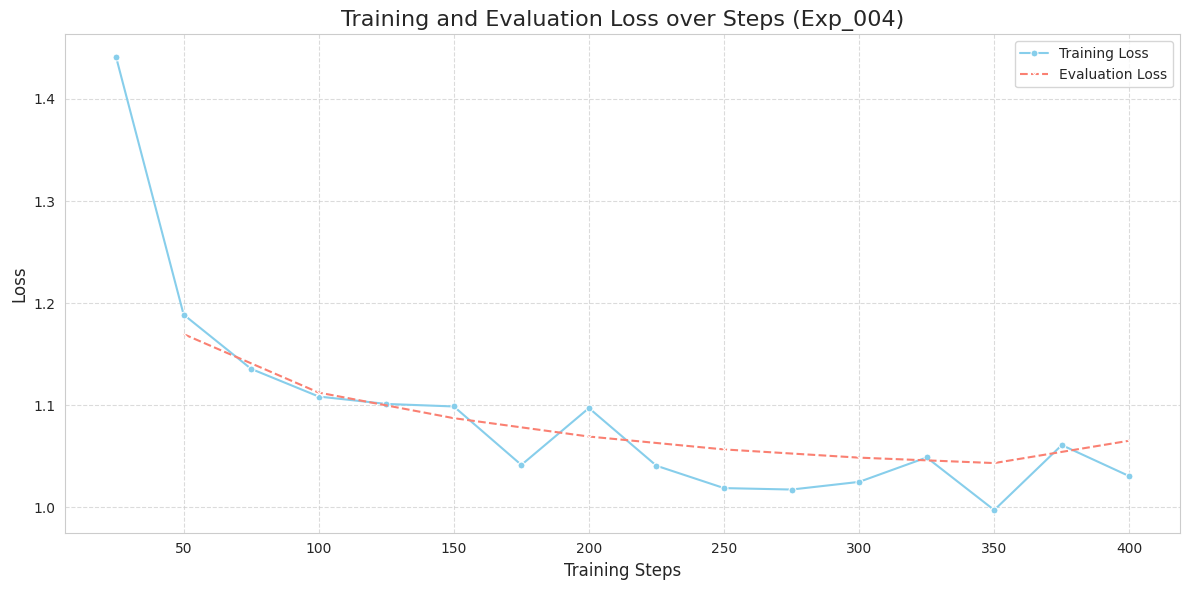

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Define the path to the trainer_state.json, looking within the latest checkpoint
# Assuming CHECKPOINT_DIR and the final checkpoint directory exist from previous steps
final_checkpoint_dir = os.path.join(CHECKPOINT_DIR, 'checkpoint-400') # Assuming 400 was the max_steps
trainer_state_path = os.path.join(final_checkpoint_dir, 'trainer_state.json')

# Load the training logs
training_logs = []
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
        training_logs = trainer_state.get('log_history', [])
    print(f"Loaded training logs from: {trainer_state_path}")
else:
    print(f"Warning: trainer_state.json not found at {trainer_state_path}. Cannot plot training history.")

# Prepare data for plotting
plot_training_steps = []
plot_training_losses = []
plot_eval_steps = []
plot_eval_losses = []

for log in training_logs:
    if 'loss' in log and log['loss'] is not None: # Training loss
        plot_training_steps.append(log['step'])
        plot_training_losses.append(log['loss'])
    if 'eval_loss' in log and log['eval_loss'] is not None: # Evaluation loss
        plot_eval_steps.append(log['step'])
        plot_eval_losses.append(log['eval_loss'])


# Plotting
if plot_training_steps or plot_eval_steps:
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    if plot_training_steps:
        sns.lineplot(x=plot_training_steps, y=plot_training_losses, label='Training Loss', marker='o', markersize=5, linestyle='-', color='skyblue')
    if plot_eval_steps:
        sns.lineplot(x=plot_eval_steps, y=plot_eval_losses, label='Evaluation Loss', marker='x', markersize=5, linestyle='--', color='salmon')

    plt.title('Training and Evaluation Loss over Steps (Exp_004)', fontsize=16)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid training or evaluation loss data found in logs to plot.")


In [ ]:
import pickle
import os

# 1. Access the 'test' split from the `train_val_test_dataset_cleaned` DatasetDict
# Assuming `train_val_test_dataset_cleaned` is available from the previous step
test_dataset_original = train_val_test_dataset_cleaned['test']
print(f"Loaded 'test' split with {len(test_dataset_original)} examples.")
print("Sample original test example:")
print(test_dataset_original[0])

# 2. Load the baseline responses from the file `/content/baseline_responses.pkl`
baseline_responses_path = '/content/baseline_responses.pkl'

if os.path.exists(baseline_responses_path):
    with open(baseline_responses_path, 'rb') as f:
        baseline_responses = pickle.load(f)
    print(f"Successfully loaded baseline responses from {baseline_responses_path}.")
    print(f"Number of baseline responses: {len(baseline_responses)}")
    print("Sample baseline response:")
    print(baseline_responses.iloc[0]) # Fixed: Use .iloc[0] for positional access
else:
    print(f"Error: Baseline responses file not found at {baseline_responses_path}.")
    baseline_responses = [] # Initialize as empty to prevent further errors

# 3. Verify that the number of baseline responses matches the number of examples in the 'test' split
if len(baseline_responses) == len(test_dataset_original):
    print("Verification successful: Number of baseline responses matches the test dataset size.")
else:
    print(f"Warning: Mismatch in count! Test dataset has {len(test_dataset_original)} examples, but baseline responses has {len(baseline_responses)}.")

Loaded 'test' split with 1812 examples.
Sample original test example:
{'instruction': 'What causes Prostate Enlargement: Benign Prostatic Hyperplasia ?', 'response': 'The cause of benign prostatic hyperplasia is not well understood; however, it occurs mainly in older men. Benign prostatic hyperplasia does not develop in men whose testicles were removed before puberty. For this reason, some researchers believe factors related to aging and the testicles may cause benign prostatic hyperplasia.\n                \nThroughout their lives, men produce testosterone, a male hormone, and small amounts of estrogen, a female hormone. As men age, the amount of active testosterone in their blood decreases, which leaves a higher proportion of estrogen. Scientific studies have suggested that benign prostatic hyperplasia may occur because the higher proportion of estrogen within the prostate increases the activity of substances that promote prostate cell growth.\n                \nAnother theory focuse

In [ ]:
import pickle
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# Assuming `train_val_test_dataset_cleaned` is available from the previous step

# 1. Access the 'test' split from the `train_val_test_dataset_cleaned` and convert it into a Pandas DataFrame
df_test_original = pd.DataFrame(train_val_test_dataset_cleaned['test'])
print(f"Loaded 'test' split into df_test_original with {len(df_test_original)} examples.")
print("Sample df_test_original example:\n", df_test_original.head(1).to_dict('records'))

# 2. Load the baseline responses from the file `/content/baseline_responses.pkl` into a Pandas DataFrame
baseline_responses_path = '/content/baseline_responses.pkl'

df_baseline_raw = pd.DataFrame()
if os.path.exists(baseline_responses_path):
    with open(baseline_responses_path, 'rb') as f:
        df_baseline_raw = pickle.load(f)
    print(f"\nSuccessfully loaded baseline responses from {baseline_responses_path} into df_baseline_raw.")
    print(f"Number of raw baseline responses: {len(df_baseline_raw)}")
    print("Sample df_baseline_raw example:\n", df_baseline_raw.head(1).to_dict('records'))
else:
    print(f"\nError: Baseline responses file not found at {baseline_responses_path}.")

# 3. Verify that df_baseline_raw contains unique 'instruction' entries and handle duplicates
initial_baseline_rows = len(df_baseline_raw)
df_baseline_raw = df_baseline_raw.drop_duplicates(subset=['instruction'], keep='first')
duplicates_removed = initial_baseline_rows - len(df_baseline_raw)
if duplicates_removed > 0:
    print(f"\nRemoved {duplicates_removed} duplicate instructions from df_baseline_raw.")
    print(f"Number of unique baseline instructions: {len(df_baseline_raw)}")

# 4. Perform an inner merge between df_test_original and df_baseline_raw on the 'instruction' column
# This ensures only instructions present in both are kept
df_aligned_data = pd.merge(
    df_test_original[['instruction', 'response']], # Only take 'instruction' and 'response' from original test set
    df_baseline_raw[['instruction', 'generated_response']], # Only take 'instruction' and 'generated_response' from baseline
    on='instruction',
    how='inner'
)

print(f"\nPerformed inner merge. Aligned dataset size: {len(df_aligned_data)}")

# 5. Verify that the number of entries in df_aligned_data matches the number of unique instructions after the merge
if len(df_aligned_data) != len(df_baseline_raw) or len(df_aligned_data) != len(df_test_original.drop_duplicates(subset=['instruction'])):
    print("Warning: Discrepancy in aligned data size or unique instruction count after merge.")

# 6. Extract the aligned original test data
test_dataset_aligned_df = df_aligned_data[['instruction', 'response']].copy()

# 7. Extract the aligned baseline responses
baseline_responses_aligned_df = df_aligned_data[['instruction', 'generated_response']].copy()

# 8. Print the lengths and display samples to verify
print(f"\nLength of test_dataset_aligned_df: {len(test_dataset_aligned_df)}")
print(f"Length of baseline_responses_aligned_df: {len(baseline_responses_aligned_df)}")

if len(test_dataset_aligned_df) == len(baseline_responses_aligned_df):
    print("Verification successful: Aligned datasets have matching lengths.")
else:
    print("Verification failed: Aligned datasets have different lengths.")

print("\nSample from test_dataset_aligned_df:")
print(test_dataset_aligned_df.head(1).to_dict('records'))

print("\nSample from baseline_responses_aligned_df:")
print(baseline_responses_aligned_df.head(1).to_dict('records'))

Loaded 'test' split into df_test_original with 1812 examples.
Sample df_test_original example:
 [{'instruction': 'What causes Prostate Enlargement: Benign Prostatic Hyperplasia ?', 'response': 'The cause of benign prostatic hyperplasia is not well understood; however, it occurs mainly in older men. Benign prostatic hyperplasia does not develop in men whose testicles were removed before puberty. For this reason, some researchers believe factors related to aging and the testicles may cause benign prostatic hyperplasia.\n                \nThroughout their lives, men produce testosterone, a male hormone, and small amounts of estrogen, a female hormone. As men age, the amount of active testosterone in their blood decreases, which leaves a higher proportion of estrogen. Scientific studies have suggested that benign prostatic hyperplasia may occur because the higher proportion of estrogen within the prostate increases the activity of substances that promote prostate cell growth.\n            

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# 1. Define the base model name
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# 2. Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model loading: {device}")

# 3. Load the base AutoModelForCausalLM
base_model = None
if torch.cuda.is_available():
    try:
        import bitsandbytes
        print("Attempting to load base model with 4-bit quantization.")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            dtype=torch.bfloat16,
            device_map="auto"
        )
        print("Base model loaded successfully with 4-bit quantization.")
    except Exception as e:
        print(f"Warning: 4-bit quantization failed during base model load ({e}). Falling back to loading base model in full bfloat16 precision.")
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            dtype=torch.bfloat16,
            device_map="auto"
        )
else:
    print("CUDA not available. Loading base model in full float32 precision.")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        dtype=torch.float32,
        device_map="auto"
    )

# 4. Ensure model.config.use_cache = False
base_model.config.use_cache = False
print("Set base_model.config.use_cache = False.")

# 5. Load the fine-tuned LoRA adapters
# FINAL_ADAPTER_DIR is expected to be available from previous steps
if 'FINAL_ADAPTER_DIR' in globals() and os.path.exists(FINAL_ADAPTER_DIR):
    fine_tuned_model = PeftModel.from_pretrained(base_model, FINAL_ADAPTER_DIR)
    print(f"Fine-tuned PEFT model loaded successfully from {FINAL_ADAPTER_DIR}")
else:
    print(f"Error: FINAL_ADAPTER_DIR not found or not defined. Expected: {FINAL_ADAPTER_DIR}")
    fine_tuned_model = None # Ensure fine_tuned_model is defined even if not loaded

# 6. Print confirmation message
if base_model is not None and fine_tuned_model is not None:
    print("Both base model and fine-tuned PEFT model are loaded.")
elif base_model is not None:
    print("Base model loaded, but fine-tuned model could not be loaded.")
else:
    print("Failed to load base model.")

Using device for model loading: cuda
Attempting to load base model with 4-bit quantization.


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully with 4-bit quantization.
Set base_model.config.use_cache = False.
Fine-tuned PEFT model loaded successfully from /content/drive/MyDrive/llm_checkpoints 4/exp_004/final_lora_adapters
Both base model and fine-tuned PEFT model are loaded.


## Generate Fine-tuned Model Responses in Batches


In [ ]:
import torch

# Ensure tokenizer is available from previous steps
# Ensure fine_tuned_model is available from previous steps
# Ensure test_dataset_aligned_df is available from previous steps

# 1. Initialize an empty list named `fine_tuned_generated_responses`
fine_tuned_generated_responses = []

# 2. Define a BATCH_SIZE variable
BATCH_SIZE = 16

print(f"Generating responses for the fine-tuned model in batches of {BATCH_SIZE}...")

# 3. Iterate through the `test_dataset_aligned_df` DataFrame in chunks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(0, len(test_dataset_aligned_df), BATCH_SIZE):
    end_idx = min(i + BATCH_SIZE, len(test_dataset_aligned_df))
    batch_df = test_dataset_aligned_df.iloc[i:end_idx]

    # a. Extract the `instruction` column for the current batch
    batch_instructions = batch_df['instruction'].tolist()

    # b. Create a list of `batch_prompts`
    batch_prompts = [f"""### Instruction:\n{instruction}\n\n### Response:""" for instruction in batch_instructions]

    # c. Tokenize the `batch_prompts`
    inputs = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512, # Using a fixed reasonable length as suggested
        return_tensors="pt"
    ).to(device)

    # d. Call the `fine_tuned_model.generate()` method
    generated_ids = fine_tuned_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    # e. Decode the `generated_ids` for the entire batch
    decoded_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    # f. For each `decoded_text` in the batch:
    for decoded_text in decoded_texts:
        # i. Find the starting index of '### Response:'
        response_start_index = decoded_text.find("### Response:")
        if response_start_index != -1:
            # ii. Extract and strip the response content
            response_content = decoded_text[response_start_index + len("### Response:"):]
            cleaned_response = response_content.strip()
        else:
            # If '### Response:' is not found, return the full generated text or an empty string
            cleaned_response = decoded_text.strip() # Fallback, though ideally it should follow the format

        # iii. Append this cleaned generated response to the `fine_tuned_generated_responses` list
        fine_tuned_generated_responses.append(cleaned_response)

# 5. Add this list as a new column named 'fine_tuned_generated_response' to the `test_dataset_aligned_df` DataFrame
test_dataset_aligned_df['fine_tuned_generated_response'] = fine_tuned_generated_responses

print("Fine-tuned model responses generated and added to `test_dataset_aligned_df`.")
print("Sample of `test_dataset_aligned_df` with generated responses (first 5 rows):")
print(test_dataset_aligned_df[['instruction', 'response', 'fine_tuned_generated_response']].head().to_markdown(index=False))

Generating responses for the fine-tuned model in batches of 16...
Fine-tuned model responses generated and added to `test_dataset_aligned_df`.
Sample of `test_dataset_aligned_df` with generated responses (first 5 rows):
| instruction                                                      | response                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
!pip install -qqq evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
pip install -qqq rouge_score

  Preparing metadata (setup.py) ... done


In [ ]:
pip install -qqq bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import evaluate
import pandas as pd
import numpy as np # For averaging BERTScore results

# Assuming test_dataset_aligned_df and baseline_responses_aligned_df are available

# 2. Extract ground truth responses
references = test_dataset_aligned_df['response'].tolist()

# 3. Extract fine-tuned model's generated responses
predictions_finetuned = test_dataset_aligned_df['fine_tuned_generated_response'].tolist()

# 4. Extract baseline model's generated responses
predictions_baseline = baseline_responses_aligned_df['generated_response'].tolist()

print(f"Number of references: {len(references)}")
print(f"Number of fine-tuned predictions: {len(predictions_finetuned)}")
print(f"Number of baseline predictions: {len(predictions_baseline)}")

# 5. Load the 'rouge' metric
rouge = evaluate.load('rouge')
print("ROUGE metric loaded.")

# 6. Load the 'bleu' metric
bleu = evaluate.load('bleu')
print("BLEU metric loaded.")

# 7. Load the 'bertscore' metric
bertscore = evaluate.load('bertscore')
print("BERTScore metric loaded.")

evaluation_results = {}

# 8. Calculate ROUGE scores for the fine-tuned model
print("Calculating ROUGE for fine-tuned model...")
rouge_finetuned = rouge.compute(predictions=predictions_finetuned, references=references)
evaluation_results['rouge_finetuned'] = rouge_finetuned
print("ROUGE for fine-tuned model computed.")

# 9. Calculate ROUGE scores for the baseline model
print("Calculating ROUGE for baseline model...")
rouge_baseline = rouge.compute(predictions=predictions_baseline, references=references)
evaluation_results['rouge_baseline'] = rouge_baseline
print("ROUGE for baseline model computed.")

# 10. Calculate BLEU scores for the fine-tuned model
print("Calculating BLEU for fine-tuned model...")
bleu_finetuned = bleu.compute(predictions=predictions_finetuned, references=references)
evaluation_results['bleu_finetuned'] = bleu_finetuned
print("BLEU for fine-tuned model computed.")

# 11. Calculate BLEU scores for the baseline model
print("Calculating BLEU for baseline model...")
bleu_baseline = bleu.compute(predictions=predictions_baseline, references=references)
evaluation_results['bleu_baseline'] = bleu_baseline
print("BLEU for baseline model computed.")

# 12. Calculate BERTScore scores for the fine-tuned model
print("Calculating BERTScore for fine-tuned model (this may take a while)...")
bertscore_finetuned = bertscore.compute(predictions=predictions_finetuned, references=references, lang='en')
# Average BERTScore metrics for simplicity in storing
evaluation_results['bertscore_finetuned'] = {
    'precision': np.mean(bertscore_finetuned['precision']),
    'recall': np.mean(bertscore_finetuned['recall']),
    'f1': np.mean(bertscore_finetuned['f1'])
}
print("BERTScore for fine-tuned model computed.")

# 13. Calculate BERTScore scores for the baseline model
print("Calculating BERTScore for baseline model (this may take a while)...")
bertscore_baseline = bertscore.compute(predictions=predictions_baseline, references=references, lang='en')
# Average BERTScore metrics for simplicity in storing
evaluation_results['bertscore_baseline'] = {
    'precision': np.mean(bertscore_baseline['precision']),
    'recall': np.mean(bertscore_baseline['recall']),
    'f1': np.mean(bertscore_baseline['f1'])
}
print("BERTScore for baseline model computed.")

# 14. Print the collected evaluation results
print("\nEvaluation results:")
for metric_name, scores in evaluation_results.items():
    print(f"  {metric_name}: {scores}")

Number of references: 295
Number of fine-tuned predictions: 295
Number of baseline predictions: 295
ROUGE metric loaded.


BLEU metric loaded.


BERTScore metric loaded.
Calculating ROUGE for fine-tuned model...
ROUGE for fine-tuned model computed.
Calculating ROUGE for baseline model...
ROUGE for baseline model computed.
Calculating BLEU for fine-tuned model...
BLEU for fine-tuned model computed.
Calculating BLEU for baseline model...
BLEU for baseline model computed.
Calculating BERTScore for fine-tuned model (this may take a while)...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BERTScore for fine-tuned model computed.
Calculating BERTScore for baseline model (this may take a while)...
BERTScore for baseline model computed.

Evaluation results:
  rouge_finetuned: {'rouge1': np.float64(0.3120282031255576), 'rouge2': np.float64(0.12677174395974777), 'rougeL': np.float64(0.2043461812617478), 'rougeLsum': np.float64(0.217441375265434)}
  rouge_baseline: {'rouge1': np.float64(0.2686516894497142), 'rouge2': np.float64(0.07728583590716885), 'rougeL': np.float64(0.16906307855516772), 'rougeLsum': np.float64(0.18344683584050853)}
  bleu_finetuned: {'bleu': 0.09508469691486415, 'precisions': [0.36923076923076925, 0.149941611521993, 0.08986982480180092, 0.07066351644024414], 'brevity_penalty': 0.6943897900164321, 'length_ratio': 0.732750063809875, 'translation_length': 51675, 'reference_length': 70522}
  bleu_baseline: {'bleu': 0.029412205804006997, 'precisions': [0.3536300927993648, 0.09190891593971055, 0.03162771958098308, 0.01461298424537636], 'brevity_penalty': 0.472

In [ ]:
import pandas as pd

# Assuming evaluation_results dictionary is available from the previous step

# Create a dictionary to hold the data for the DataFrame
data = {
    'Metric': [],
    'Fine-tuned Model': [],
    'Baseline Model': []
}

# Populate data for ROUGE scores
for key in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']:
    data['Metric'].append(f'ROUGE-{key}')
    data['Fine-tuned Model'].append(evaluation_results['rouge_finetuned'][key])
    data['Baseline Model'].append(evaluation_results['rouge_baseline'][key])

# Populate data for BLEU score
data['Metric'].append('BLEU')
data['Fine-tuned Model'].append(evaluation_results['bleu_finetuned']['bleu'])
data['Baseline Model'].append(evaluation_results['bleu_baseline']['bleu'])

# Populate data for BERTScore metrics
for key in ['precision', 'recall', 'f1']:
    data['Metric'].append(f'BERTScore-{key}')
    data['Fine-tuned Model'].append(evaluation_results['bertscore_finetuned'][key])
    data['Baseline Model'].append(evaluation_results['bertscore_baseline'][key])

# Create the DataFrame
comparison_df = pd.DataFrame(data)

# Display the comparison DataFrame
print("\n--- Evaluation Metrics Comparison ---")
print(comparison_df.to_markdown(index=False))



--- Evaluation Metrics Comparison ---
| Metric              |   Fine-tuned Model |   Baseline Model |
|:--------------------|-------------------:|-----------------:|
| ROUGE-rouge1        |          0.312028  |        0.268652  |
| ROUGE-rouge2        |          0.126772  |        0.0772858 |
| ROUGE-rougeL        |          0.204346  |        0.169063  |
| ROUGE-rougeLsum     |          0.217441  |        0.183447  |
| BLEU                |          0.0950847 |        0.0294122 |
| BERTScore-precision |          0.841433  |        0.850867  |
| BERTScore-recall    |          0.85246   |        0.830268  |
| BERTScore-f1        |          0.846193  |        0.839922  |


## Visualize Metric Comparison


/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)
/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)
/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)
/tmp/ipython-input-378327559.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

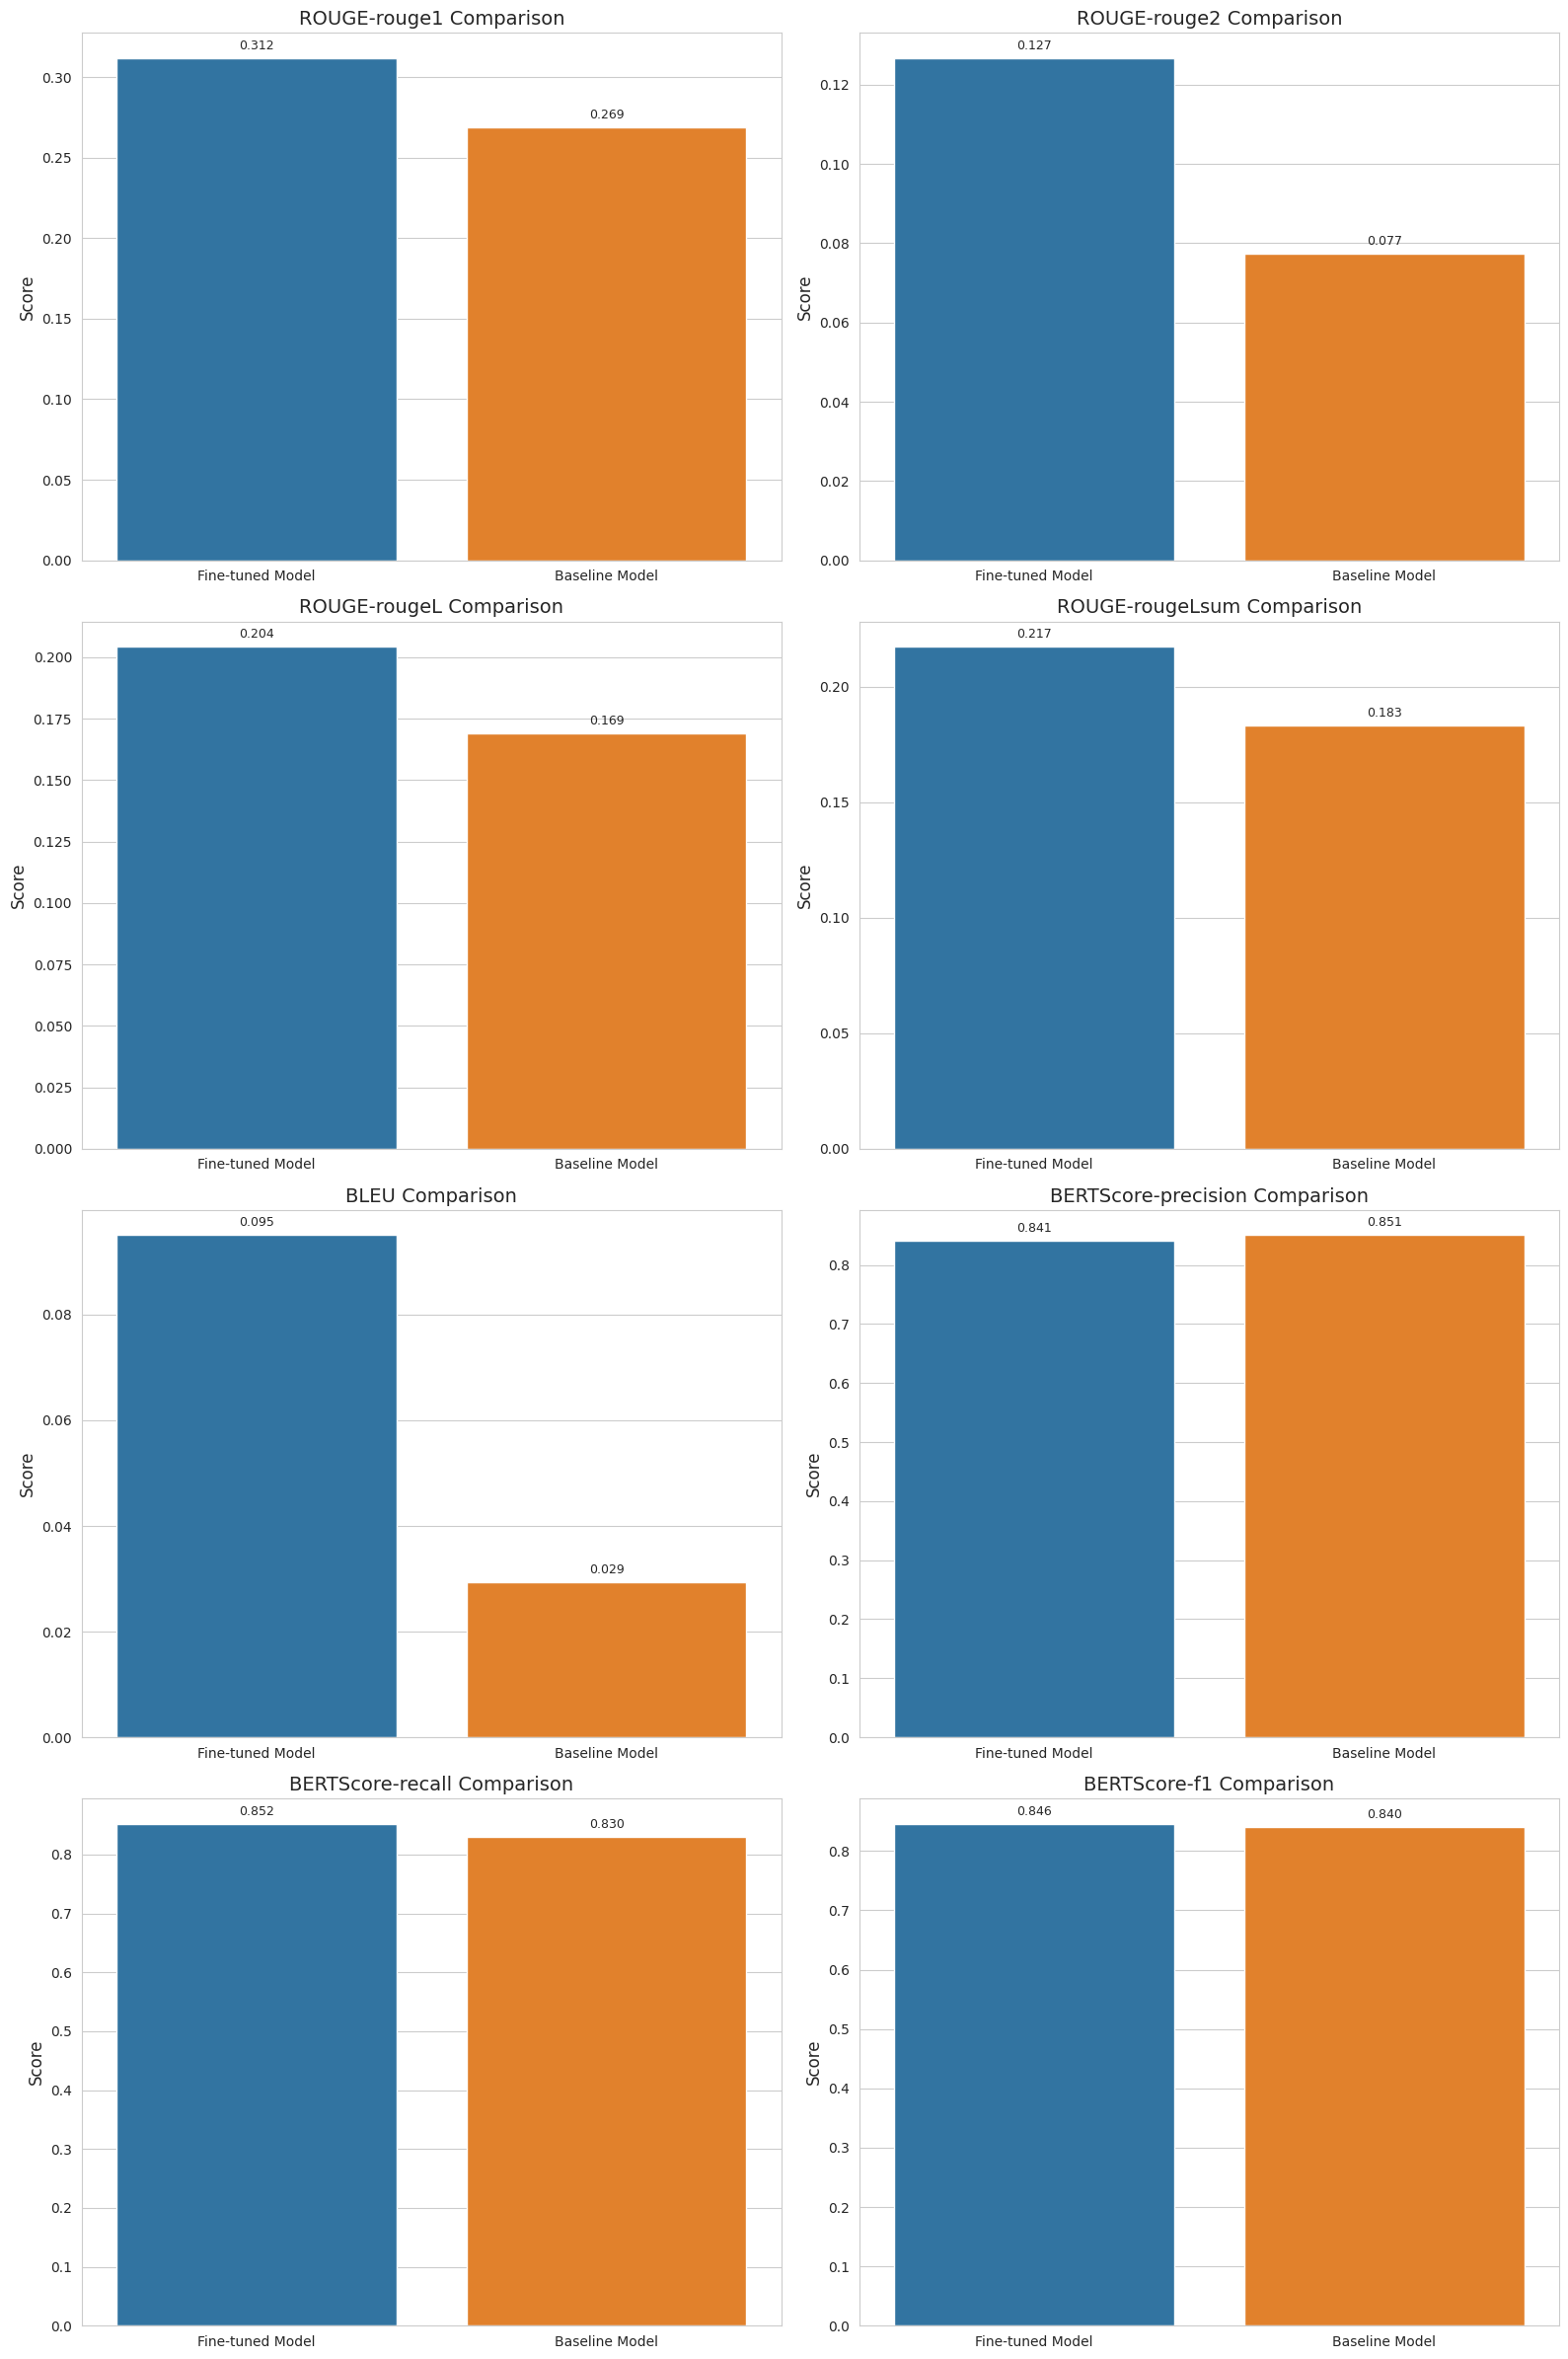

Visualizations of metric comparisons generated successfully.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For handling potential numpy float types from comparison_df

# Assuming comparison_df is available from the previous step

# 1. Prepare data for plotting
metrics = comparison_df['Metric'].tolist()
fine_tuned_scores = comparison_df['Fine-tuned Model'].tolist()
baseline_scores = comparison_df['Baseline Model'].tolist()

# 2. Create subplots for each metric
# There are 8 metrics, so 4 rows and 2 columns would be suitable
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Define colors for clarity
colors = ['#1f77b4', '#ff7f0e'] # Blue for fine-tuned, Orange for baseline

# 3. Iterate through each metric and create a bar chart
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Data for the current metric
    scores = [fine_tuned_scores[i], baseline_scores[i]]
    model_names = ['Fine-tuned Model', 'Baseline Model']

    # Ensure scores are float for plotting
    scores = [float(s) if isinstance(s, np.floating) else s for s in scores]

    sns.barplot(x=model_names, y=scores, palette=colors, ax=ax)

    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)

# 4. Adjust layout and display the plots
plt.tight_layout()
plt.show()

print("Visualizations of metric comparisons generated successfully.")

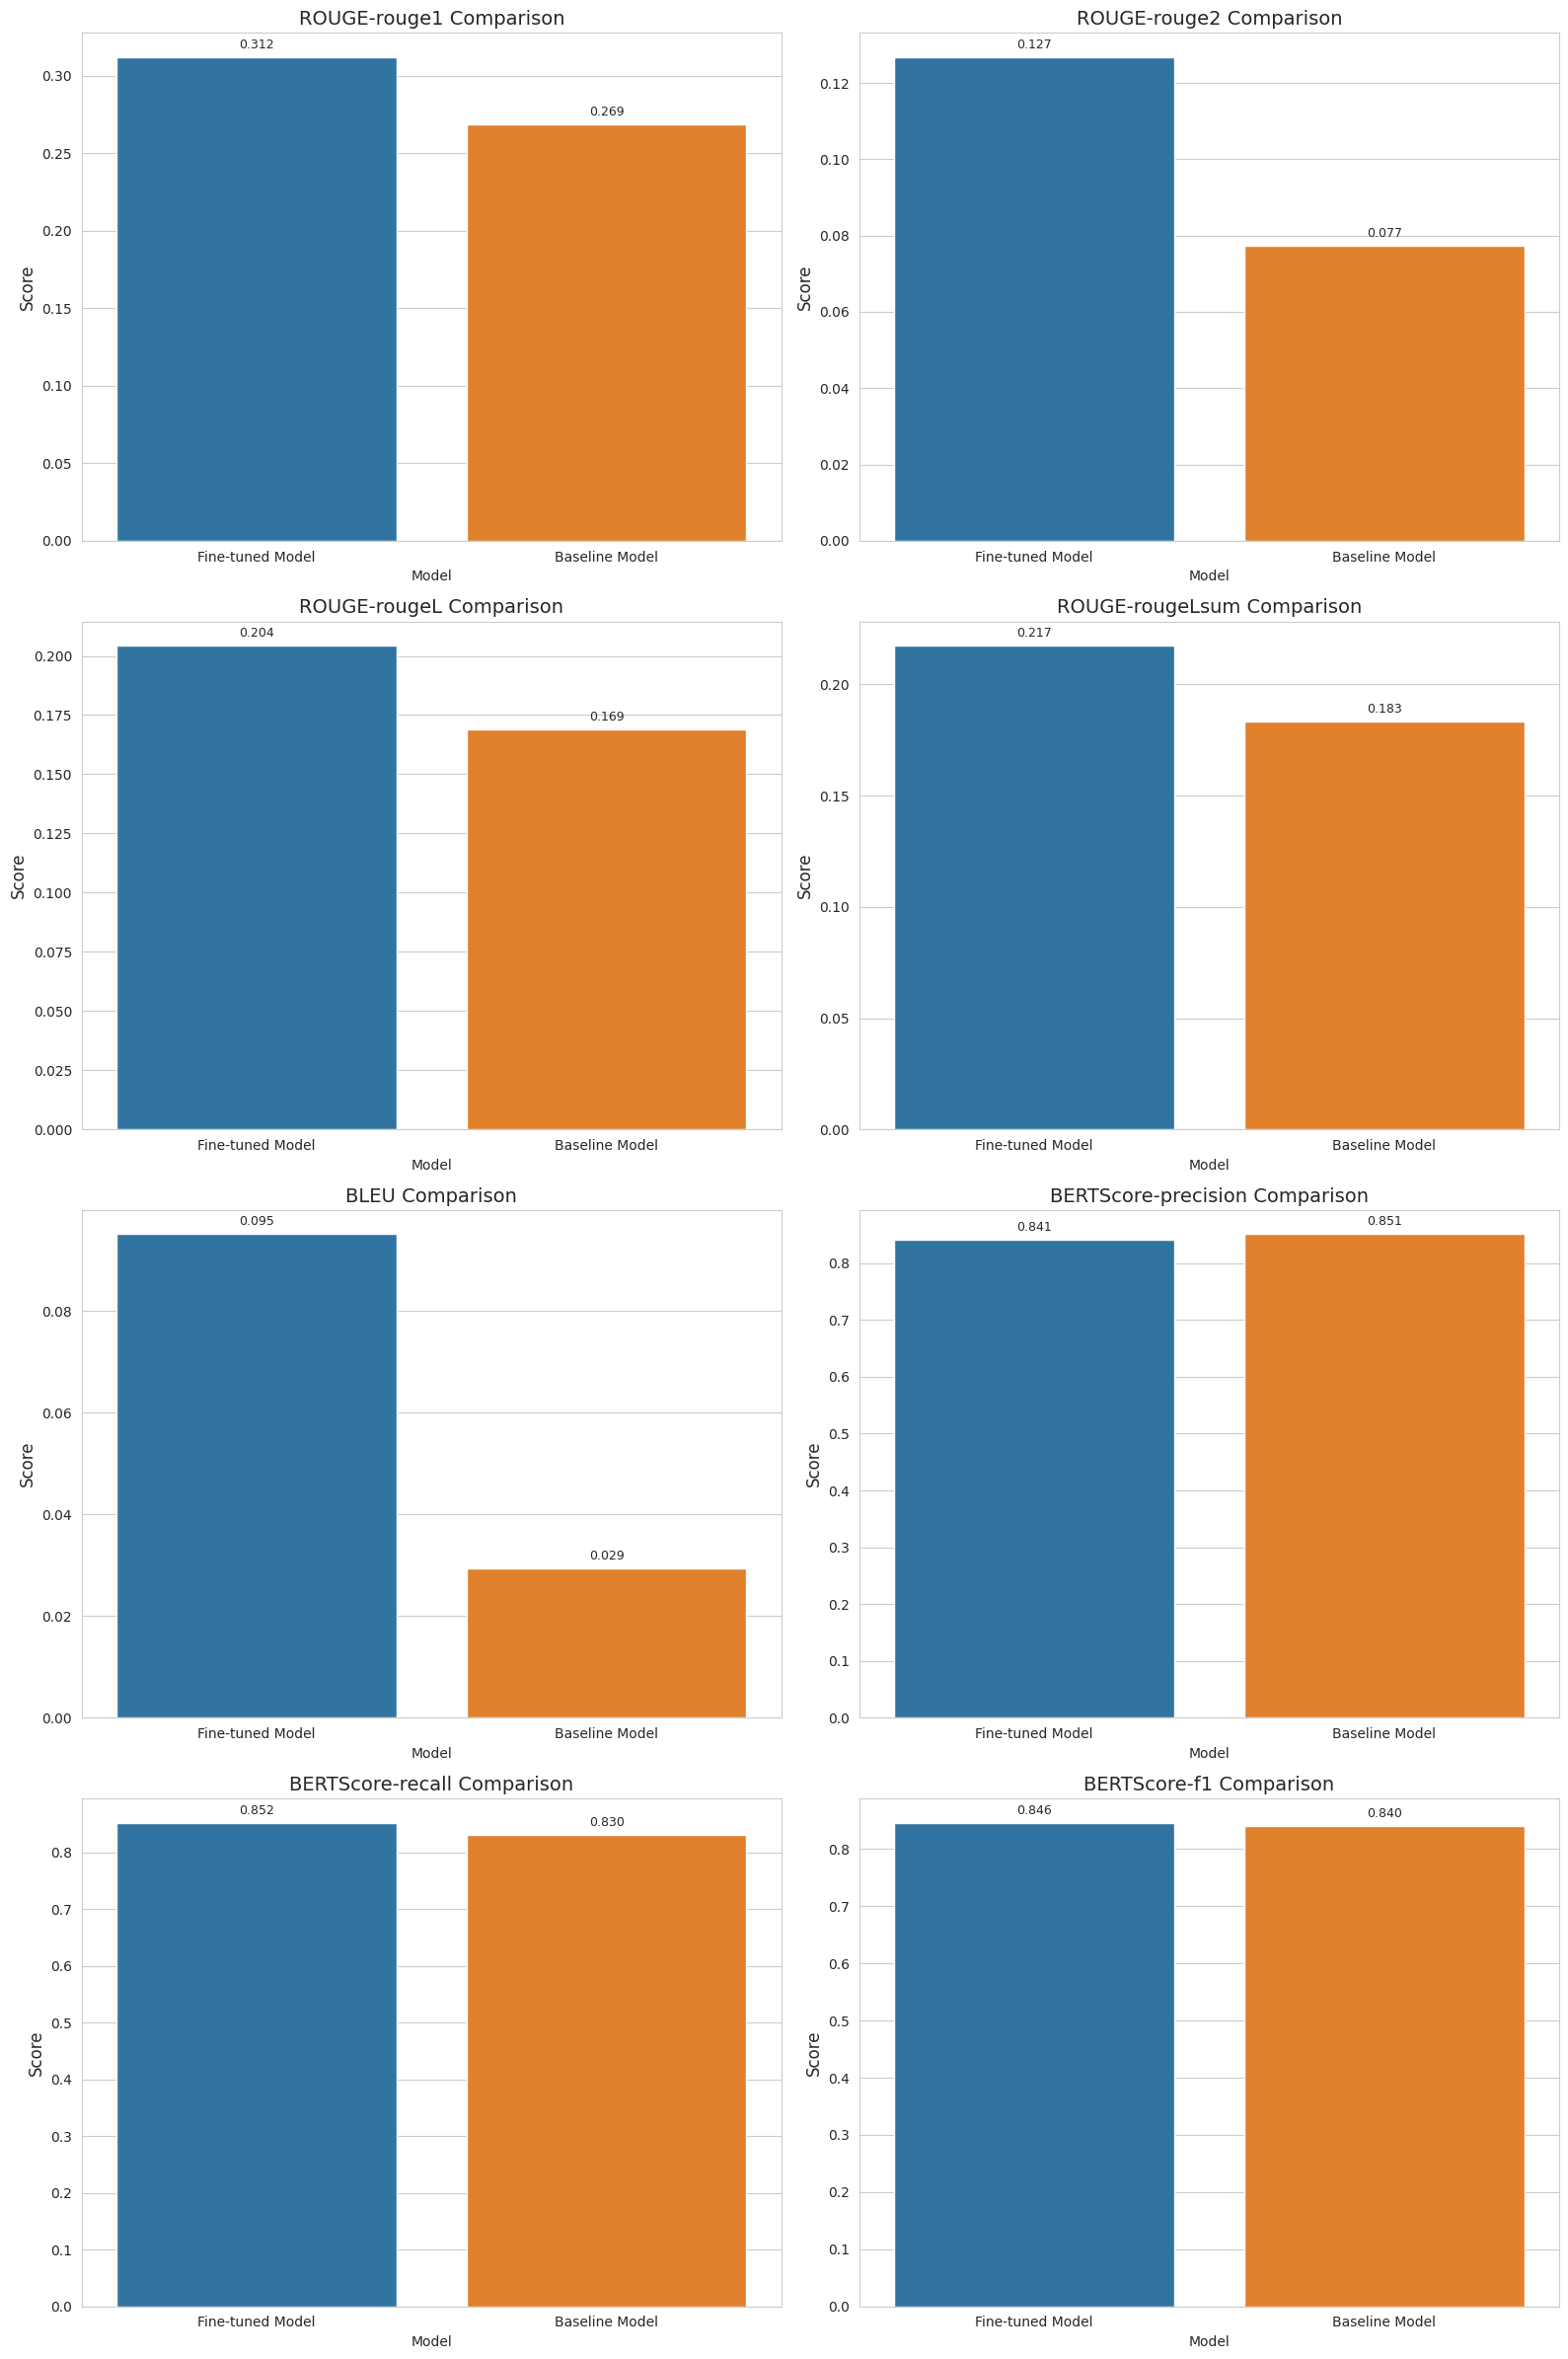

Visualizations of metric comparisons generated successfully.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For handling potential numpy float types from comparison_df
import pandas as pd # Import pandas for temporary DataFrame creation

# Assuming comparison_df is available from the previous step

# 1. Prepare data for plotting
metrics = comparison_df['Metric'].tolist()
fine_tuned_scores = comparison_df['Fine-tuned Model'].tolist()
baseline_scores = comparison_df['Baseline Model'].tolist()

# 2. Create subplots for each metric
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Define colors for clarity
colors = ['#1f77b4', '#ff7f0e'] # Blue for fine-tuned, Orange for baseline

# 3. Iterate through each metric and create a bar chart
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Data for the current metric
    scores_data = {
        'Model': ['Fine-tuned Model', 'Baseline Model'],
        'Score': [float(fine_tuned_scores[i]), float(baseline_scores[i])] # Ensure scores are float
    }
    temp_df = pd.DataFrame(scores_data)

    # Use hue for explicit coloring and legend control as per FutureWarning suggestion
    sns.barplot(x='Model', y='Score', hue='Model', data=temp_df, palette=colors, ax=ax, legend=False)

    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_ylabel('Score', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=9)

# 4. Adjust layout and display the plots
plt.tight_layout()
plt.show()

print("Visualizations of metric comparisons generated successfully.")

In [ ]:
from google.colab import userdata
from huggingface_hub import login
import os

# Retrieve Hugging Face token from secrets
HF_TOKEN = userdata.get('HF_TOKEN')

# Log in to Hugging Face
login(token=HF_TOKEN, add_to_git_credential=True)
print("Logged in to Hugging Face.")

# Define the repository name on Hugging Face Hub
hf_username = "Jeanrobert"
repo_id = f"{hf_username}/TinyLlama-1.1B-Chat-v1.0-Exp_004"

# Push the fine-tuned PEFT model to Hugging Face Hub
print(f"\nPushing fine-tuned model to Hugging Face Hub: {repo_id}...")
peft_model.push_to_hub(repo_id)
print("Fine-tuned PEFT model pushed successfully.")

# Push the tokenizer to Hugging Face Hub
print("\nPushing tokenizer to Hugging Face Hub...")
tokenizer.push_to_hub(repo_id)
print("Tokenizer pushed successfully.")

print("\nBoth fine-tuned model and tokenizer have been uploaded to Hugging Face.")

Logged in to Hugging Face.

Pushing fine-tuned model to Hugging Face Hub: Jeanrobert/TinyLlama-1.1B-Chat-v1.0-Exp_004...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   2%|2         |  562kB / 25.3MB            

Fine-tuned PEFT model pushed successfully.

Pushing tokenizer to Hugging Face Hub...


README.md: 0.00B [00:00, ?B/s]

Tokenizer pushed successfully.

Both fine-tuned model and tokenizer have been uploaded to Hugging Face.


# End :)